# NBA Team Analytics Pipeline

## Necessary Imports

In [31]:
import time
import re
from PIL import Image
import requests
import urllib
import urllib.request
from bs4 import BeautifulSoup

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.5g}'.format)
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.offsetbox import  OffsetImage

import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [32]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
team_names =     ['Utah Jazz', 'Sacramento Kings', 'Washington Wizards',
                  'Boston Celtics', 'Milwaukee Bucks', 'Oklahoma City Thunder',
                  'Chicago Bulls', 'Phoenix Suns', 'Philadelphia 76ers',
                  'New Orleans Pelicans', 'Charlotte Hornets', 'Los Angeles Lakers',
                  'Indiana Pacers', 'Toronto Raptors', 'Cleveland Cavaliers',
                  'Denver Nuggets', 'Minnesota Timberwolves', 'Brooklyn Nets',
                  'San Antonio Spurs', 'Dallas Mavericks', 'Houston Rockets',
                  'Detroit Pistons', 'Portland Trail Blazers', 'Atlanta Hawks',
                  'Golden State Warriors', 'Miami Heat', 'Los Angeles Clippers',
                  'New York Knicks', 'Memphis Grizzlies', 'Orlando Magic', 'League Average']

team_abbrs =     ['UTA', 'SAC', 'WAS', 'BOS', 'MIL', 'OKC', 'CHI', 'PHX', 'PHI',
                  'NOP', 'CHA', 'LAL', 'IND', 'TOR', 'CLE', 'DEN', 'MIN', 'BKN',
                  'SAS', 'DAL', 'HOU', 'DET', 'POR', 'ATL', 'GSW', 'MIA', 'LAC',
                  'NYK', 'MEM', 'ORL', 'NBA']

team_name_abbr_dict = {}
team_abbr_name_dict = {}
team_id_dict={}

for i in range(len(team_names)):
    team_name_abbr_dict[team_names[i]]=team_abbrs[i]

for i in range(len(team_abbrs)):
    team_abbr_name_dict[team_abbrs[i]]=team_names[i]

## Webscrape and Clean NBA Team Data into Pandas DF

In [33]:
url = 'https://stats.nba.com/stats/leaguegamelog'
headers= {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36',
          'Referer': 'https://www.nba.com/'}
payload = {
    'Counter': '1000',
    'DateFrom': '',
    'DateTo': '',
    'Direction': 'DESC',
    'LeagueID': '00',
    'PlayerOrTeam': 'T',
    'Season': '2022-23',
    'SeasonType': 'Regular Season',
    'Sorter': 'DATE'}

jsonData = requests.get(url, headers=headers, params=payload).json()


rows = jsonData['resultSets'][0]['rowSet']
columns = jsonData['resultSets'][0]['headers']

df = pd.DataFrame(rows, columns=columns)
df.drop(['VIDEO_AVAILABLE'], axis=1, inplace=True)


df['FG2M'] = df.FGM - df.FG3M
df['FG2A'] = df.FGA - df.FG3A

df['FG2_PTS'] = df.FG2M * 2
df['FG3_PTS'] = df.FG3M * 3

df['FRAC_ATT_2PT'] = df.FG2A / df.FGA
df['FRAC_ATT_3PT'] = df.FG3A / df.FGA

df['FRAC_MK_2PT'] = df.FG2M / df.FGM
df['FRAC_MK_3PT'] = df.FG3M / df.FGM

df['FRAC_PTS_2PT'] = df.FG2_PTS / df.PTS
df['FRAC_PTS_3PT'] = df.FG3_PTS / df.PTS
df['FRAC_PTS_FT'] = df.FTM / df.PTS 

df['OPP_TEAM_ABBR'] = df['MATCHUP'].str.strip().str[-3:]
df['OPP_PTS'] = df['PTS'] - df['PLUS_MINUS']

df['MONTH'] = pd.DatetimeIndex(df['GAME_DATE']).month
df['YEAR'] = pd.DatetimeIndex(df['GAME_DATE']).year

def home_or_away(string):
    if string[4]=='@': return 'AWAY'
    elif string[4]=='v': return 'HOME'
df['HOME_AWAY'] = df['MATCHUP'].map(home_or_away)

conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

df['CONFERENCE'] = df['TEAM_ABBREVIATION'].apply(lambda x: conferences.get(x))
df['OPP_CONFERENCE'] = df['OPP_TEAM_ABBR'].apply(lambda x: conferences.get(x))

# ADD OPONENTS RECORD ON GAME DATE
# ADD TEAM RECORD ON GAME DATE

df['DATE_MATCHUP'] = df['GAME_DATE'].str[5:] + ' ' + df['MATCHUP'].str[4:]
#df['DATE_MATCHUP'] = df['GAME_DATE'] + ' ' + df['MATCHUP'].str[4:]

df.TEAM_NAME = df.TEAM_ABBREVIATION.apply(lambda x: team_abbr_name_dict.get(x))

df.head()

SEASON_ID     TEAM_ID TEAM_ABBREVIATION             TEAM_NAME     GAME_ID  \
0     22022  1610612746               LAC  Los Angeles Clippers  0022200719   
1     22022  1610612747               LAL    Los Angeles Lakers  0022200719   
2     22022  1610612756               PHX          Phoenix Suns  0022200718   
3     22022  1610612766               CHA     Charlotte Hornets  0022200718   
4     22022  1610612742               DAL      Dallas Mavericks  0022200717   

    GAME_DATE      MATCHUP WL  MIN  FGM  FGA  FG_PCT  FG3M  FG3A  FG3_PCT  \
0  2023-01-24    LAC @ LAL  W  240   51   84   0.607    19    38      0.5   
1  2023-01-24  LAL vs. LAC  L  240   42   95   0.442    16    40      0.4   
2  2023-01-24  PHX vs. CHA  W  240   47   94     0.5    22    40     0.55   
3  2023-01-24    CHA @ PHX  L  240   39   96   0.406     6    25     0.24   
4  2023-01-24  DAL vs. WAS  L  240   47   89   0.528    10    30    0.333   

   FTM  FTA  FT_PCT  OREB  DREB  REB  AST  STL  BLK  TOV  PF  PTS  PLUS_MINUS  \
0   12   15     0.8     7    40   47   25    4    9   15  20  133          18   
1   15   24   0.625     9    23   32   21    8    4    7  13  115         -18   
2   12   13   0.923    15    40   55   38    3   10   18  21  128          31   
3   13   18   0.722    10    29   39   19   10    5   13  21   97         -31   
4   22   26   0.846     8    30   38   24    6    2    9  25  126          -1   

   FG2M  FG2A  FG2_PTS  FG3_PTS  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  \
0    32    46       64       57       0.54762       0.45238      0.62745   
1    26    55       52       48       0.57895       0.42105      0.61905   
2    25    54       50       66       0.57447       0.42553      0.53191   
3    33    71       66       18       0.73958       0.26042      0.84615   
4    37    59       74       30       0.66292       0.33708      0.78723   

   FRAC_MK_3PT  FRAC_PTS_2PT  FRAC_PTS_3PT  FRAC_PTS_FT OPP_TEAM_ABBR  \
0      0.37255        0.4812       0.42857     0.090226           LAL   
1      0.38095       0.45217       0.41739      0.13043           LAC   
2      0.46809       0.39062       0.51562      0.09375           CHA   
3      0.15385       0.68041       0.18557      0.13402           PHX   
4      0.21277        0.5873        0.2381       0.1746           WAS   

   OPP_PTS  MONTH  YEAR HOME_AWAY CONFERENCE OPP_CONFERENCE   DATE_MATCHUP  
0      115      1  2023      AWAY       WEST           WEST    01-24 @ LAL  
1      133      1  2023      HOME       WEST           WEST  01-24 vs. LAC  
2       97      1  2023      HOME       WEST           EAST  01-24 vs. CHA  
3      128      1  2023      AWAY       EAST           WEST    01-24 @ PHX  
4      127      1  2023      HOME       WEST           EAST  01-24 vs. WAS

In [34]:
ids = list(df.TEAM_ID.unique())
teams = list(df.TEAM_NAME.unique())

for i in range(len(teams)):
    team_id_dict[teams[i]]=ids[i]

## Create team averages dataframes for offense and defense

In [35]:
pivot_team_avg = pd.pivot_table(df, index=['TEAM_NAME','TEAM_ABBREVIATION'], aggfunc = 'mean')
df_team_avg = pivot_team_avg.reset_index()
df_team_avg.loc[30] = df_team_avg.drop(['TEAM_NAME','TEAM_ABBREVIATION'], axis=1).mean()
df_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_team_avg = df_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
df_team_avg = df_team_avg.drop(['MONTH','YEAR'],axis=1)
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR', 'PTS']
df_team_avg = df_team_avg[cols_to_move + [x for x in df_team_avg.columns if x not in cols_to_move]]

df_team_avg.head()

TEAM_NAME TEAM_ABBR    PTS    AST    BLK   DREB   FG2A   FG2M  \
0      Atlanta Hawks       ATL 115.62 24.167 4.9792 33.208 61.125 33.104   
1     Boston Celtics       BOS 117.63 26.571 5.3878 34.857 46.592 26.367   
2      Brooklyn Nets       BKN  113.7 26.283      7  33.13 52.761 30.522   
3  Charlotte Hornets       CHA 112.04 25.184 4.9592 32.673 59.571 31.041   
4      Chicago Bulls       CHI 114.62  24.34 4.6809 33.723 58.532 32.106   

   FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  FG_PCT  \
0   66.208 30.688 10.583  0.34742    31.75 91.812 43.688 0.47742   
1   52.735 41.653 15.449  0.36965   46.347 88.245 41.816 0.47508   
2   61.043 31.196  12.13  0.38811   36.391 83.957 42.652 0.50861   
3   62.082 33.041 10.776  0.32343   32.327 92.612 41.816 0.45269   
4   64.213 29.106 10.702  0.36262   32.106 87.638 42.809 0.48902   

   FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0       0.66453       0.33547      0.75515      0.24485       0.57171   
1       0.52725       0.47275      0.63057      0.36943       0.44848   
2       0.62705       0.37295      0.71468      0.28532       0.53641   
3       0.64379       0.35621      0.74273      0.25727       0.55557   
4       0.66695       0.33305      0.74998      0.25002        0.5616   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.27507      0.15321 21.542 17.667 0.82048  242.6   116.17 10.146   
1       0.39267      0.15885 22.388 18.551 0.83345 242.55   111.96 9.6327   
2       0.31942      0.14418 20.652 16.261 0.78948 240.54   110.65    7.5   
3       0.28605      0.15838 23.551 17.633 0.74496 243.06   119.08 12.122   
4       0.27895      0.15945 22.447 18.298  0.8096 242.66   114.72 8.7234   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV  
0 19.188    -0.54167 43.354 6.9583 1.6106e+09 12.979  
1 18.878      5.6735  44.49  6.449 1.6106e+09 13.571  
2 21.891      3.0435  40.63 7.1304 1.6106e+09  14.63  
3 21.143     -7.0408 44.796 7.9796 1.6106e+09 13.653  
4 19.745    -0.10638 42.447 7.6383 1.6106e+09  13.66

In [36]:
pivot_defense_allowed_team_avg = pd.pivot_table(df, index=['OPP_TEAM_ABBR'], aggfunc = 'mean')
df_defense_allowed_team_avg = pivot_defense_allowed_team_avg.reset_index()
df_defense_allowed_team_avg.loc[30] = df_defense_allowed_team_avg.drop(['OPP_TEAM_ABBR'], axis=1).mean()
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBREVIATION'})
df_defense_allowed_team_avg.loc[30, 'TEAM_NAME']='League Average'
df_defense_allowed_team_avg.loc[30, 'TEAM_ABBREVIATION']='NBA'
df_defense_allowed_team_avg['TEAM_NAME'] = df_defense_allowed_team_avg['TEAM_ABBREVIATION'].map(team_abbr_name_dict)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.drop(['YEAR','TEAM_ID'], axis=1)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'TEAM_ABBREVIATION':'TEAM_ABBR'})
cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_defense_allowed_team_avg = df_defense_allowed_team_avg[cols_to_move + [x for x in df_defense_allowed_team_avg.columns if x not in cols_to_move]]
df_defense_allowed_team_avg.rename(columns=lambda x: 'OPP_'+x, inplace=True)
df_defense_allowed_team_avg = df_defense_allowed_team_avg.rename(columns={'OPP_TEAM_ABBR':'TEAM_ABBR','OPP_TEAM_NAME':'TEAM_NAME'})


# Optional: Merge Offensive and Defensive Avg DFs
'''
df_team_avg = pd.merge(df_team_avg, 
                       df_defense_allowed_team_avg,
                       right_on='TEAM_ABBR',
                       left_on='TEAM_ABBR',
                       how='left')
df_team_avg = df_team_avg.drop(['TEAM_NAME_y', 'OPP_PTS_y'],axis=1)
df_team_avg = df_team_avg.rename(columns={'TEAM_NAME_x':'TEAM_NAME','OPP_PTS_x':'OPP_PTS'})
'''

df_defense_allowed_team_avg.head()

TEAM_NAME TEAM_ABBR  OPP_AST  OPP_BLK  OPP_DREB  OPP_FG2A  \
0      Atlanta Hawks       ATL   25.625   5.0625    34.958    57.083   
1      Brooklyn Nets       BKN   23.065   3.7609    32.457    55.543   
2     Boston Celtics       BOS   22.653   3.8571    34.041    57.571   
3  Charlotte Hornets       CHA   26.816    6.102    35.449     53.49   
4      Chicago Bulls       CHI   26.298   5.1702    34.021    51.447   

   OPP_FG2M  OPP_FG2_PTS  OPP_FG3A  OPP_FG3M  OPP_FG3_PCT  OPP_FG3_PTS  \
0    31.417       62.833    33.062    11.354      0.34231       34.062   
1    27.826       55.652    32.804    11.957      0.36359        35.87   
2    30.531       61.061     32.49    11.612      0.35776       34.837   
3    29.918       59.837    35.776    13.204      0.36618       39.612   
4    28.426       56.851    36.766     13.34      0.36219       40.021   

   OPP_FGA  OPP_FGM  OPP_FG_PCT  OPP_FRAC_ATT_2PT  OPP_FRAC_ATT_3PT  \
0   90.146   42.771     0.47631           0.63352           0.36648   
1   88.348   39.783     0.45093           0.62689           0.37311   
2   90.061   42.143     0.46914           0.63932           0.36068   
3   89.265   43.122     0.48431           0.59878           0.40122   
4   88.213   41.766     0.47549           0.58316           0.41684   

   OPP_FRAC_MK_2PT  OPP_FRAC_MK_3PT  OPP_FRAC_PTS_2PT  OPP_FRAC_PTS_3PT  \
0          0.73563          0.26437           0.54186            0.2912   
1          0.69722          0.30278           0.50363           0.32334   
2          0.72383          0.27617           0.54678           0.30991   
3          0.69278          0.30722           0.50403           0.33082   
4          0.68005          0.31995           0.49714           0.34787   

   OPP_FRAC_PTS_FT  OPP_FTA  OPP_FTM  OPP_FT_PCT  OPP_MIN  OPP_MONTH  \
0          0.16695       24   19.271         0.8    242.6     8.6458   
1          0.17303   25.043    19.13     0.76452   240.54     8.9565   
2          0.14331   20.592   16.061     0.77853   242.55     8.5102   
3          0.16515   24.918   19.633     0.79435   243.06     8.7347   
4          0.15499   23.064   17.851     0.77428   242.66     8.8298   

   OPP_OPP_PTS  OPP_OREB  OPP_PF  OPP_PLUS_MINUS  OPP_PTS  OPP_REB  OPP_STL  \
0       115.62    11.271  20.062         0.54167   116.17   46.229   7.3542   
1        113.7    11.478  18.304         -3.0435   110.65   43.935   7.4348   
2       117.63    9.6735  19.551         -5.6735   111.96   43.714    6.551   
3       112.04    10.776  20.796          7.0408   119.08   46.224    6.449   
4       114.62    9.8511      19         0.10638   114.72   43.872   6.5745   

   OPP_TOV  
0   14.812  
1   14.196  
2       13  
3   15.163  
4       15

## Advanced Shooting Analytics Dataframe

In [37]:
tables = pd.read_html("https://www.basketball-reference.com/leagues/NBA_2023.html#shooting-team")

df_team_advshot = tables[12]
df_team_advshot.columns = [' '.join(col) for col in df_team_advshot.columns]
df_team_advshot.columns = df_team_advshot.columns.str.replace("Unnamed:", "")
df_team_advshot.columns = df_team_advshot.columns.str.replace("_level_0", "")
df_team_advshot = df_team_advshot.drop([' 0 Rk',
                                        ' 6  6_level_1',
                                        ' 13  13_level_1',
                                        ' 20  20_level_1',
                                        ' 23  23_level_1',
                                        ' 26  26_level_1',
                                        ' 29  29_level_1'], axis=1)

df_team_advshot = df_team_advshot.rename(columns={' 1 Team':'TEAM_NAME',
                                                  ' 2 G':'G',
                                                  ' 3 MP':'MP',
                                                  ' 4 FG%':'FG%',
                                                  ' 5 Dist.':'Dist'})


df_team_advshot['TEAM_ABBR'] = df_team_advshot['TEAM_NAME']
df_team_advshot['TEAM_ABBR']=df_team_advshot['TEAM_ABBR'].map(team_name_abbr_dict)

cols_to_move = ['TEAM_NAME', 'TEAM_ABBR']
df_team_advshot = df_team_advshot[cols_to_move + [x for x in df_team_advshot.columns if x not in cols_to_move]]


df_team_advshot.head()

TEAM_NAME TEAM_ABBR   G     MP   FG%  Dist  \
0      Atlanta Hawks       ATL  48  11645 0.474  13.2   
1     Boston Celtics       BOS  49  11885 0.468  14.2   
2      Brooklyn Nets       BKN  46  11065  0.45  13.4   
3      Chicago Bulls       CHI  47  11405 0.473  14.3   
4  Charlotte Hornets       CHA  49  11910 0.483  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.633                     0.293   
1                    0.639                     0.208   
2                    0.629                     0.264   
3                    0.583                     0.272   
4                    0.599                     0.256   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.173                       0.101   
1                      0.223                       0.113   
2                      0.214                       0.087   
3                      0.165                       0.085   
4                      0.189                       0.092   

   % of FGA by Distance 16-3P  % of FGA by Distance 3P  FG% by Distance 2P  \
0                       0.067                    0.367                0.55   
1                       0.094                    0.361                0.53   
2                       0.064                    0.371               0.501   
3                       0.062                    0.417               0.553   
4                       0.063                    0.401               0.559   

   FG% by Distance 0-3  FG% by Distance 3-10  FG% by Distance 10-16  \
0                0.692                 0.439                  0.423   
1                0.679                  0.46                  0.439   
2                0.663                 0.388                  0.388   
3                0.689                 0.457                   0.43   
4                0.682                 0.461                  0.474   

   FG% by Distance 16-3P  FG% by Distance 3P  % of FG Ast'd 2P  \
0                   0.41               0.343             0.509   
1                  0.476               0.357             0.451   
2                  0.363               0.364             0.474   
3                  0.376               0.363             0.526   
4                  0.482               0.369             0.518   

   % of FG Ast'd 3P  Dunks %FGA  Dunks Md.  Layups %FGA  Layups Md.  \
0             0.848       0.069        273        0.287         711   
1             0.766       0.051        204        0.276         663   
2             0.825       0.051        192        0.302         641   
3              0.85       0.062        235        0.265         642   
4             0.856       0.065        237        0.267         639   

   Corner %3PA  Corner 3P%  
0        0.239       0.387  
1        0.177       0.377  
2        0.233       0.399  
3        0.241       0.336  
4        0.252       0.423

## Function Field Goal Trends based on Distance

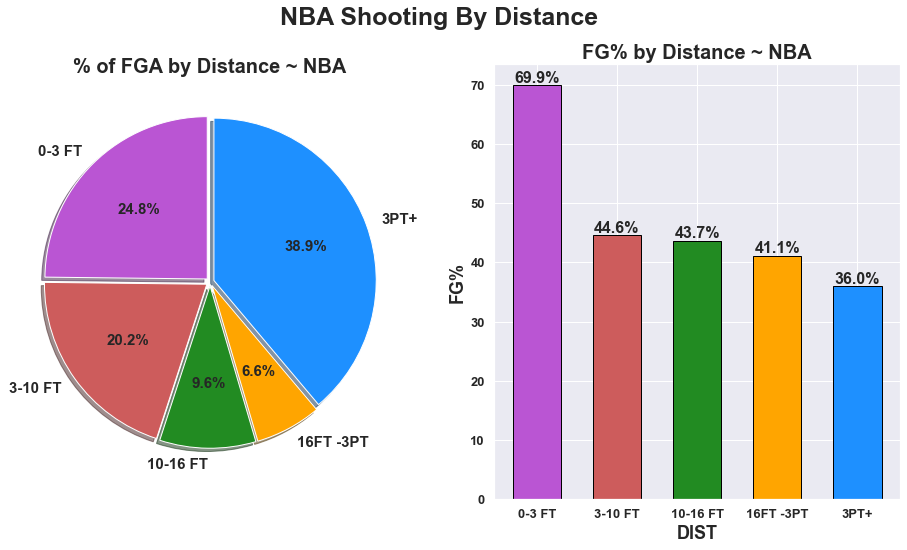

In [38]:
def nba_fg_by_dist():
    plt.rcParams["figure.figsize"] = (10,10)
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']

    att_dist_data = df_team_advshot[['% of FGA by Distance 0-3',
                             '% of FGA by Distance 3-10', 
                             '% of FGA by Distance 10-16', 
                             '% of FGA by Distance 16-3P', 
                             '% of FGA by Distance 3P']].mean()
    
    
    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    
    ax[0].pie(att_dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title('% of FGA by Distance ~ NBA', fontsize=20, fontweight='bold')
    
    per_dist_data = df_team_advshot[['FG% by Distance 0-3',
                                     'FG% by Distance 3-10',
                                     'FG% by Distance 10-16',
                                     'FG% by Distance 16-3P',
                                     'FG% by Distance 3P']].mean()*100
    
    per_dist = list(per_dist_data.keys())
    per_values = list(per_dist_data)
    
    barWidth = 0.6
    
    ax[1].bar(per_dist, per_values, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title('FG% by Distance ~ NBA', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
        
    plt.suptitle('NBA Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
nba_fg_by_dist()

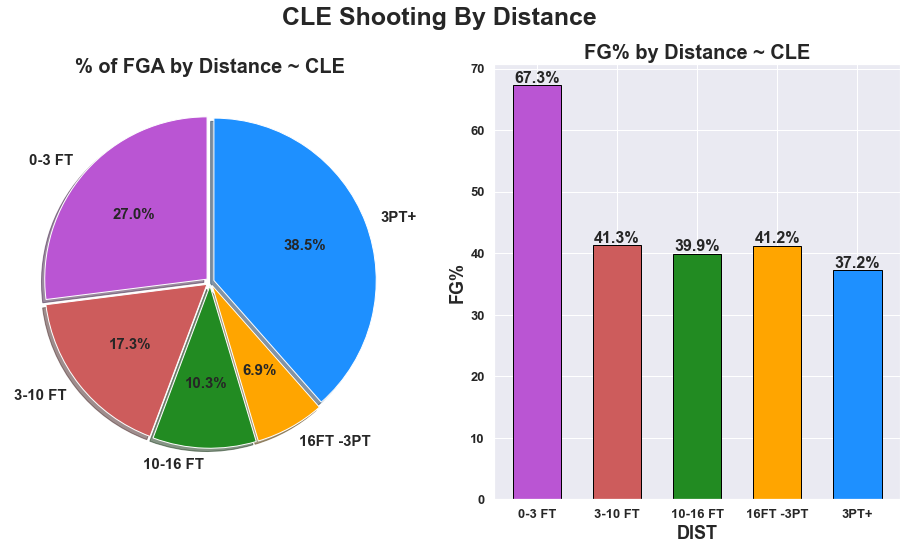

In [39]:
def team_fg_by_dist(abbr):
    
    colors = ['mediumorchid', 'indianred', 'forestgreen', 'orange', 'dodgerblue']
    barWidth = 0.6
    
    plt.rcParams["figure.figsize"] = (10,10)
    
    dist_data = list(np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['% of FGA by Distance 3P'].item()]))
    
    dist_data_pct = np.array(
        [df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 0-3'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3-10'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 10-16'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 16-3P'].item(),
         df_team_advshot[df_team_advshot['TEAM_ABBR']==abbr]['FG% by Distance 3P'].item()])*100

    labels = ['0-3 FT',                
              '3-10 FT', 
              '10-16 FT', 
              '16FT -3PT', 
              '3PT+']

    explode=[.025,.025,.025,.025,.025]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax[0].pie(dist_data, 
            labels=labels, 
            explode=explode, 
            shadow=True, 
            colors=colors,
            autopct='%1.1f%%',
            startangle=90,
           textprops={'fontsize': 15, 'fontweight':'bold'})
    ax[0].set_title(f'% of FGA by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    
    ax[1].bar(labels, dist_data_pct, width=barWidth, color=colors, edgecolor='black')
    ax[1].bar_label(ax[1].containers[0], fontsize=16, fontweight='bold', fmt = '%.1f%%')
    ax[1].set_title(f'FG% by Distance ~ {abbr}', fontsize=20, fontweight='bold')
    ax[1].set_xticks([r for r in range(len(labels))], labels, fontsize=13, fontweight='bold')
    ax[1].set_xlabel('DIST', fontsize=18, fontweight='bold')
    ax[1].set_ylabel('FG%', fontsize=18, fontweight='bold')
    plt.yticks(size=13, fontweight='bold')
    
    plt.suptitle(f'{abbr} Shooting By Distance', fontsize=25, fontweight='bold')
    plt.show()
    
team_fg_by_dist('CLE')

## Function to return a teams dataframe

In [40]:
def get_team_df(TEAM_ABBR):
    team_df = df[df['TEAM_ABBREVIATION']==TEAM_ABBR]
    return team_df

## Webscrape NBA records data into a pandas dataframe

In [41]:
columns = ['TEAM_ABBR','TEAM_NAME','CONFERENCE','GAMES','WINS','LOSES','WIN_PER','LAST_10_WINS','LAST_10_LOSES','HOME_WINS','HOME_LOSES','AWAY_WINS','AWAY_LOSES',
           'WEST_WINS', 'WEST_LOSES', 'EAST_WINS', 'EAST_LOSES']
data_records=[]
conferences = {'GSW':'WEST', 'POR':'WEST', 'SAC':'WEST', 'UTA':'WEST', 'MIA':'EAST', 'DEN':'WEST', 'MIN':'WEST',
               'PHI':'EAST', 'NOP':'EAST', 'ORL':'EAST', 'MIL':'EAST', 'CHI':'EAST','DET':'EAST', 'TOR':'EAST',
               'PHX':'WEST', 'LAL':'WEST', 'ATL':'EAST', 'WAS':'EAST', 'MEM':'WEST', 'CLE':'EAST', 'LAC':'WEST',
               'BOS':'EAST', 'NYK':'EAST', 'IND':'EAST', 'CHA':'EAST', 'SAS':'WEST', 'HOU':'WEST', 'DAL':'WEST',
               'OKC':'WEST', 'BKN':'EAST'}

for i in df.TEAM_ABBREVIATION.unique(): 
    
    team_abbr = i
    
    team_name = team_abbr_name_dict[i]
    
    games = df[(df['TEAM_ABBREVIATION']==i)]['WL'].count() 
    
    wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')]['WL'].count()
    loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')]['WL'].count()
    
    win_per = wins/games
    
    last_10_df = get_team_df(i).head(10)
    
    last_10_wins = last_10_df[last_10_df['WL']=='W']['WL'].count()
    last_10_loses = last_10_df[last_10_df['WL']=='L']['WL'].count()
    
    home_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    home_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='HOME')]['WL'].count()
    
    away_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    away_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L') & (df['HOME_AWAY']=='AWAY')]['WL'].count()
    
    west_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    west_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='WEST')]['WL'].count()
    
    east_wins = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='W')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    east_loses = df[(df['TEAM_ABBREVIATION']==i) & (df['WL']=='L')  & (df['OPP_CONFERENCE']=='EAST')]['WL'].count()
    
    conference = conferences[i]
    
    values = [team_abbr, team_name, conference, games, wins, loses, win_per, last_10_wins, last_10_loses, home_wins, home_loses, away_wins, away_loses,
              west_wins, west_loses, east_wins, east_loses]
    zipped = zip(columns, values)
    a_dictionary = dict(zipped)
    data_records.append(a_dictionary)
    
df_records=pd.DataFrame(data_records).sort_values('WINS',ascending=False).reset_index(drop=True)


df_records

TEAM_ABBR               TEAM_NAME CONFERENCE  GAMES  WINS  LOSES  WIN_PER  \
0        BOS          Boston Celtics       EAST     49    35     14  0.71429   
1        DEN          Denver Nuggets       WEST     48    34     14  0.70833   
2        MEM       Memphis Grizzlies       WEST     47    31     16  0.65957   
3        PHI      Philadelphia 76ers       EAST     46    30     16  0.65217   
4        MIL         Milwaukee Bucks       EAST     47    30     17   0.6383   
5        CLE     Cleveland Cavaliers       EAST     49    29     20  0.59184   
6        BKN           Brooklyn Nets       EAST     46    29     17  0.63043   
7        MIA              Miami Heat       EAST     49    27     22  0.55102   
8        SAC        Sacramento Kings       WEST     46    27     19  0.58696   
9        NYK         New York Knicks       EAST     49    26     23  0.53061   
10       NOP    New Orleans Pelicans       EAST     48    26     22  0.54167   
11       LAC    Los Angeles Clippers       WEST     50    26     24     0.52   
12       UTA               Utah Jazz       WEST     50    25     25      0.5   
13       DAL        Dallas Mavericks       WEST     49    25     24   0.5102   
14       PHX            Phoenix Suns       WEST     49    25     24   0.5102   
15       MIN  Minnesota Timberwolves       WEST     49    24     25   0.4898   
16       IND          Indiana Pacers       EAST     49    24     25   0.4898   
17       ATL           Atlanta Hawks       EAST     48    24     24      0.5   
18       OKC   Oklahoma City Thunder       WEST     47    23     24  0.48936   
19       GSW   Golden State Warriors       WEST     47    23     24  0.48936   
20       POR  Portland Trail Blazers       WEST     47    22     25  0.46809   
21       CHI           Chicago Bulls       EAST     47    22     25  0.46809   
22       LAL      Los Angeles Lakers       WEST     48    22     26  0.45833   
23       WAS      Washington Wizards       EAST     47    21     26  0.44681   
24       TOR         Toronto Raptors       EAST     48    21     27   0.4375   
25       ORL           Orlando Magic       EAST     47    18     29  0.38298   
26       SAS       San Antonio Spurs       WEST     47    14     33  0.29787   
27       CHA       Charlotte Hornets       EAST     49    13     36  0.26531   
28       DET         Detroit Pistons       EAST     49    12     37   0.2449   
29       HOU         Houston Rockets       WEST     47    11     36  0.23404   

    LAST_10_WINS  LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  \
0              8              2         18           5         17           9   
1              9              1         22           4         12          10   
2              7              3         20           3         11          13   
3              8              2         17           7         13           9   
4              6              4         18           5         12          12   
5              4              6         20           5          9          15   
6              5              5         13           7         16          10   
7              7              3         16           9         11          13   
8              7              3         16          10         11           9   
9              5              5         12          13         14          10   
10             2              8         17           7          9          15   
11             5              5         13          11         13          13   
12             6              4         16           9          9          16   
13             3              7         17           9          8          15   
14             5              5         18           7          7          17   
15             6              4         16          10          8          15   
16             3              7         16           9          8          16   
17             6              4         13          10         1

## Merge W-L onto Team Averages DF

In [42]:
df_team_avg_wl = pd.merge(df_records[['TEAM_ABBR','TEAM_NAME','WINS','LOSES','WIN_PER']],
                          df_team_avg.drop(columns=['TEAM_NAME']),
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')
df_team_avg_wl.head()

TEAM_ABBR           TEAM_NAME  WINS  LOSES  WIN_PER    PTS    AST    BLK  \
0       BOS      Boston Celtics    35     14  0.71429 117.63 26.571 5.3878   
1       DEN      Denver Nuggets    34     14  0.70833 116.85 28.729 4.4167   
2       MEM   Memphis Grizzlies    31     16  0.65957 117.04 25.383 6.0426   
3       PHI  Philadelphia 76ers    30     16  0.65217 114.07 25.065 4.9565   
4       MIL     Milwaukee Bucks    30     17   0.6383 113.19 24.894 5.1064   

    DREB   FG2A   FG2M  FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  \
0 34.857 46.592 26.367   52.735 41.653 15.449  0.36965   46.347 88.245 41.816   
1 32.646 55.271 31.646   63.292 30.646 12.167  0.39431     36.5 85.917 43.812   
2 35.638 60.277 32.255   64.511 32.936 11.511  0.34983   34.532 93.213 43.766   
3 32.087 51.413 28.174   56.348 33.326 12.652  0.37635   37.957 84.739 40.826   
4 36.426 50.064 26.936   53.872 39.702 14.191   0.3584   42.574 89.766 41.128   

   FG_PCT  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0 0.47508       0.52725       0.47275      0.63057      0.36943       0.44848   
1 0.51123       0.64339       0.35661       0.7204       0.2796       0.54264   
2    0.47       0.64645       0.35355      0.73729      0.26271       0.55285   
3 0.48296        0.6058        0.3942      0.68739      0.31261       0.49528   
4 0.45947       0.55729       0.44271      0.65294      0.34706       0.47458   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.39267      0.15885 22.388 18.551 0.83345 242.55   111.96 9.6327   
1        0.3118      0.14556 22.979 17.062 0.74433 241.04   112.56 10.083   
2       0.29301      0.15415 25.298     18 0.72274 241.06   112.36  13.34   
3       0.33128      0.17344 23.957 19.761   0.825 242.72   110.22  8.587   
4       0.37705      0.14837 22.532 16.745 0.74736 242.13   111.77 11.851   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV  
0 18.878      5.6735  44.49  6.449 1.6106e+09 13.571  
1 19.333      4.2917 42.729 7.4792 1.6106e+09 14.896  
2 20.106      4.6809 48.979 8.0851 1.6106e+09  14.34  
3 20.717      3.8478 40.674 7.9565 1.6106e+09 14.065  
4  18.34      1.4255 48.277 6.5957 1.6106e+09 15.298

## Master DataFrame for all team averages + records

In [43]:
df_team_master = pd.merge(df_records,
                          df_team_avg.drop(columns=['TEAM_NAME']),
                         left_on='TEAM_ABBR',
                         right_on='TEAM_ABBR',
                         how='left')

df_team_master = pd.merge(df_team_master,
                          df_team_advshot.drop(columns=['TEAM_NAME']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

df_team_master = pd.merge(df_team_master,
                          df_defense_allowed_team_avg.drop(columns=['TEAM_NAME', 'OPP_PTS']),
                          left_on='TEAM_ABBR',
                          right_on='TEAM_ABBR',
                          how='left')

df_team_master.head()

TEAM_ABBR           TEAM_NAME CONFERENCE  GAMES  WINS  LOSES  WIN_PER  \
0       BOS      Boston Celtics       EAST     49    35     14  0.71429   
1       DEN      Denver Nuggets       WEST     48    34     14  0.70833   
2       MEM   Memphis Grizzlies       WEST     47    31     16  0.65957   
3       PHI  Philadelphia 76ers       EAST     46    30     16  0.65217   
4       MIL     Milwaukee Bucks       EAST     47    30     17   0.6383   

   LAST_10_WINS  LAST_10_LOSES  HOME_WINS  HOME_LOSES  AWAY_WINS  AWAY_LOSES  \
0             8              2         18           5         17           9   
1             9              1         22           4         12          10   
2             7              3         20           3         11          13   
3             8              2         17           7         13           9   
4             6              4         18           5         12          12   

   WEST_WINS  WEST_LOSES  EAST_WINS  EAST_LOSES    PTS    AST    BLK   DREB  \
0         13           4         22          10 117.63 26.571 5.3878 34.857   
1         24           9         10           5 116.85 28.729 4.4167 32.646   
2         13          12         18           4 117.04 25.383 6.0426 35.638   
3         12           5         18          11 114.07 25.065 4.9565 32.087   
4         11           4         19          13 113.19 24.894 5.1064 36.426   

    FG2A   FG2M  FG2_PTS   FG3A   FG3M  FG3_PCT  FG3_PTS    FGA    FGM  \
0 46.592 26.367   52.735 41.653 15.449  0.36965   46.347 88.245 41.816   
1 55.271 31.646   63.292 30.646 12.167  0.39431     36.5 85.917 43.812   
2 60.277 32.255   64.511 32.936 11.511  0.34983   34.532 93.213 43.766   
3 51.413 28.174   56.348 33.326 12.652  0.37635   37.957 84.739 40.826   
4 50.064 26.936   53.872 39.702 14.191   0.3584   42.574 89.766 41.128   

   FG_PCT  FRAC_ATT_2PT  FRAC_ATT_3PT  FRAC_MK_2PT  FRAC_MK_3PT  FRAC_PTS_2PT  \
0 0.47508       0.52725       0.47275      0.63057      0.36943       0.44848   
1 0.51123       0.64339       0.35661       0.7204       0.2796       0.54264   
2    0.47       0.64645       0.35355      0.73729      0.26271       0.55285   
3 0.48296        0.6058        0.3942      0.68739      0.31261       0.49528   
4 0.45947       0.55729       0.44271      0.65294      0.34706       0.47458   

   FRAC_PTS_3PT  FRAC_PTS_FT    FTA    FTM  FT_PCT    MIN  OPP_PTS   OREB  \
0       0.39267      0.15885 22.388 18.551 0.83345 242.55   111.96 9.6327   
1        0.3118      0.14556 22.979 17.062 0.74433 241.04   112.56 10.083   
2       0.29301      0.15415 25.298     18 0.72274 241.06   112.36  13.34   
3       0.33128      0.17344 23.957 19.761   0.825 242.72   110.22  8.587   
4       0.37705      0.14837 22.532 16.745 0.74736 242.13   111.77 11.851   

      PF  PLUS_MINUS    REB    STL    TEAM_ID    TOV   G     MP   FG%  Dist  \
0 18.878      5.6735  44.49  6.449 1.6106e+09 13.571  49  11885 0.468  14.2   
1 19.333      4.2917 42.729 7.4792 1.6106e+09 14.896  48  11570 0.478  13.8   
2 20.106      4.6809 48.979 8.0851 1.6106e+09  14.34  47  11330 0.446    14   
3 20.717      3.8478 40.674 7.9565 1.6106e+09 14.065  46  11165 0.469  14.1   
4  18.34      1.4255 48.277 6.5957 1.6106e+09 15.298  47  11380 0.457  14.1   

   % of FGA by Distance 2P  % of FGA by Distance 0-3  \
0                    0.639                     0.208   
1                    0.612                     0.234   
2                    0.596                     0.262   
3                    0.616                     0.265   
4                    0.636                     0.234   

   % of FGA by Distance 3-10  % of FGA by Distance 10-16  \
0                      0.223                       0.113   
1                      0.232                       0.092   
2                      0.183                       0.091   
3                      0.175                       0.092   
4                      0.185                        0.14   

   % of FGA by Distance 16-

## Correlation Heatmap for Team Average DF

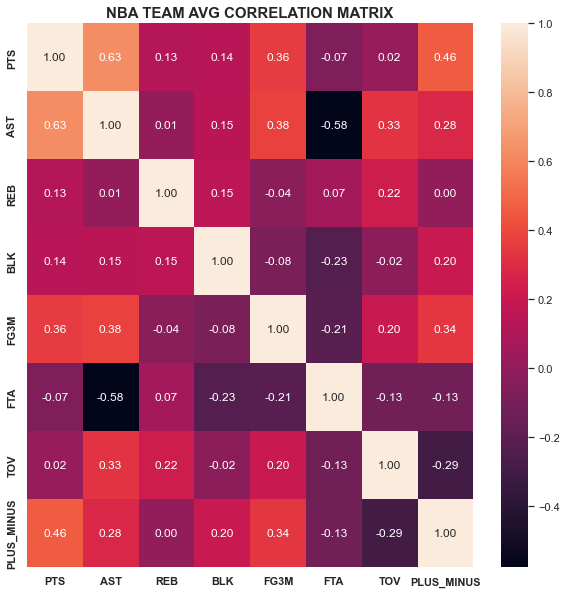

In [44]:
sns.heatmap(df_team_avg[['PTS','AST','REB','BLK','FG3M','FTA','TOV', 'PLUS_MINUS']].corr(), annot=True, fmt='.2f')
plt.title('NBA TEAM AVG CORRELATION MATRIX', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.show()

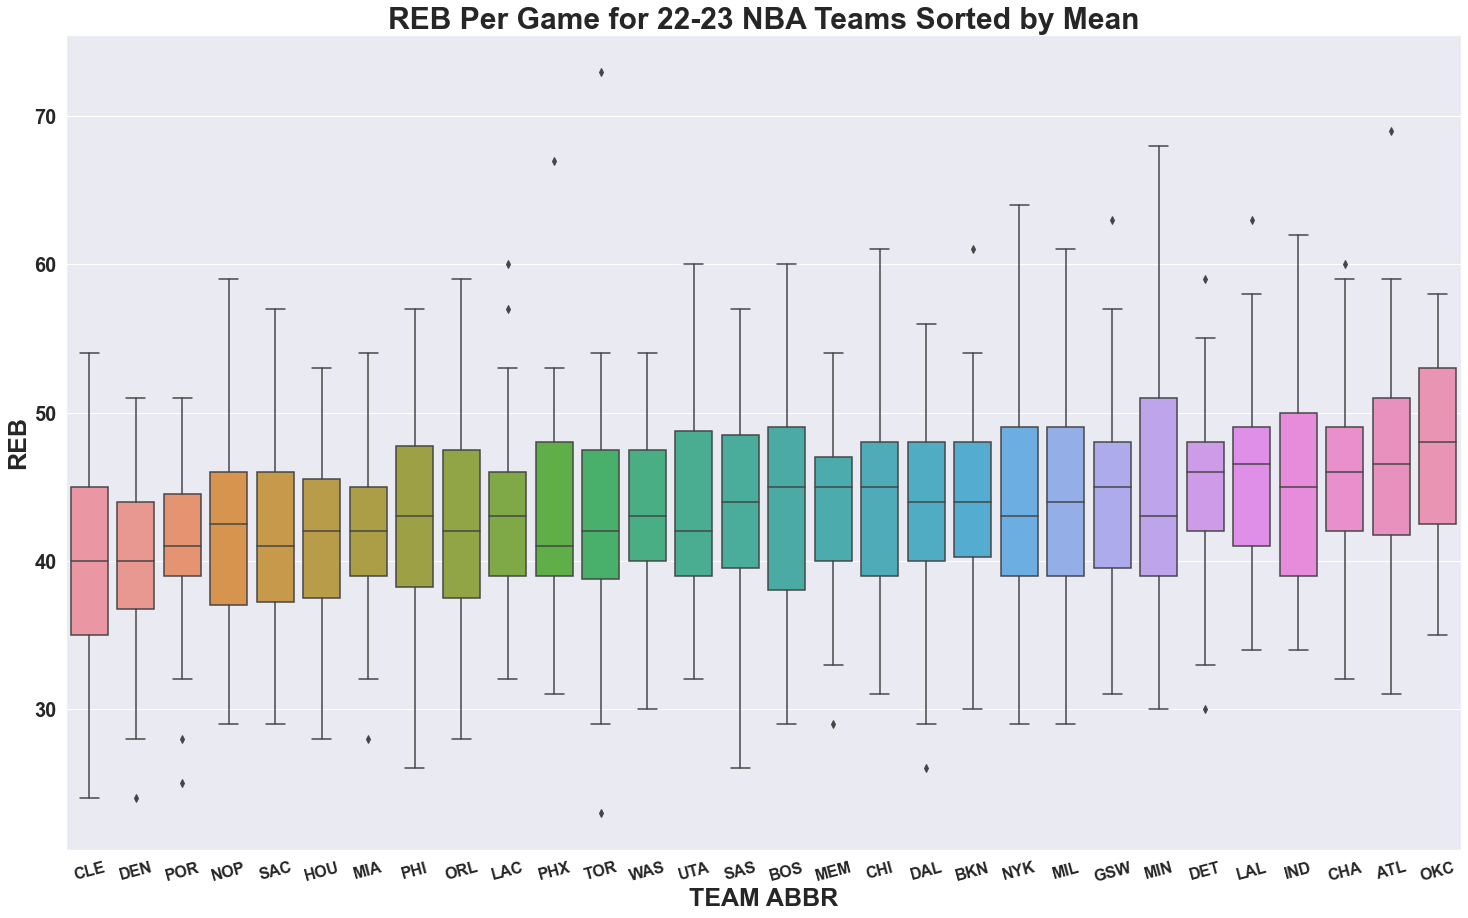

In [45]:
## NBA Stat box plot function
def NBA_stat_boxplots(stat, sort_by='mean', asc=True):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
    
    if sort_by == 'mean':
        if asc==True:
            means_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=[True])
        elif asc==False:
            means_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].mean().sort_values(ascending=[False])  
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=means_ppg.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Mean', fontsize=30, fontweight='bold')

    if sort_by == 'median':
        if asc==True:
            medians_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=[True])
        elif asc==False:
            medians_ppg = df.groupby(['OPP_TEAM_ABBR'])[stat].median().sort_values(ascending=[False])
        sns.boxplot(data=df, x=df.OPP_TEAM_ABBR, y=stat, order=medians_ppg.index)
        ax.set_title(f'{stat} Per Game for 22-23 NBA Teams Sorted by Medians', fontsize=20)

    plt.xticks(rotation=15, fontsize=16, fontweight='bold')
    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    
    plt.xlabel('TEAM ABBR', fontsize=25, fontweight='bold')
    plt.ylabel(stat, fontsize=25, fontweight='bold')

    plt.show()

NBA_stat_boxplots('REB')

## Plus-Minus Plot Function

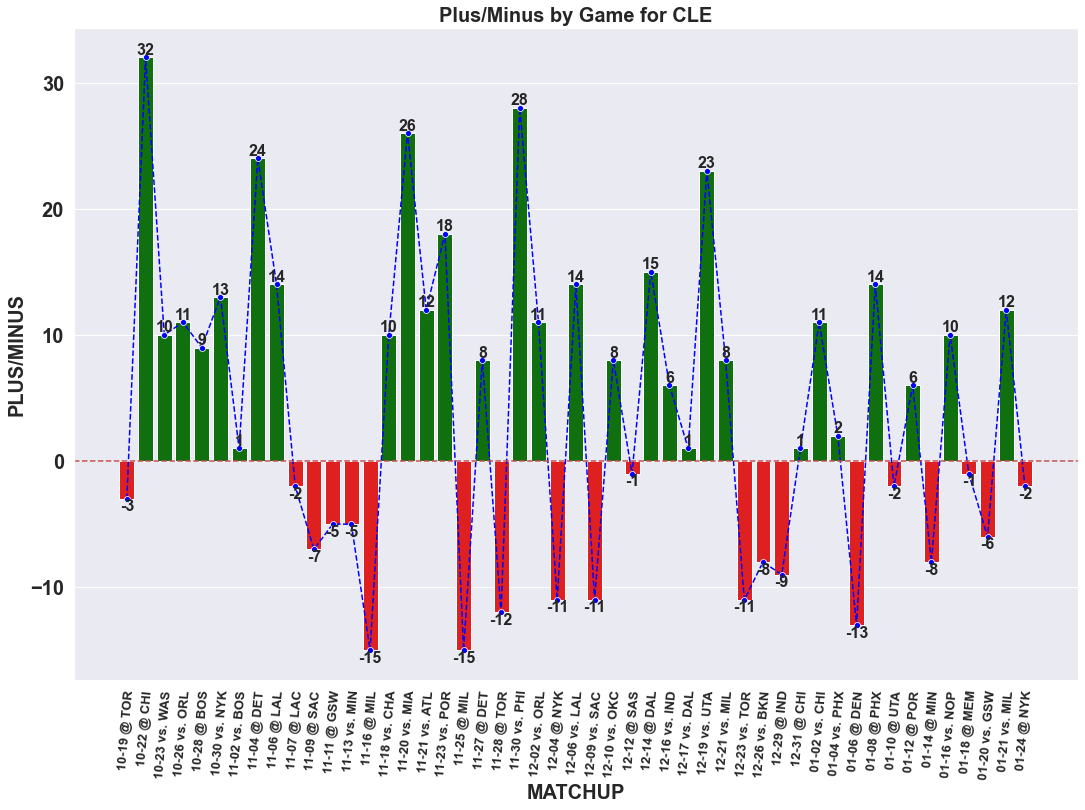

In [46]:
def plus_minus_plot(team_abbr):
    sns.set(rc={'figure.figsize':(18,12)})

    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    values = np.array(df.PLUS_MINUS)
    pal = ['green' if (i > 0) else 'red' for i in values ]
    
    ax1=sns.barplot(data=df, x=df.index, y=values, palette=pal)
    
    ax1.bar_label(ax1.containers[0], fontsize=16, fontweight='bold')
    plt.title(f"Plus/Minus by Game for {team_abbr}", fontsize=20, fontweight='bold')

    ax2=sns.lineplot(data=df, x=df.index, y="PLUS_MINUS",linestyle='--',color='blue', marker='o')
    plt.xticks(rotation=85)
    plt.axhline(y=0, color='r', linestyle='--')

    plt.xticks(df.index,df["DATE_MATCHUP"].values, fontsize=13, fontweight='bold')
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')

    plt.yticks(rotation=0, fontsize=20, fontweight='bold')
    plt.ylabel('PLUS/MINUS', fontsize=20, fontweight='bold')

    plt.show()
    
plus_minus_plot('CLE')

## Scored vs Allowed Violin Plot Function

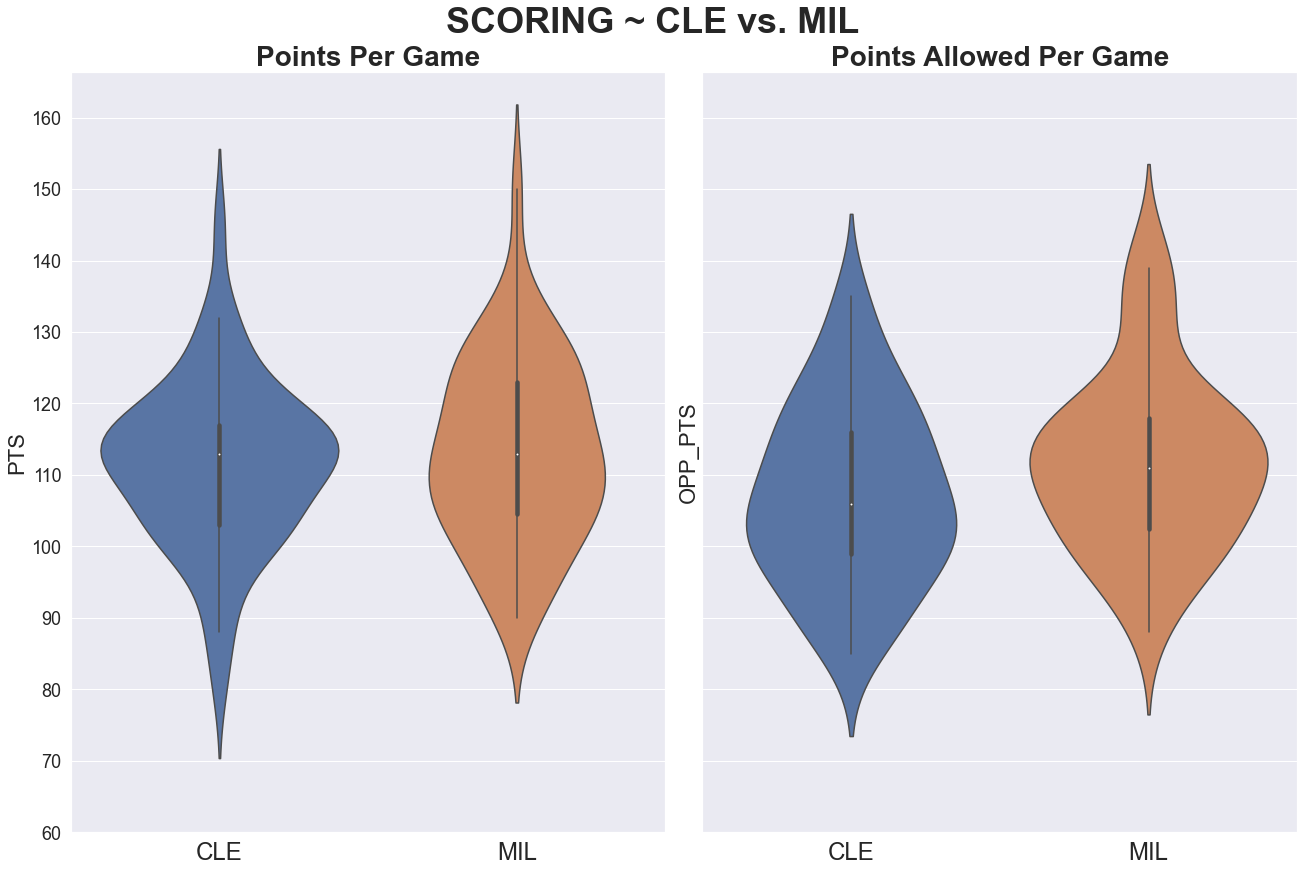

In [47]:
def scored_allowed_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    fig, axs = plt.subplots(ncols=2, sharey=True, constrained_layout=True)
    sns.set(rc={'figure.figsize':(18,12)})

    ax2 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OPP_PTS', ax=axs[1])
    ax2.set_title('Points Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.tick_params(axis='x', which='major', labelsize=24)
    ax2.set_xlabel('')
    ax2.set_ylabel('OPP_PTS', fontsize=22)

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='PTS', ax=axs[0])
    ax1.set_title('Points Per Game', fontsize=28, fontweight='bold')
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)
    ax1.set_ylabel('PTS', fontsize=22)
    ax1.set_xlabel('')

    plt.yticks([60,70,80,90,100,110,120,130,140,150,160])
    fig.suptitle(f'SCORING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=36, fontweight='bold')
    plt.show()
    
scored_allowed_compare("CLE", "MIL")

## Wins vs Losses Pie Charts Function

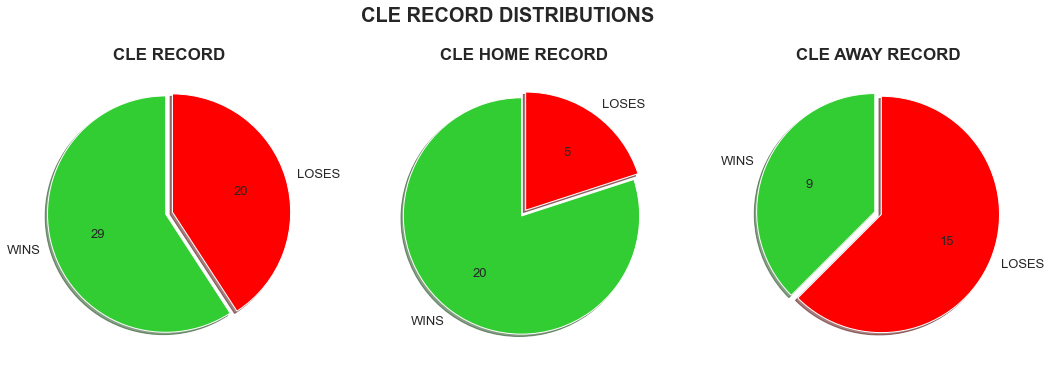

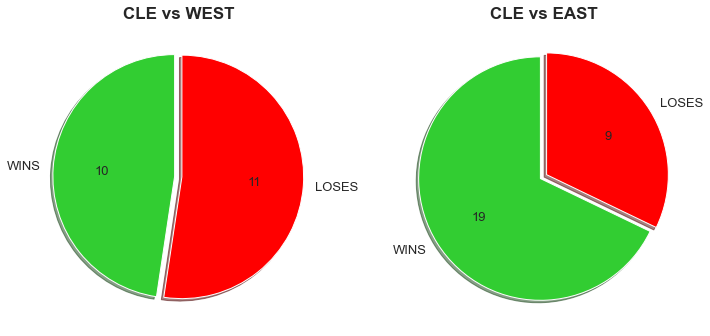

In [48]:
def wl_pies(team_abbr):
    wl_data = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].LOSES.item()])
    wl_data_home = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].HOME_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].HOME_LOSES.item()])
    wl_data_away = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].AWAY_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].AWAY_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl(val):
        a  = np.round(val/100.*wl_data.sum(), 0)
        return int(a)

    def absolute_value_wl_home(val):
        a  = np.round(val/100.*wl_data_home.sum(), 0)
        return int(a)

    def absolute_value_wl_away(val):
        a  = np.round(val/100.*wl_data_away.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))


    ax[0].pie(wl_data,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} RECORD", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_home,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_home,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} HOME RECORD", fontsize= 17, fontweight='bold')

    ax[2].pie(wl_data_away,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_away,
            textprops={'fontsize': 13})
    ax[2].set_title(f"{team_abbr} AWAY RECORD", fontsize= 17, fontweight='bold')

    fig.suptitle(f'{team_abbr} RECORD DISTRIBUTIONS', fontsize=20, fontweight="bold")

    wl_pies_EW(team_abbr)

    plt.show()


def wl_pies_EW(team_abbr):
    wl_data_east = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].EAST_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].EAST_LOSES.item()])
    wl_data_west = np.array([df_records[df_records['TEAM_ABBR']==team_abbr].WEST_WINS.item(), df_records[df_records['TEAM_ABBR']==team_abbr].WEST_LOSES.item()])

    labels = ['WINS','LOSES']
    colors = ['limegreen', 'red']
    explode=[0.03,0.03]

    def absolute_value_wl_east(val):
        a  = np.round(val/100.*wl_data_east.sum(), 0)
        return int(a)

    def absolute_value_wl_west(val):
        a  = np.round(val/100.*wl_data_west.sum(), 0)
        return int(a)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))


    ax[0].pie(wl_data_west,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_west,
            textprops={'fontsize': 13})
    ax[0].set_title(f"{team_abbr} vs WEST", fontsize= 17, fontweight='bold')

    ax[1].pie(wl_data_east,
            labels=labels,
            explode=explode,
            startangle = 90,
            colors=colors,
            shadow = True,
            autopct=absolute_value_wl_east,
            textprops={'fontsize': 13})
    ax[1].set_title(f"{team_abbr} vs EAST", fontsize= 17, fontweight='bold')

    plt.show()
    
wl_pies("CLE")

## Multi Team Violin Plot Comparsion Function

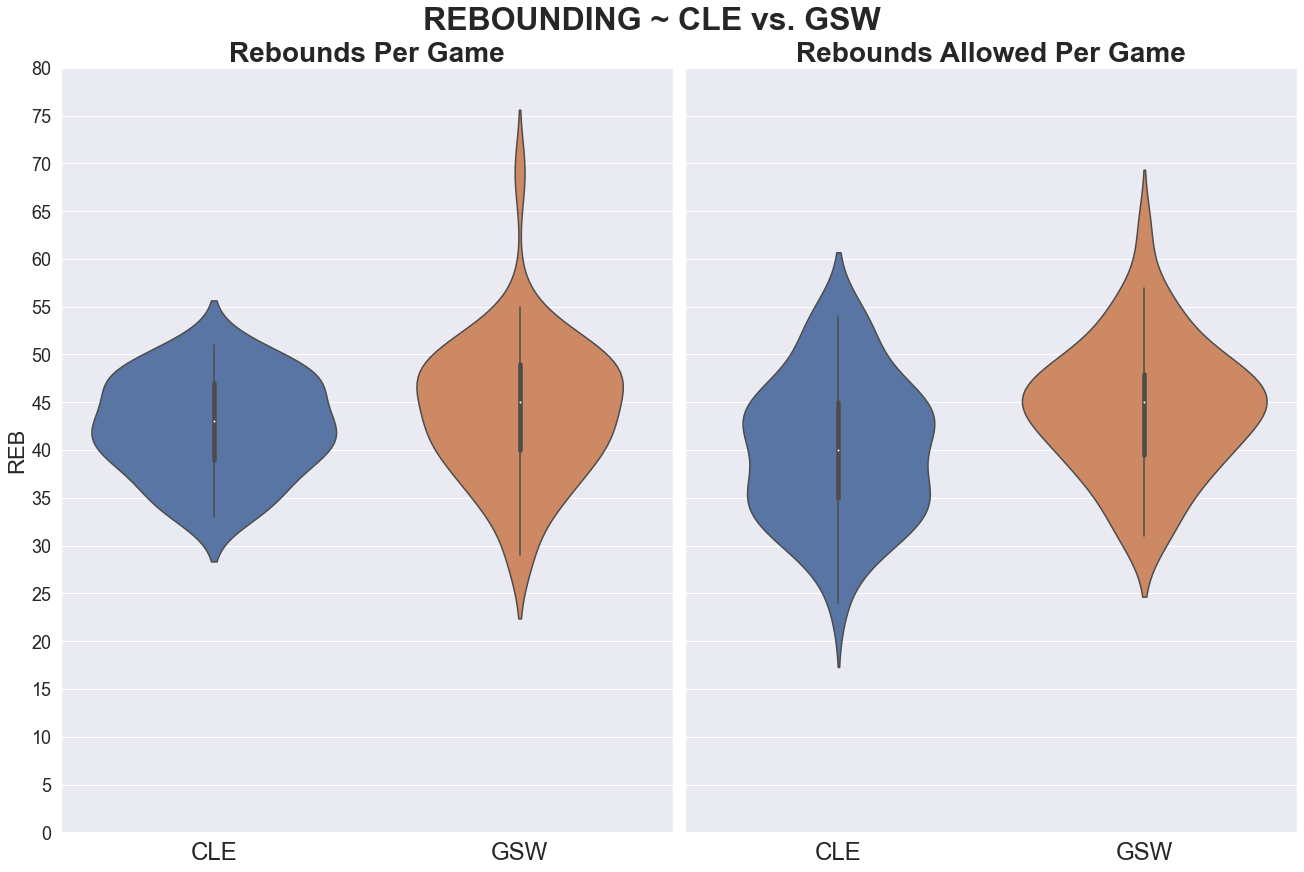

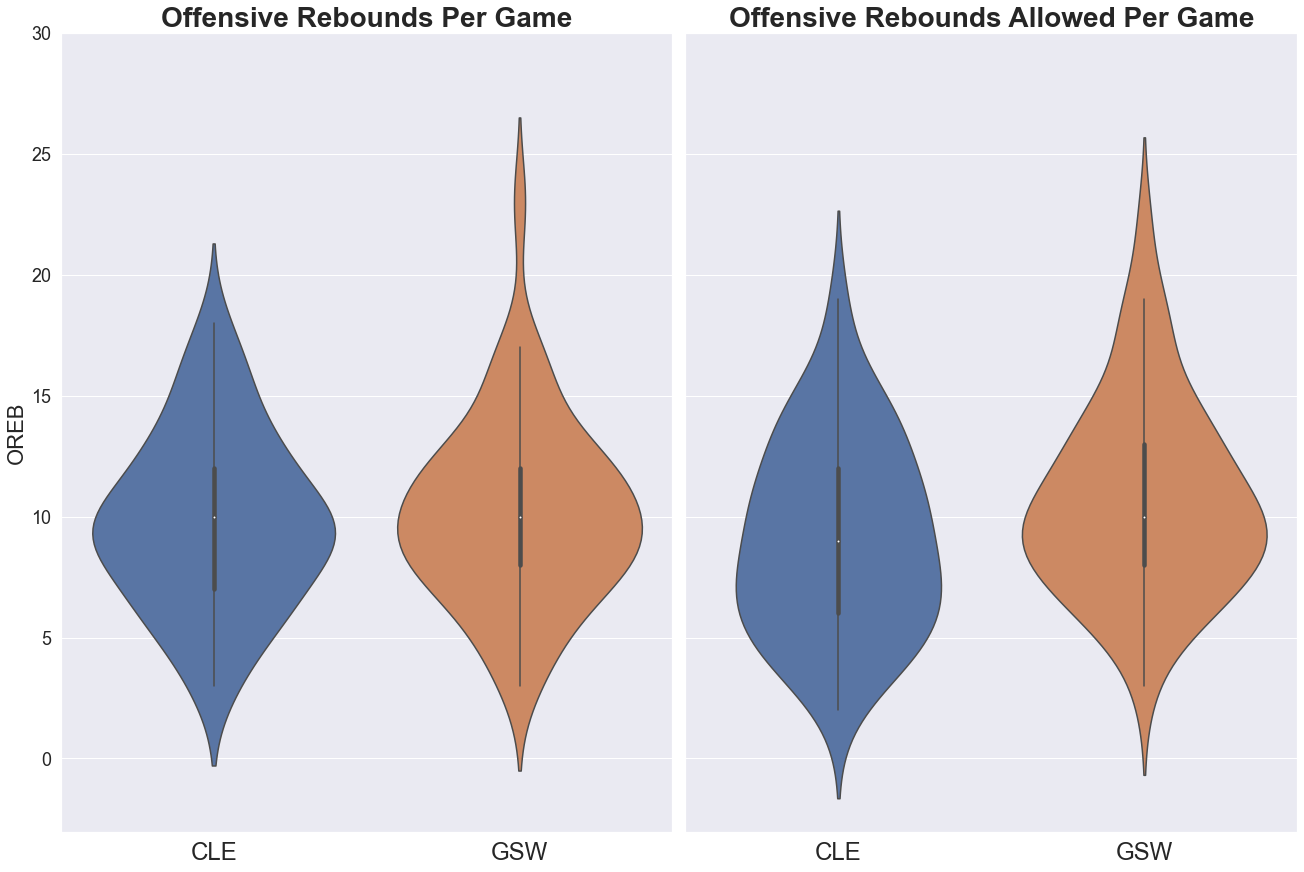

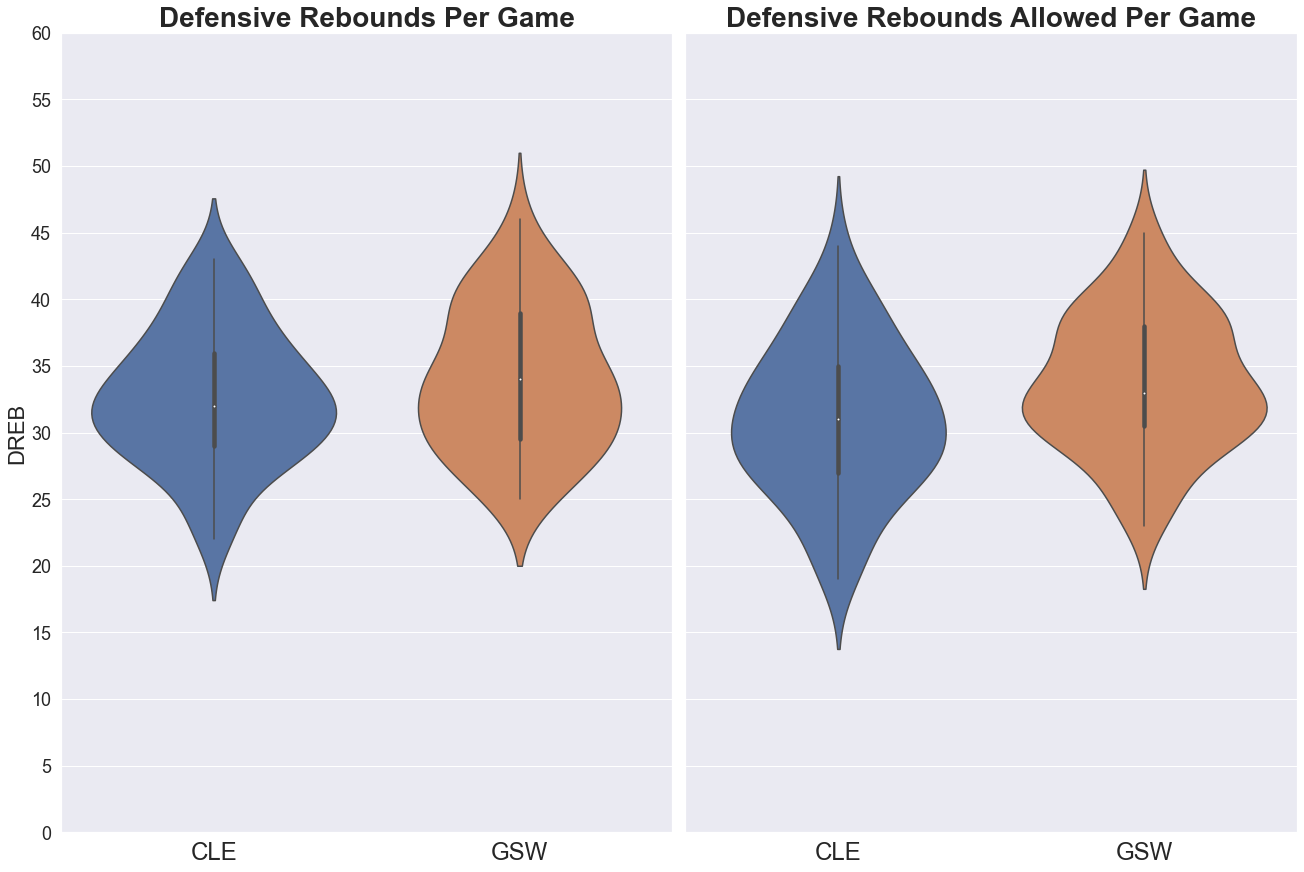

In [49]:
def rebounds_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='REB', ax=axs[0])
    ax1.set_title(f'Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('REB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='REB', ax=axs[1])
    ax2.set_title(f'Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40, 45, 50, 55, 60, 65, 70, 75, 80])

    fig.suptitle(f'REBOUNDING ~ {team_a_abbr} vs. {team_b_abbr}', fontsize=32, fontweight='extra bold')
    plt.show()

    print()
    oreb_compare(team_a_abbr,team_b_abbr)
    print()
    dreb_compare(team_a_abbr,team_b_abbr)
    print()

    # ADD REBOUNDING DIFFERENTIALS

def oreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='OREB', ax=axs[0])
    ax1.set_title(f'Offensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('OREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='OREB', ax=axs[1])
    ax2.set_title(f'Offensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30])

    plt.show()

def dreb_compare(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])

    df_a_def = df[df.OPP_TEAM_ABBR== team_a_abbr]
    df_b_def = df[df.OPP_TEAM_ABBR== team_b_abbr]
    df_def_merged = pd.concat([df_a_def, df_b_def])

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex='col',constrained_layout=True, sharey=True)

    sns.set(rc={'figure.figsize':(18,12)})

    ax1 = sns.violinplot(data=df_merged, x=df_merged.TEAM_ABBREVIATION, y='DREB', ax=axs[0])
    ax1.set_title(f'Defensive Rebounds Per Game', fontsize=28, fontweight='bold')
    ax1.set_xlabel('')
    ax1.set_ylabel('DREB', fontsize=22)
    ax1.tick_params(axis='x', which='major', labelsize=24)
    ax1.tick_params(axis='y', which='major', labelsize=18)

    ax2 = sns.violinplot(data=df_def_merged, x=df_def_merged.OPP_TEAM_ABBR, y='DREB', ax=axs[1])
    ax2.set_title(f'Defensive Rebounds Allowed Per Game', fontsize=28, fontweight='bold')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.tick_params(axis='x', which='major', labelsize=24)

    plt.yticks([0,5,10,15,20,25,30,35,40,45,50,55,60])

    plt.show()
    
rebounds_compare('CLE','GSW')

## Team Scoring Line Plot Function

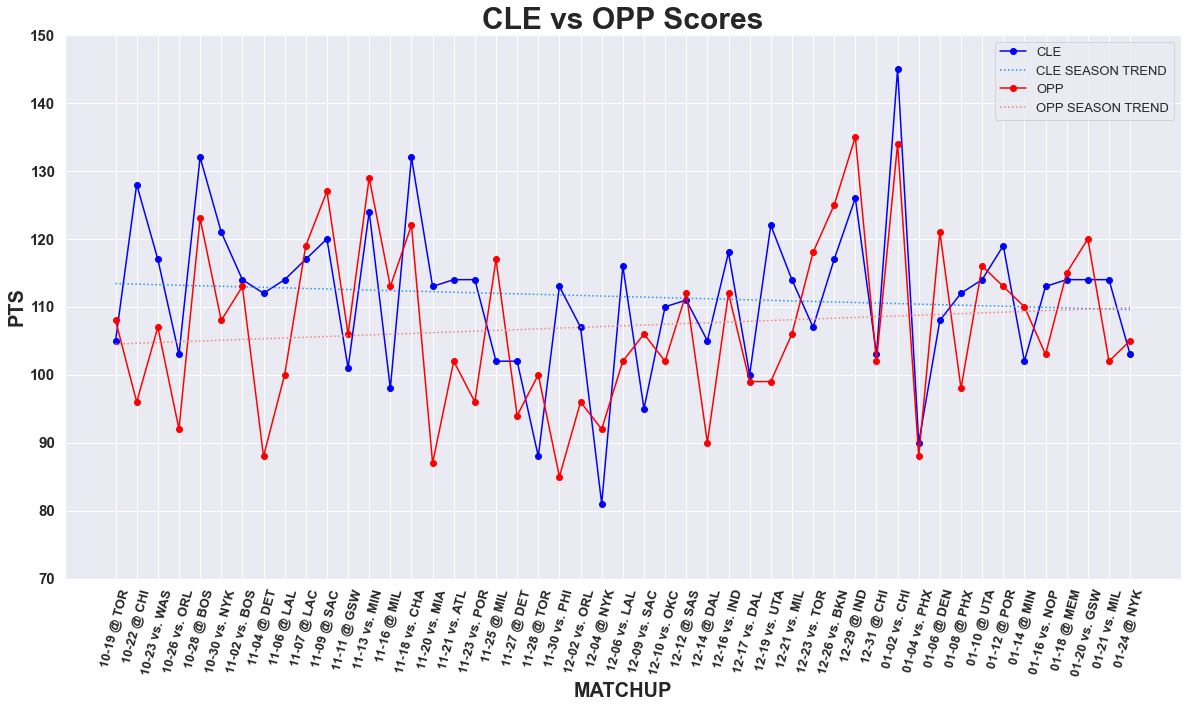

In [50]:
def line_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    team_score = plt.plot(df.index, df['PTS'], marker='o', label=team_abbr, color='blue')
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=1.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    opp_score = plt.plot(df.index, df['OPP_PTS'], marker='o', label='OPP', color='red')
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=1.5, color='salmon', label='OPP SEASON TREND')
    
    plt.legend(loc='best', fontsize=13)
    plt.title(f'{team_abbr} vs OPP Scores',fontsize=30, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15, fontweight='bold')
    plt.ylim(70, 150)
    plt.xlabel('MATCHUP',fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
line_plot_scores("CLE")

## Trend Plot Scores Function

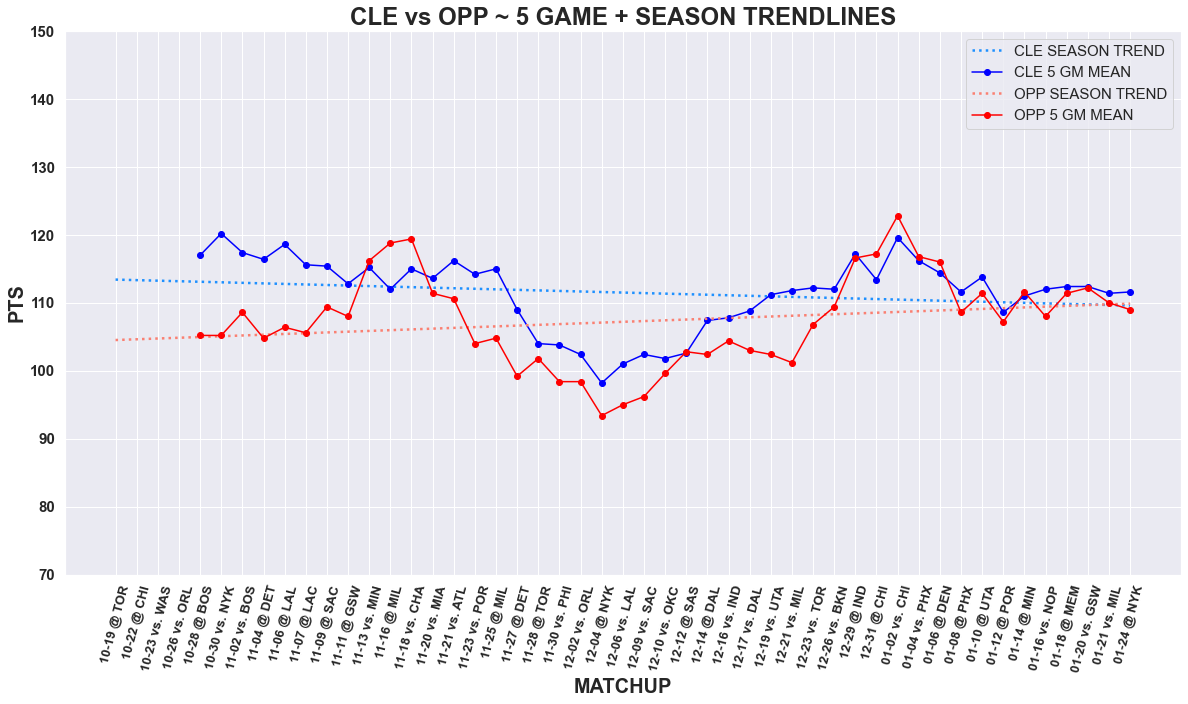

In [51]:
def trend_plot_scores(team_abbr):
    plt.rcParams["figure.figsize"] = (20,10)
    df = get_team_df(team_abbr).sort_values(by='GAME_DATE').reset_index(drop=True)
    
    z = np.polyfit(df.index, df['PTS'], 1)
    p = np.poly1d(z)
    team_trend = plt.plot(df.index,p(df.index), linestyle='dotted',linewidth=2.5, color='dodgerblue', label=f'{team_abbr} SEASON TREND')
    
    rolling_mean = df.PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="BLUE", alpha=1,marker='o', label=f"{team_abbr} 5 GM MEAN")
    
    z = np.polyfit(df.index, df['OPP_PTS'], 1)
    p = np.poly1d(z)
    opp_trend = plt.plot(df.index,p(df.index),linestyle='dotted',linewidth=2.5, color='salmon', label='OPP SEASON TREND')
    
    rolling_mean = df.OPP_PTS.rolling(5).mean()
    rolling_mean_plot = plt.plot(rolling_mean, color="RED", alpha=1,marker='o', label=f"OPP 5 GM MEAN")
    
    plt.legend(loc='best', fontsize=15)
    plt.title(f'{team_abbr} vs OPP ~ 5 GAME + SEASON TRENDLINES',fontsize=24, fontweight='bold')
    plt.xticks(df.index,df["DATE_MATCHUP"].values)
    plt.xticks(rotation=75, fontsize=13, fontweight='bold')
    plt.yticks(list(range(0,160,10)), fontsize=15,  fontweight='bold')
    plt.ylim(70, 150)
    
    plt.xlabel('MATCHUP', fontsize=20, fontweight='bold')
    plt.ylabel('PTS', fontsize=20, fontweight='bold')
    plt.show()
    
trend_plot_scores("CLE")

## Shooting Distribution Pie Chart Function

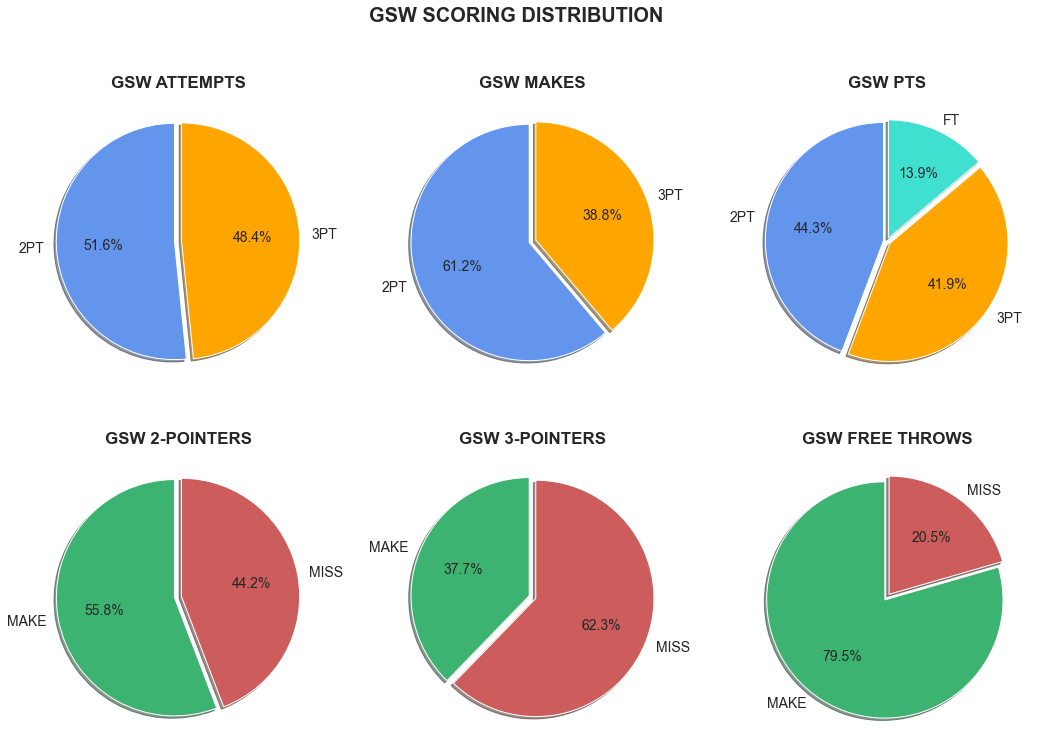

In [52]:
def shot_pies(team_abbr):
    
    df_team = df_team_avg[df_team_avg['TEAM_ABBR']==team_abbr]
    
    data_att = [df_team.FRAC_ATT_2PT.item(), df_team.FRAC_ATT_3PT.item()]
    data_mk = [df_team.FRAC_MK_2PT.item(), df_team.FRAC_MK_3PT.item()]
    data_pts = [df_team.FRAC_PTS_2PT.item(), df_team.FRAC_PTS_3PT.item(), df_team.FRAC_PTS_FT.item()]
    
    data_2pt = [df_team.FG2M.item(), (df_team.FG2A.item() - df_team.FG2M.item())]
    data_3pt = [df_team.FG3M.item(), (df_team.FG3A.item() - df_team.FG3M.item())]
    data_ft = [df_team.FTM.item(), (df_team.FTA.item() - df_team.FTM.item())]
    
    labels1 = ['2PT', '3PT']
    labels2 = ['2PT', '3PT', 'FT']
    labels3 = ['MAKE', 'MISS']
    explode1 = [0.03, 0.03]
    explode2 = [0.03,0.03,0.03]
    colors0 = ['cornflowerblue', 'orange']
    colors1= ['cornflowerblue', 'orange', 'turquoise']
    colors2 = ['mediumseagreen','indianred']
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
    
    ax[0,0].pie(data_att,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,0].set_title(f'{team_abbr} ATTEMPTS', fontsize=17, fontweight='bold')
    
    ax[0,1].pie(data_mk,
              labels=labels1,
              explode=explode1,
              shadow=True,
              colors=colors0,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,1].set_title(f'{team_abbr} MAKES', fontsize=17, fontweight='bold')
    
    ax[0,2].pie(data_pts,
              labels=labels2,
              explode=explode2,
              shadow=True,
              colors=colors1,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[0,2].set_title(f'{team_abbr} PTS', fontsize=17, fontweight='bold')
    
    ax[1,0].pie(data_2pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,0].set_title(f'{team_abbr} 2-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,1].pie(data_3pt,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,1].set_title(f'{team_abbr} 3-POINTERS', fontsize=17, fontweight='bold')
    
    ax[1,2].pie(data_ft,
              labels=labels3,
              explode=explode1,
              colors=colors2,
              shadow=True,
              autopct='%1.1f%%',
              textprops={'fontsize': 14},
              startangle=90)
    ax[1,2].set_title(f'{team_abbr} FREE THROWS', fontsize=17, fontweight='bold')
    
    fig.suptitle(f'{team_abbr} SCORING DISTRIBUTION', fontsize=20, fontweight="bold")
    plt.show()
    
shot_pies('GSW')

# Regrssion Analysis Plots ~ League Trends

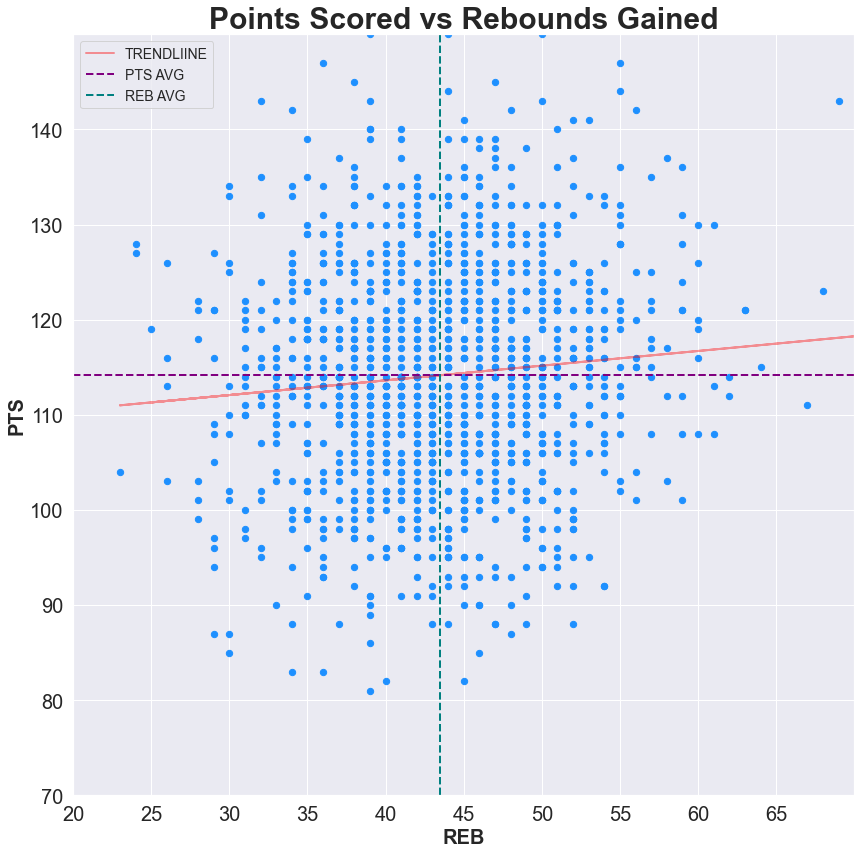

Season Trend Line Equation
y=0.154449x+(107.439200)

R-squared: 0.00801262098914346

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.4900
Date:                Wed, 25 Jan 2023   Prob (F-statistic):              0.489
Time:                        10:27:28   Log-Likelihood:                -73.437
No. Observations:                  31   AIC:                             150.9
Df Residuals:                      29   BIC:                             153.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

In [53]:
plt.rcParams["figure.figsize"] = (14,14)

x=df.REB
y=df.PTS

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.4, color='red', linewidth=2)

plt.scatter(x,y, color='dodgerblue', s=40)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.REB.mean(), label="REB AVG", linestyle='dashed', color='teal', linewidth=2)

plt.xlim(20,70)
plt.xticks(list(range(20,70,5)), fontsize=20)
plt.xlabel('REB', fontsize=20, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20)
plt.ylabel('PTS', fontsize=20, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Rebounds Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' +color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ REB', data=df_team_avg).fit()
print()
print(lm.summary())

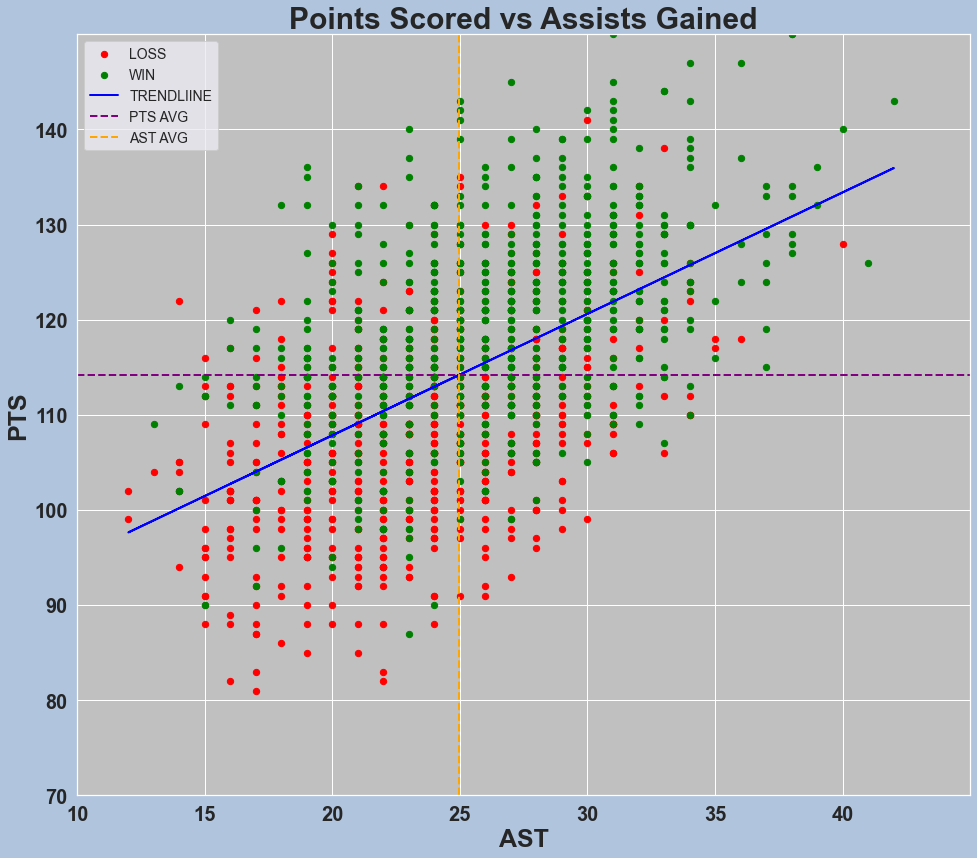

Season Trend Line Equation
y=1.276457x+(82.317070)

R-squared: 0.2883889331313032

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     19.06
Date:                Wed, 25 Jan 2023   Prob (F-statistic):           0.000147
Time:                        10:27:29   Log-Likelihood:                -65.866
No. Observations:                  31   AIC:                             135.7
Df Residuals:                      29   BIC:                             138.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
ax.set_facecolor('silver')
fig.set_facecolor('lightsteelblue')
fig.set_edgecolor('black')

x=df.AST
y=df.PTS

x_L=df[df.WL=='L'].AST
y_L=df[df.WL=='L'].PTS

x_W=df[df.WL=='W'].AST
y_W=df[df.WL=='W'].PTS

plt.scatter(x_L,y_L, color='red', label='LOSS', s=40)
plt.scatter(x_W,y_W, color='green', label='WIN', s=40)

# calc the trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=1, color='blue', linewidth=2)

plt.axhline(df.PTS.mean(), label="PTS AVG", linestyle='dashed', color='purple', linewidth=2)
plt.axvline(df.AST.mean(), label="AST AVG", linestyle='dashed', color='orange', linewidth=2)

plt.xlim(10,45)
plt.xticks(list(range(10,45,5)), fontsize=20, fontweight='bold')
plt.xlabel('AST', fontsize=25, fontweight='bold')

plt.ylim(70, 150)
plt.yticks(list(range(70,150,10)), fontsize=20, fontweight='bold')
plt.ylabel('PTS', fontsize=25, fontweight='bold')

plt.legend(loc='best', fontsize=14)

plt.title('Points Scored vs Assists Gained', fontsize=30, fontweight='bold')

plt.show()

print(color.BOLD +'Season Trend Line Equation' + color.END)
print("y=%.6fx+(%.6f)"%(z[0],z[1]))

# Calc R-squared
model = LinearRegression()
model.fit(x.values.reshape(-1, 1), y)
r_squared = model.score(x.values.reshape(-1, 1), y)
print()
print(color.BOLD + "R-squared: "+ color.END + str(r_squared))

lm = smf.ols(formula = 'PTS ~ AST', data=df_team_avg).fit()
print()
print(lm.summary())

## Team Average Reression (statx vs staty) Plot and Analysis Function

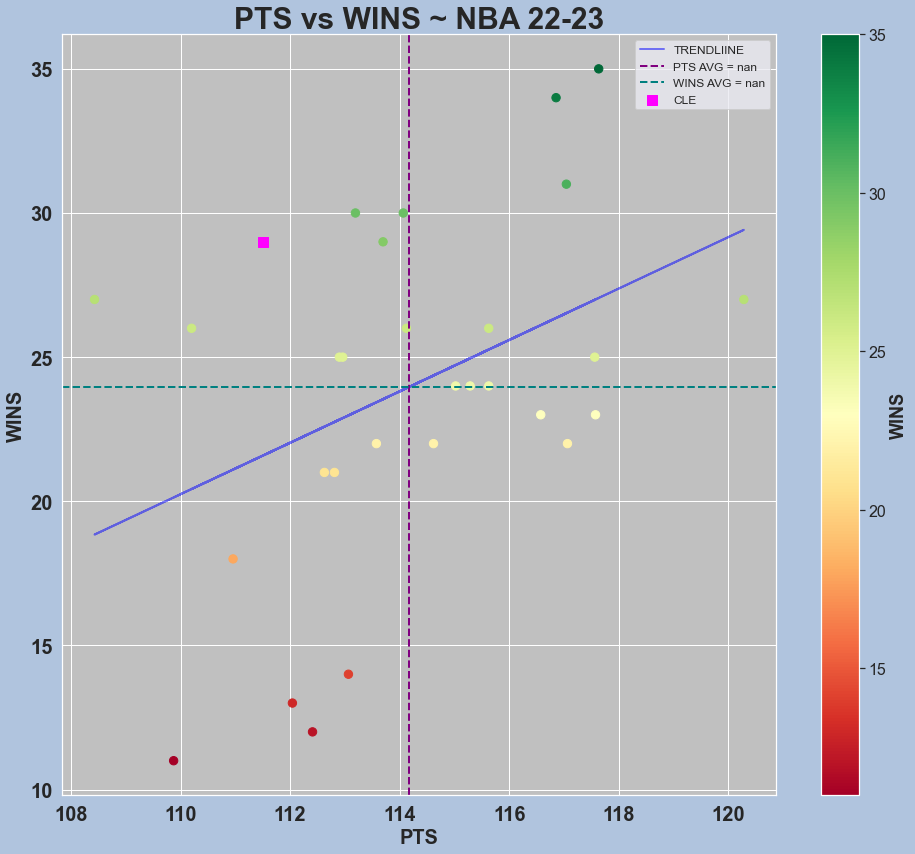


Season Trend Line Equation: y = 0.891777x + (-77.849848)

R-squared: 0.1632158306937157


                            OLS Regression Results                            
Dep. Variable:                   WINS   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     5.461
Date:                Wed, 25 Jan 2023   Prob (F-statistic):             0.0268
Time:                        10:52:20   Log-Likelihood:                -92.893
No. Observations:                  30   AIC:                             189.8
Df Residuals:                      28   BIC:                             192.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [82]:
# Add ability to specify other dataframes

def regression_analysis_team_avg(statx, staty, team_abbr=''):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 14))
    
    ax.set_facecolor('silver')
    fig.set_facecolor('lightsteelblue')
    fig.set_edgecolor('black')
    
    df_new = df_team_master.copy()

    x=df_new[statx]
    y=df_new[staty]

    # Calc the season trendline
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x,p(x), label='TRENDLIINE', linestyle = 'solid', alpha=0.5, color='blue', linewidth=2)

    plt.scatter(x,y, c=y, cmap='RdYlGn', s=70)

    plt.axvline(x.mean(), label=f"{statx} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][statx].mean(),2)}", linestyle='dashed', color='purple', linewidth=2)
    plt.axhline(y.mean(), label=f"{staty} AVG = {round(df_new[df_new['TEAM_ABBR']=='NBA'][staty].mean(),2)}", linestyle='dashed', color='teal', linewidth=2)

    plt.xlabel(statx, fontsize=20, fontweight='bold')
    plt.ylabel(staty, fontsize=20, fontweight='bold')

    plt.title(f'{statx} vs {staty} ~ NBA 22-23', fontsize=30, fontweight='bold')
    plt.xticks(fontsize=20, fontweight='bold')
    plt.yticks(fontsize=20, fontweight='bold')
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(label=staty, size=18, weight='bold')
    
    if team_abbr != '':
        try:
            x_team = df_new[df_new.TEAM_ABBR == team_abbr][statx]
            y_team = df_new[df_new.TEAM_ABBR == team_abbr][staty]
            plt.scatter(x_team,y_team, color='magenta', marker='s', s=100, label=team_abbr)
        except: pass
    
    plt.legend(loc='best', fontsize=12)
    
    plt.show()

    print()
    print(color.BOLD +'Season Trend Line Equation: ' + color.END + "y = %.6fx + (%.6f)"%(z[0],z[1]))

    # Calc R-squared
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y)
    r_squared = model.score(x.values.reshape(-1, 1), y)
    print()
    print(color.BOLD + "R-squared: "+ color.END + str(r_squared))
    print()

    lm = smf.ols(formula = f'{staty} ~ {statx}', data=df_new).fit()
    print()
    print(lm.summary())

regression_analysis_team_avg('PTS', 'WINS', team_abbr='CLE')

## Function to return DF with R2 for a specified stat

In [58]:
def r2_comparison_from_y(df, staty):
    
    pd.set_option('display.max_rows', None)
    
    df_new = df.copy()
    
    try: df_new = df_new.drop(columns=['TEAM_NAME'])
    except: pass
    try: df_new = df_new.drop(columns=['TEAM_ABBR'])
    except: pass
    
    df_out = pd.DataFrame(columns=['x','y','r2'])
    
    y=df_new[staty]
    y=y.fillna(y.mean())
    
    for i in df_new.columns:
        x=df_new[i]
        try: x=x.fillna(x.mean())
        except: x=x.fillna(0)
        if is_numeric_dtype(df_new[i]):
            model = LinearRegression()
            model = model.fit(x.values.reshape(-1, 1), y)
            r2= model.score(x.values.reshape(-1, 1), y)
            df_temp = pd.DataFrame([[i, staty, r2]], columns=['x','y','r2'])
            df_out = df_out.append(df_temp)
        
    df_out = df_out.sort_values(by=['r2'],ascending=False).reset_index(drop=True)
    return df_out

r2_comparison_from_y(df_team_master, 'WINS')

x     y         r2
0                          WINS  WINS          1
1                       WIN_PER  WINS    0.98896
2                         LOSES  WINS    0.96243
3                OPP_PLUS_MINUS  WINS    0.88769
4                    PLUS_MINUS  WINS    0.88769
5                    HOME_LOSES  WINS    0.78326
6                     HOME_WINS  WINS    0.76207
7                    AWAY_LOSES  WINS    0.67731
8                     AWAY_WINS  WINS    0.59478
9                 LAST_10_LOSES  WINS    0.53307
10                 LAST_10_WINS  WINS    0.53307
11                      OPP_PTS  WINS    0.49913
12                    EAST_WINS  WINS    0.43771
13                   Dunks %FGA  WINS    0.40609
14                   EAST_LOSES  WINS    0.39171
15                   WEST_LOSES  WINS    0.38864
16                    Dunks Md.  WINS    0.37379
17                      OPP_BLK  WINS    0.36509
18                      FG3_PCT  WINS    0.35197
19                    WEST_WINS  WINS    0.32534
20                   OPP_FG_PCT  WINS    0.32516
21                          FG%  WINS    0.32144
22           FG% by Distance 2P  WINS    0.31691
23                    OPP_MONTH  WINS    0.30358
24                      OPP_AST  WINS    0.28164
25                      OPP_FGM  WINS    0.27312
26                  OPP_FG3_PTS  WINS    0.26475
27                     OPP_FG3M  WINS    0.26475
28                       FG_PCT  WINS    0.21614
29   % of FGA by Distance 10-16  WINS    0.20449
30           FG% by Distance 3P  WINS    0.18528
31         FG% by Distance 3-10  WINS    0.17905
32                  OPP_OPP_PTS  WINS    0.16322
33                          PTS  WINS    0.16322
34                      FG3_PTS  WINS    0.16163
35                         FG3M  WINS    0.16163
36                  OPP_FG3_PCT  WINS    0.15691
37                      TEAM_ID  WINS    0.15571
38                           PF  WINS    0.12921
39                 FRAC_PTS_3PT  WINS    0.12723
40                          AST  WINS    0.12476
41                      OPP_FTM  WINS     0.1209
42   % of FGA by Distance 16-3P  WINS    0.11422
43                  FRAC_MK_3PT  WINS     0.1054
44                  FRAC_MK_2PT  WINS     0.1054
45                         DREB  WINS    0.10335
46                         FG2A  WINS    0.10196
47                      OPP_FTA  WINS   0.098396
48                     OPP_FG3A  WINS   0.097573
49                         OREB  WINS   0.089368
50                  FRAC_PTS_FT  WINS   0.082125
51                 FRAC_ATT_3PT  WINS   0.076626
52                 FRAC_ATT_2PT  WINS   0.076626
53                      OPP_REB  WINS     0.0757
54                   Corner 3P%  WINS   0.074109
55                 FRAC_PTS_2PT  WINS   0.070888
56      % of FGA by Distance 3P  WINS   0.066922
57      % of FGA by Distance 2P  WINS   0.066922
58                          FGM  WINS   0.064331
59                          FTA  WINS   0.064047
60             OPP_FRAC_ATT_3PT  WINS   0.063572
61             OPP_FRAC_ATT_2PT  WINS   0.063572
62                      OPP_STL  WINS   0.061475
63                     OPP_DREB  WINS   0.059461
64        FG% by Distance 10-16  WINS   0.058042
65                          TOV  WINS   0.052277
66                          FGA  WINS   0.050232
67                       FT_PCT  WINS   0.049753
68                         FG3A  WINS   0.047872
69             OPP_FRAC_PTS_2PT  WINS   0.047744
70                     OPP_FG2M  WINS   0.045718
71                  OPP_FG2_PTS  WINS   0.045718
72                          BLK  WINS   0.044513
73        FG% by Distance 16-3P  WINS   0.042974
74              OPP_FRAC_MK_2PT  WINS   0.042579
75              OPP_FRAC_MK_3PT  WINS   0.042579
76          FG% by Distance 0-3  WINS   0.040705
77                       OPP_PF  WINS    0.03939
78                     OPP_OREB  WINS   0.038947
79             OPP_FRAC_PTS_3PT  WINS   0.038731
80                   OPP_FT_PCT  WINS   0.035625
81          

# Team Report Function

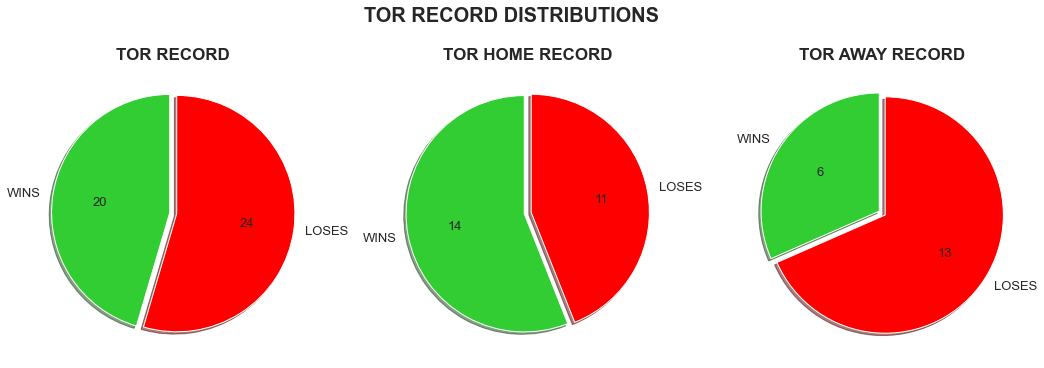

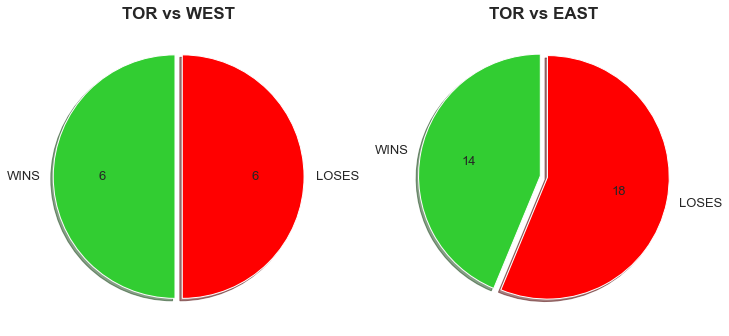

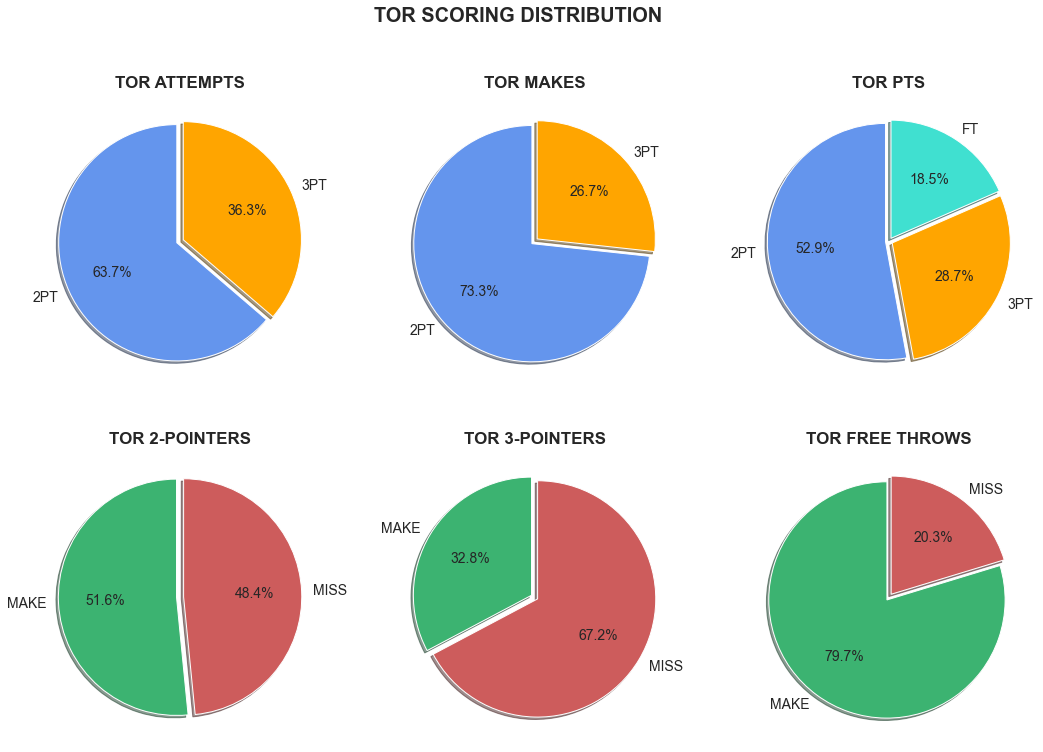

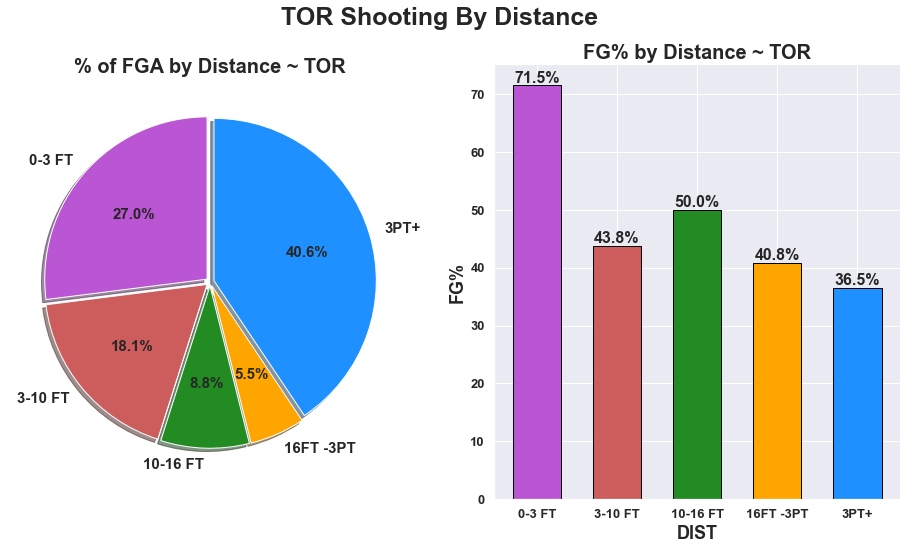

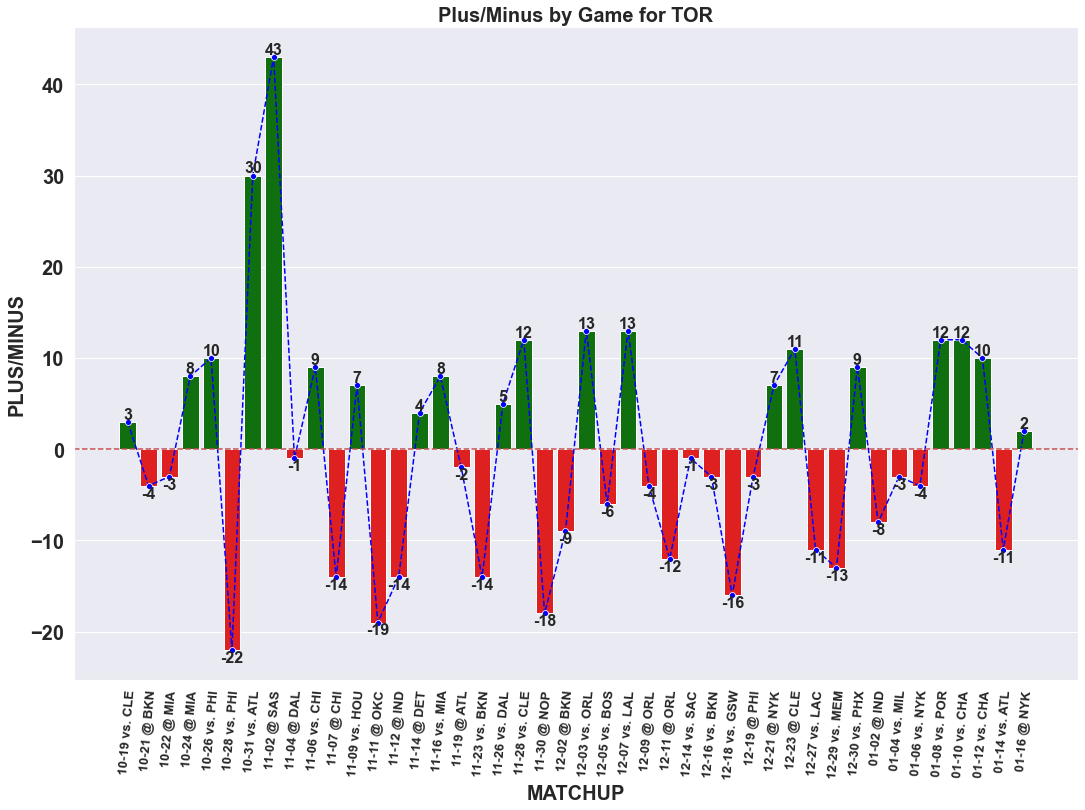

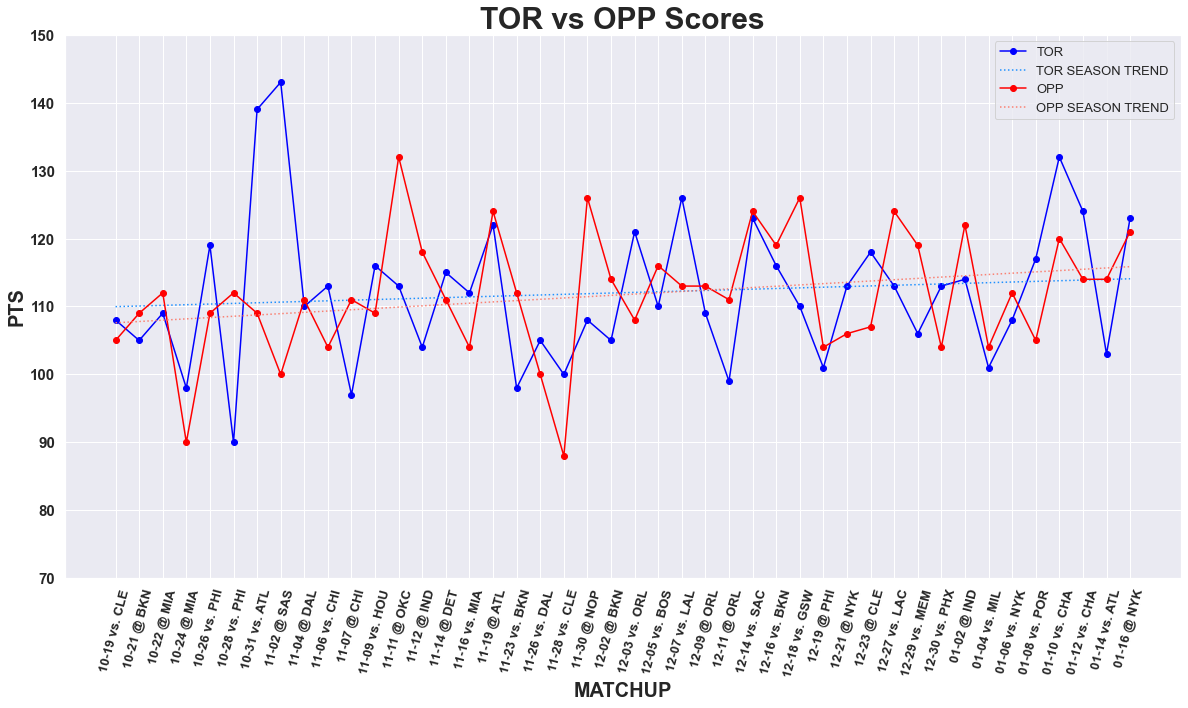

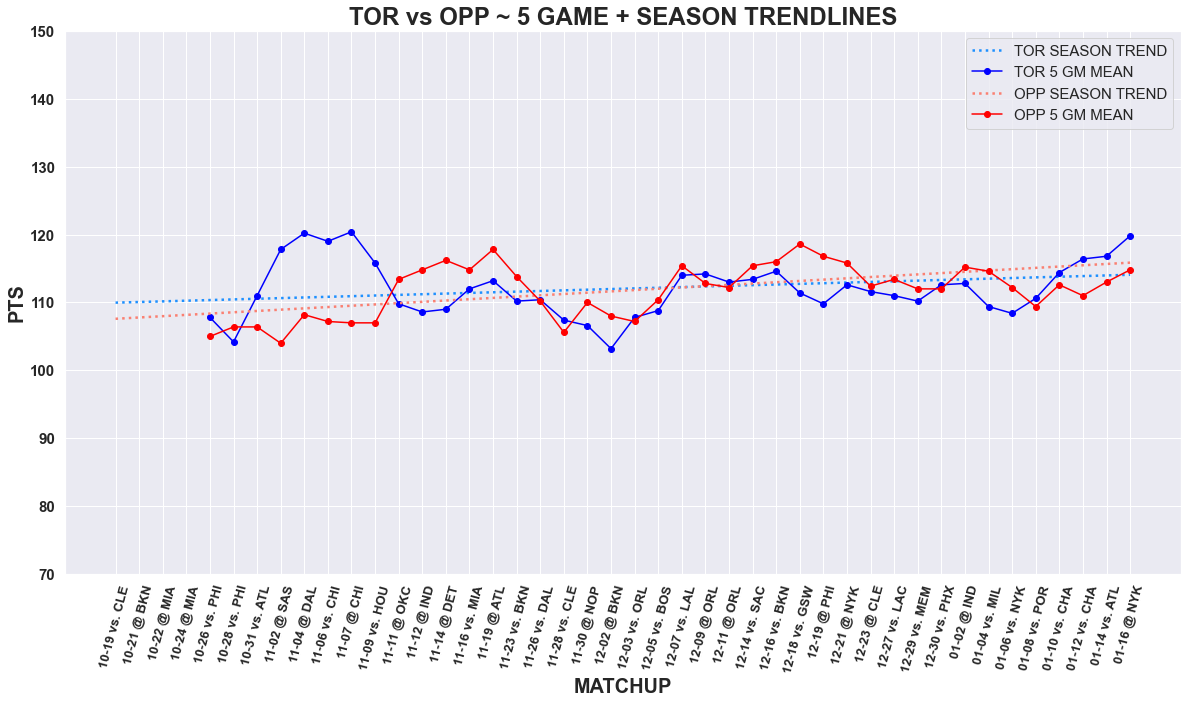

In [33]:
#NBA TEAM REPORT

def team_report(team_abbr):
    wl_pies(team_abbr)
    shot_pies(team_abbr)
    team_fg_by_dist(team_abbr)
    plus_minus_plot(team_abbr)
    line_plot_scores(team_abbr)
    trend_plot_scores(team_abbr)
    
team_report("TOR")

# 2-Team Comparison Function

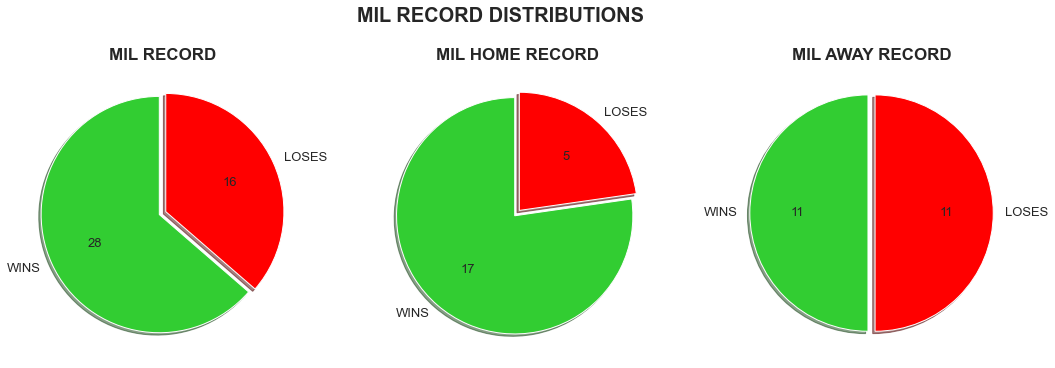

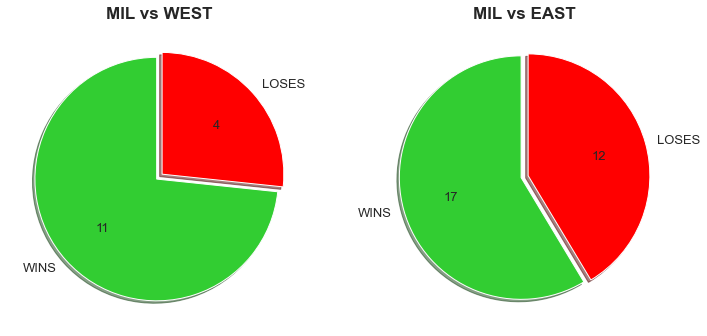

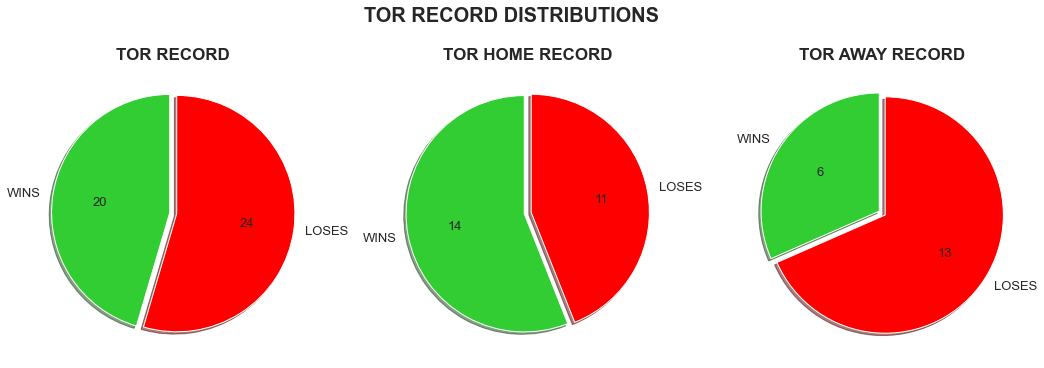

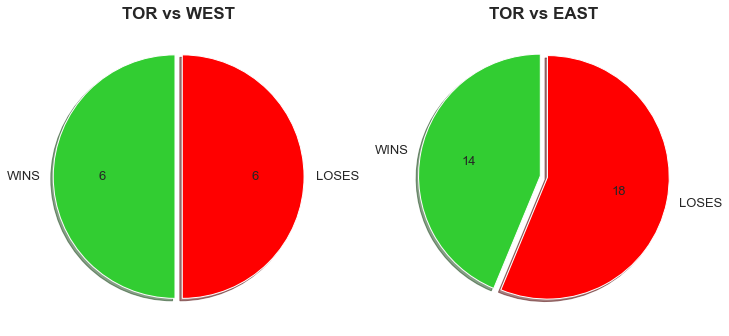

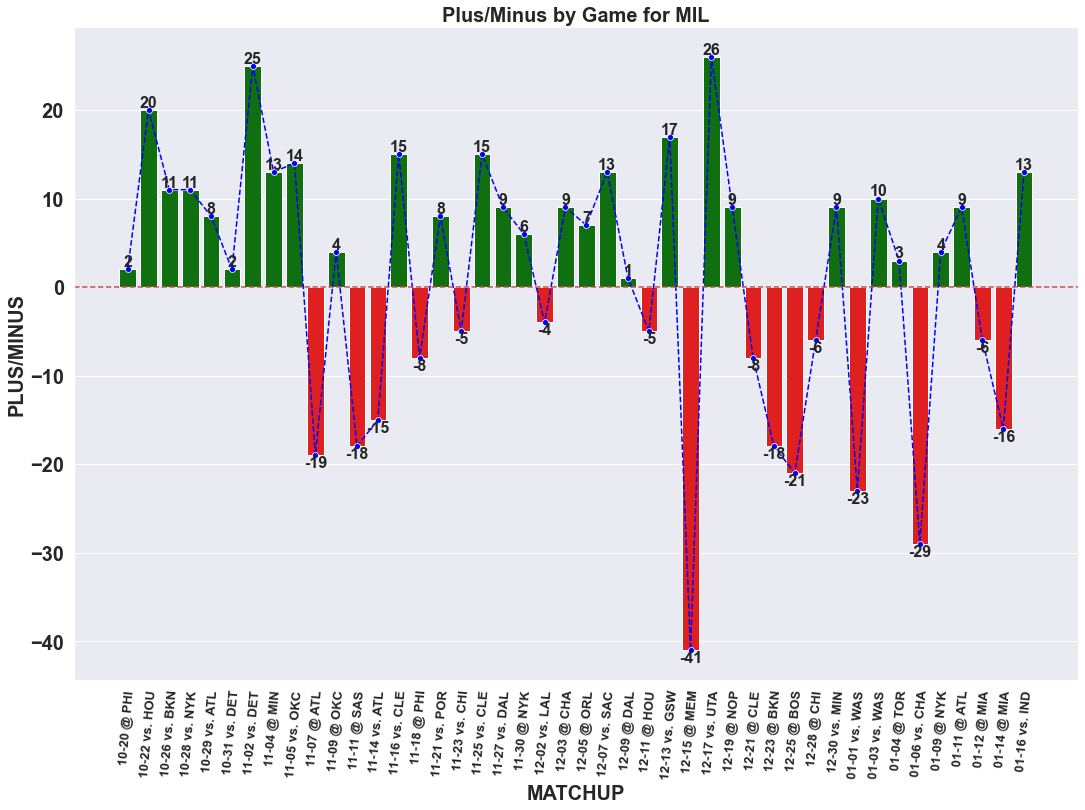

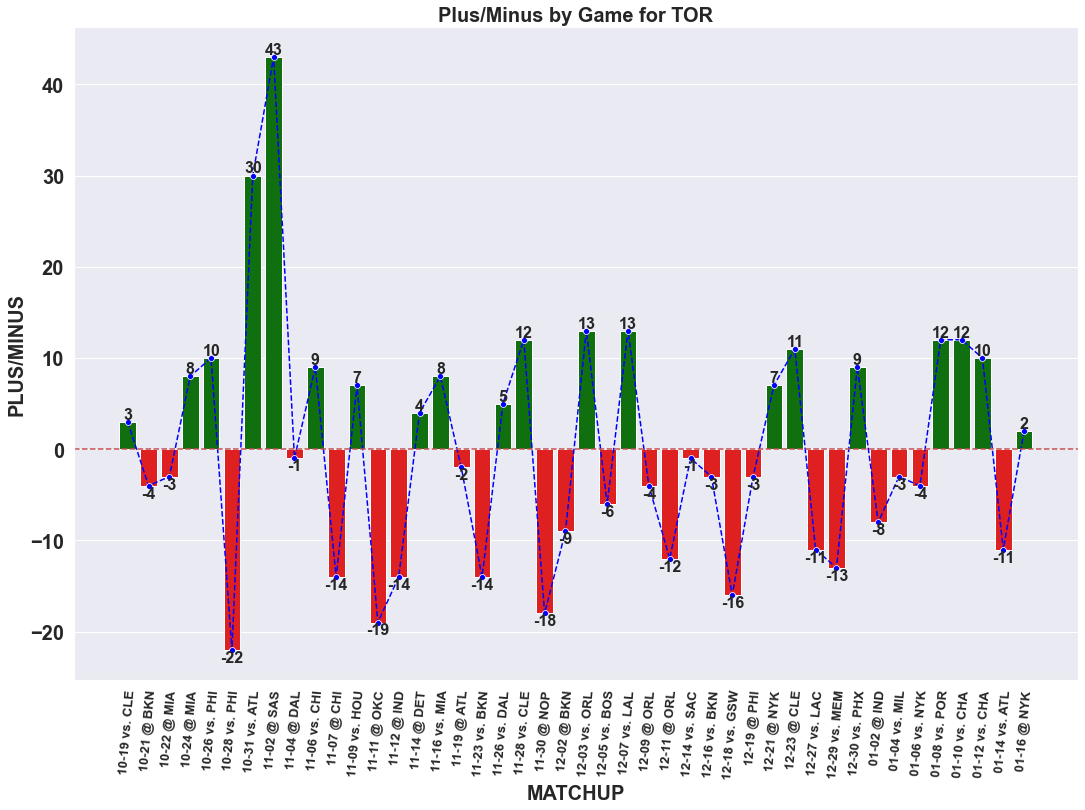

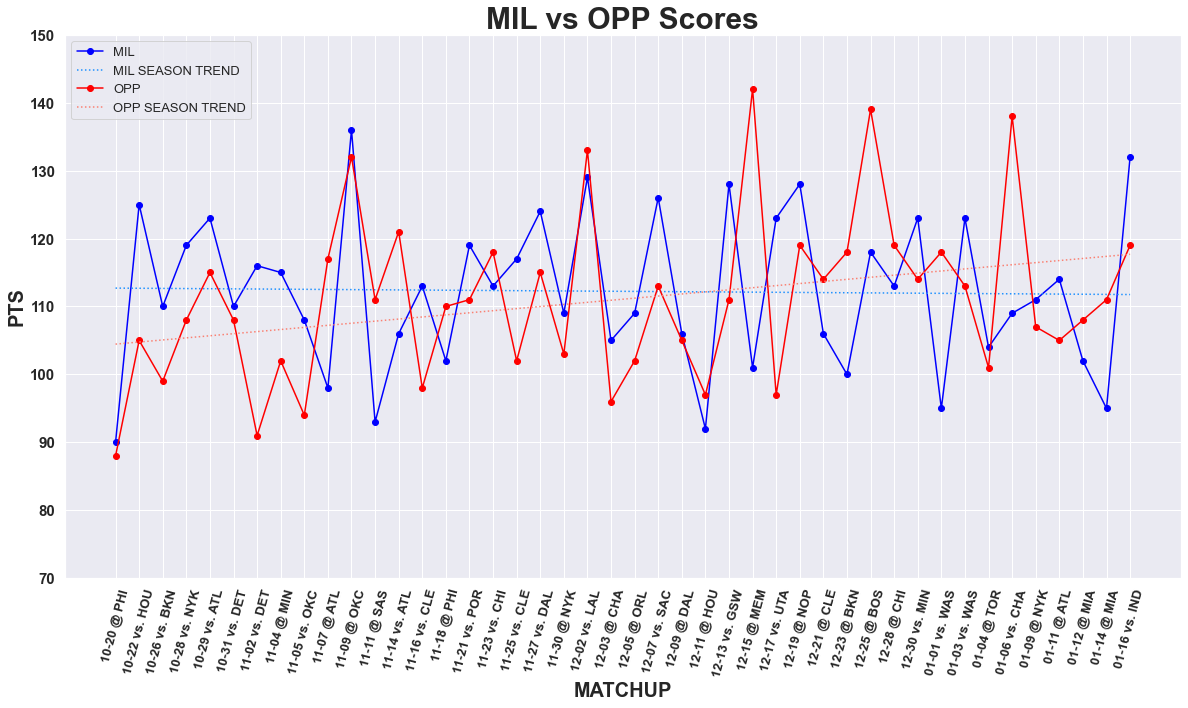

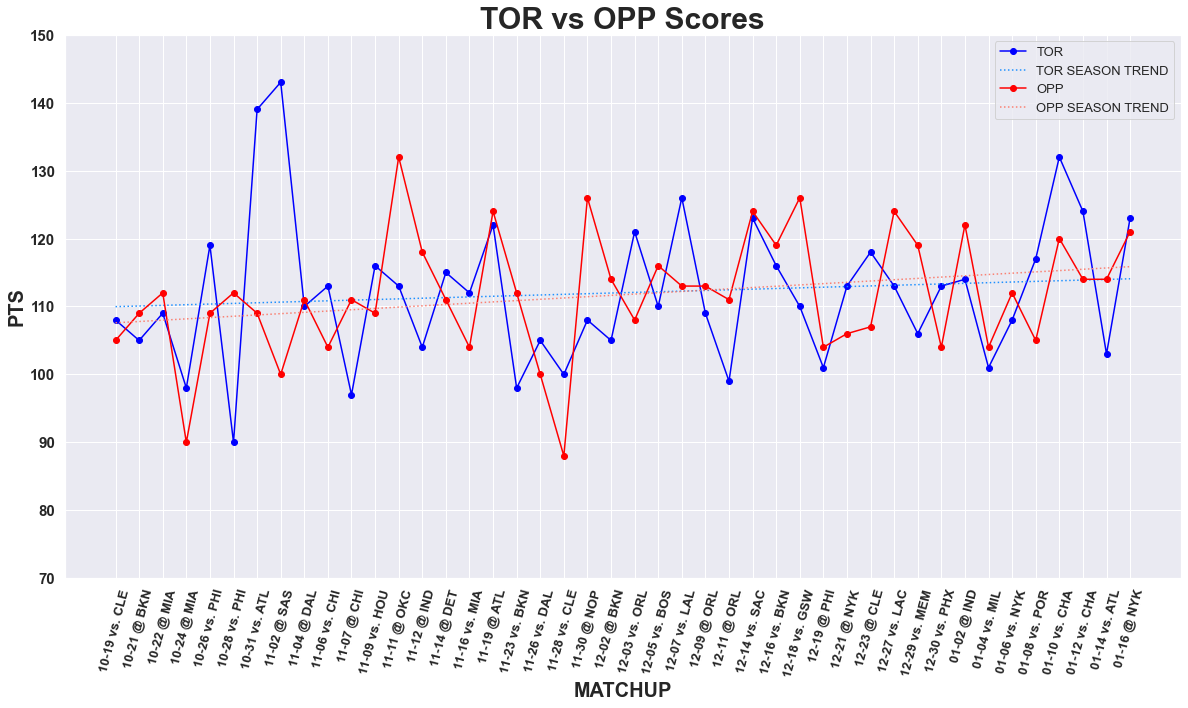

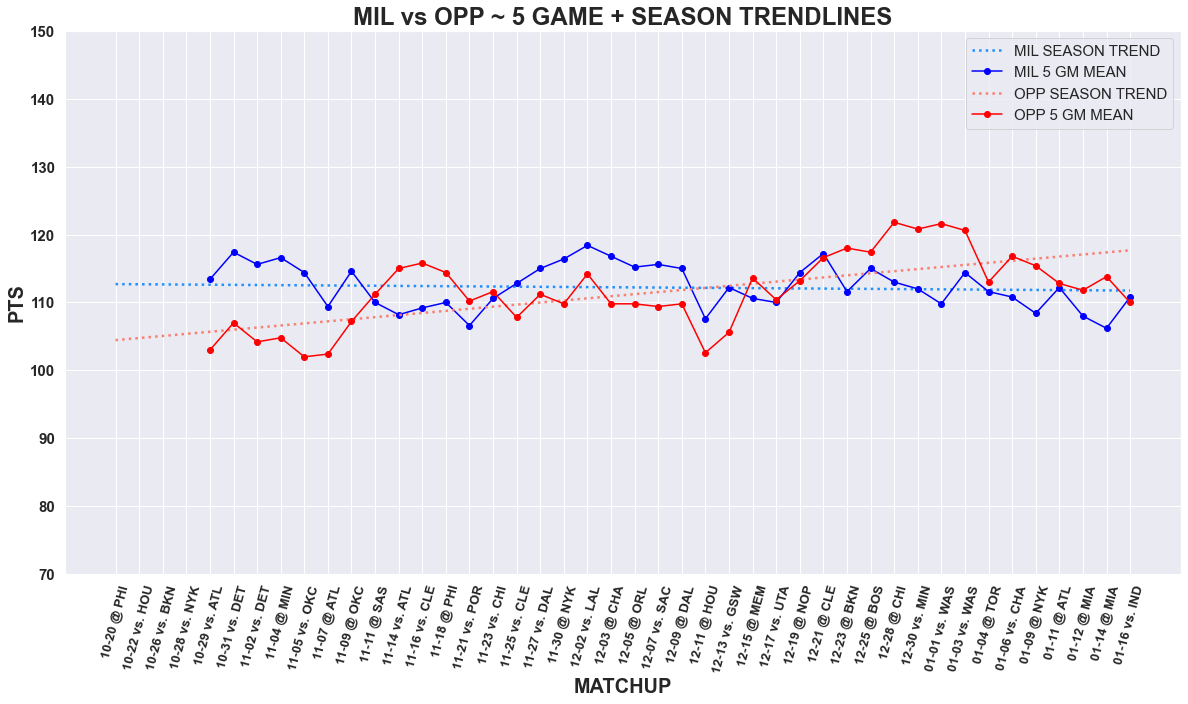

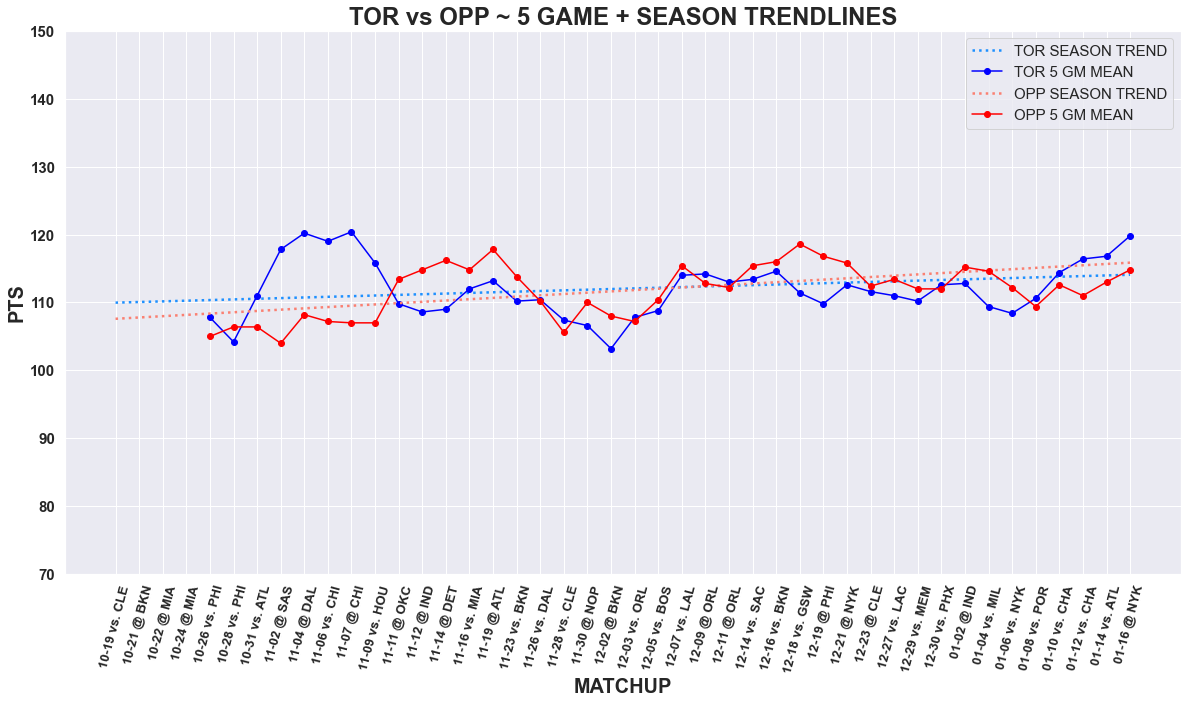

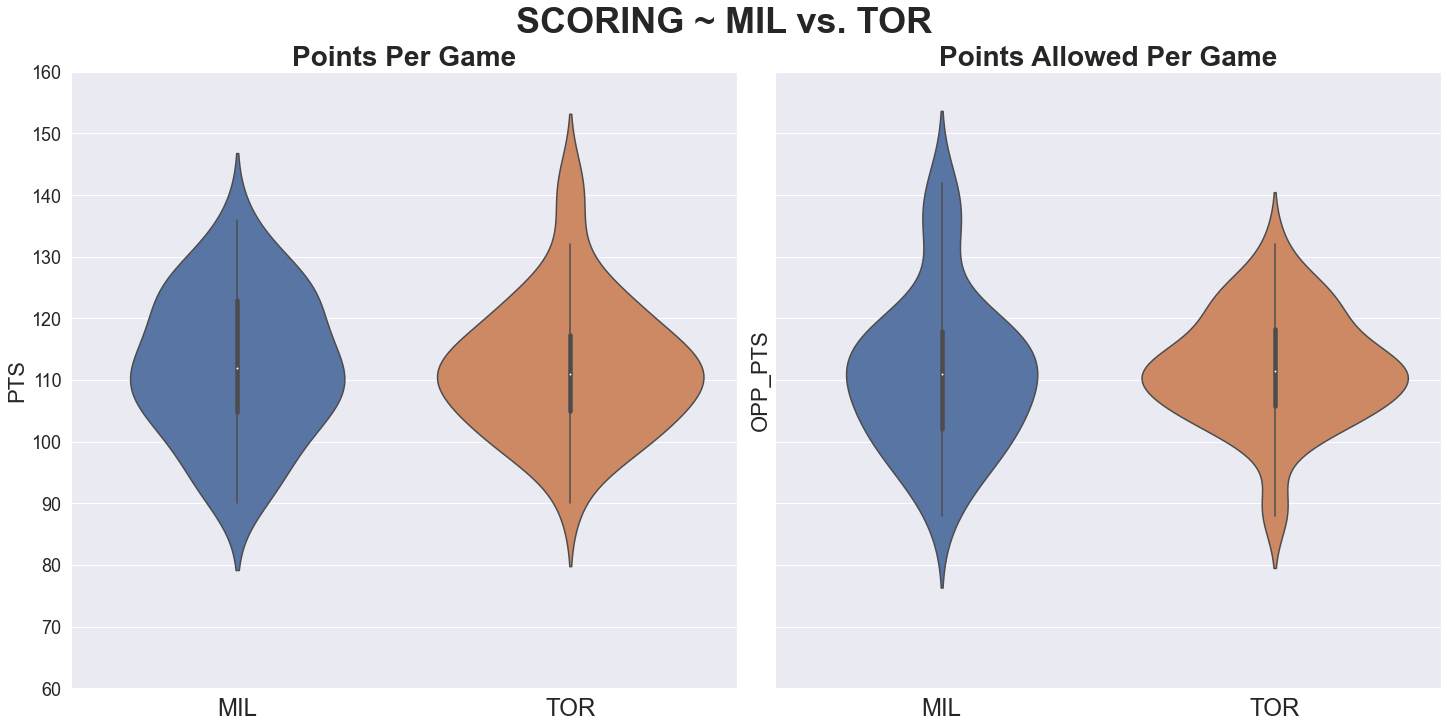

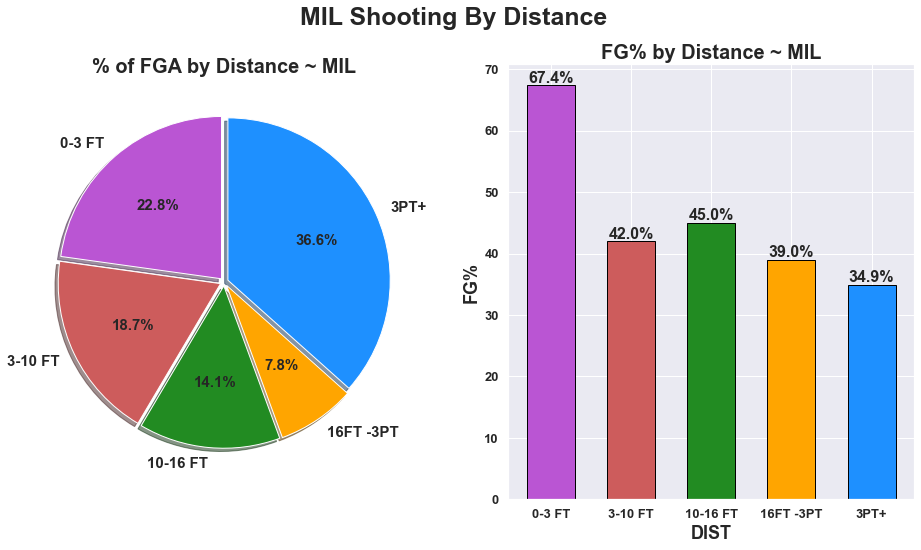

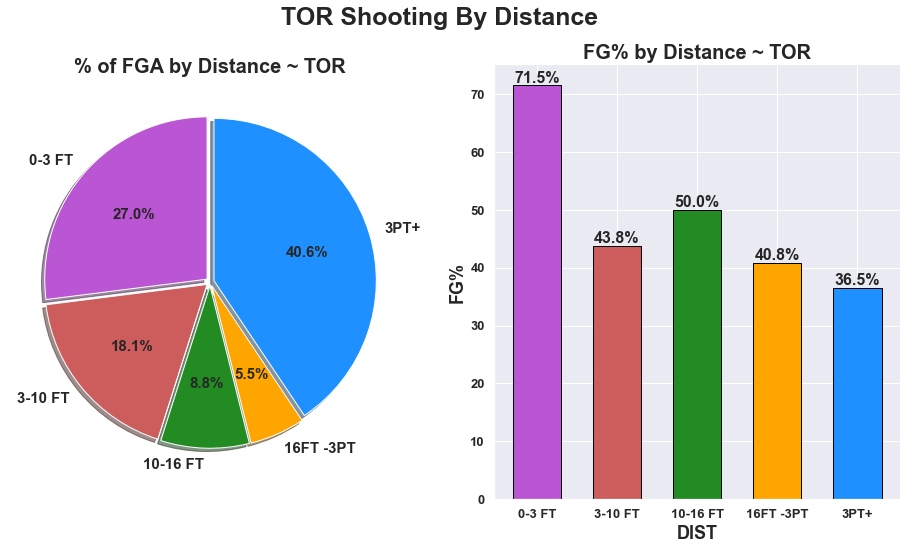

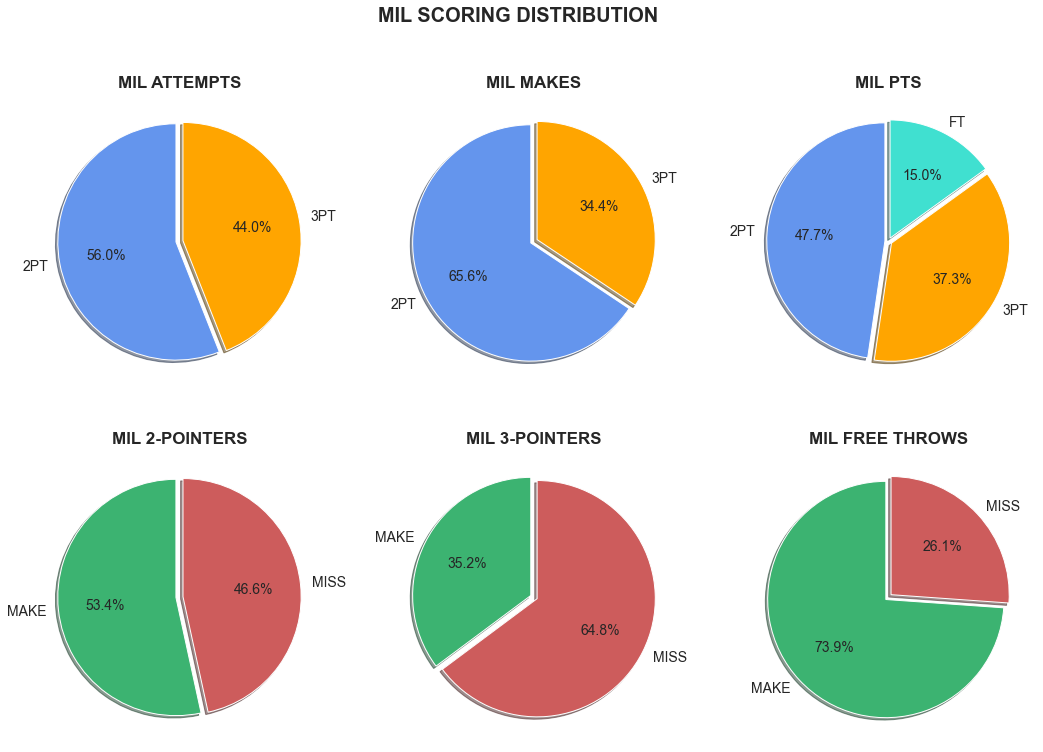

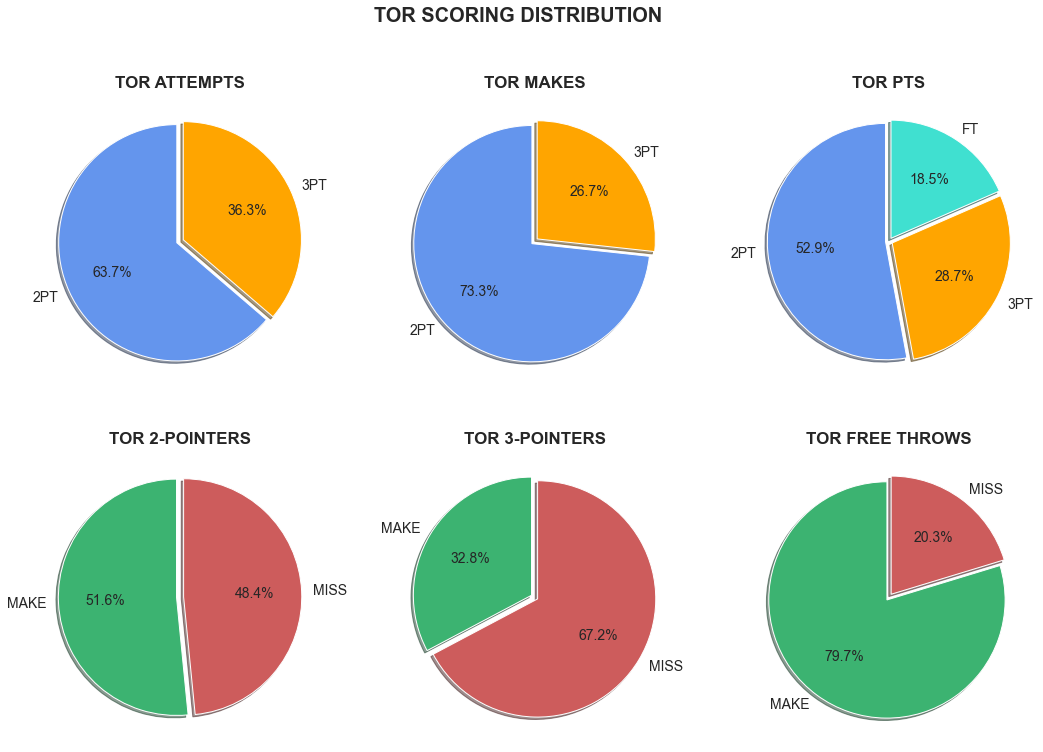

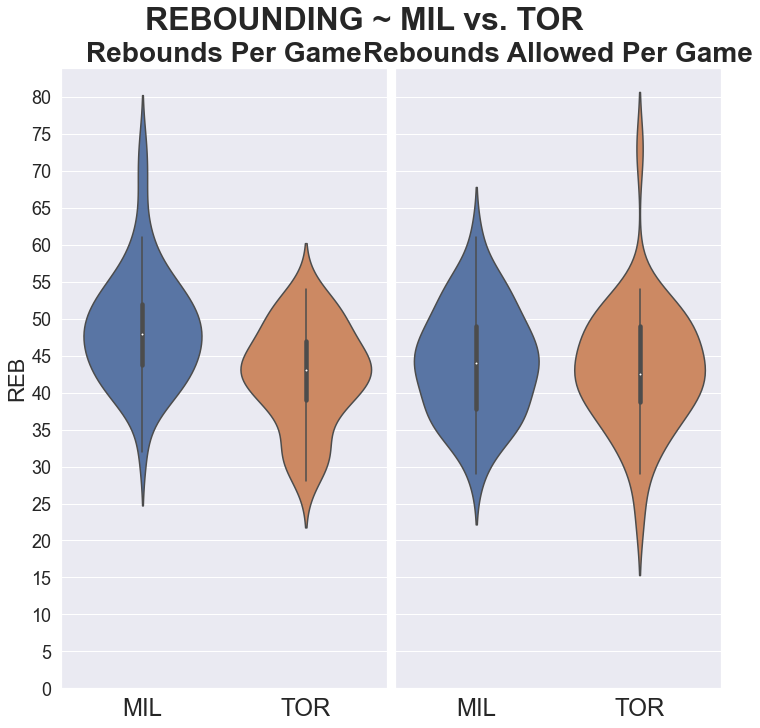

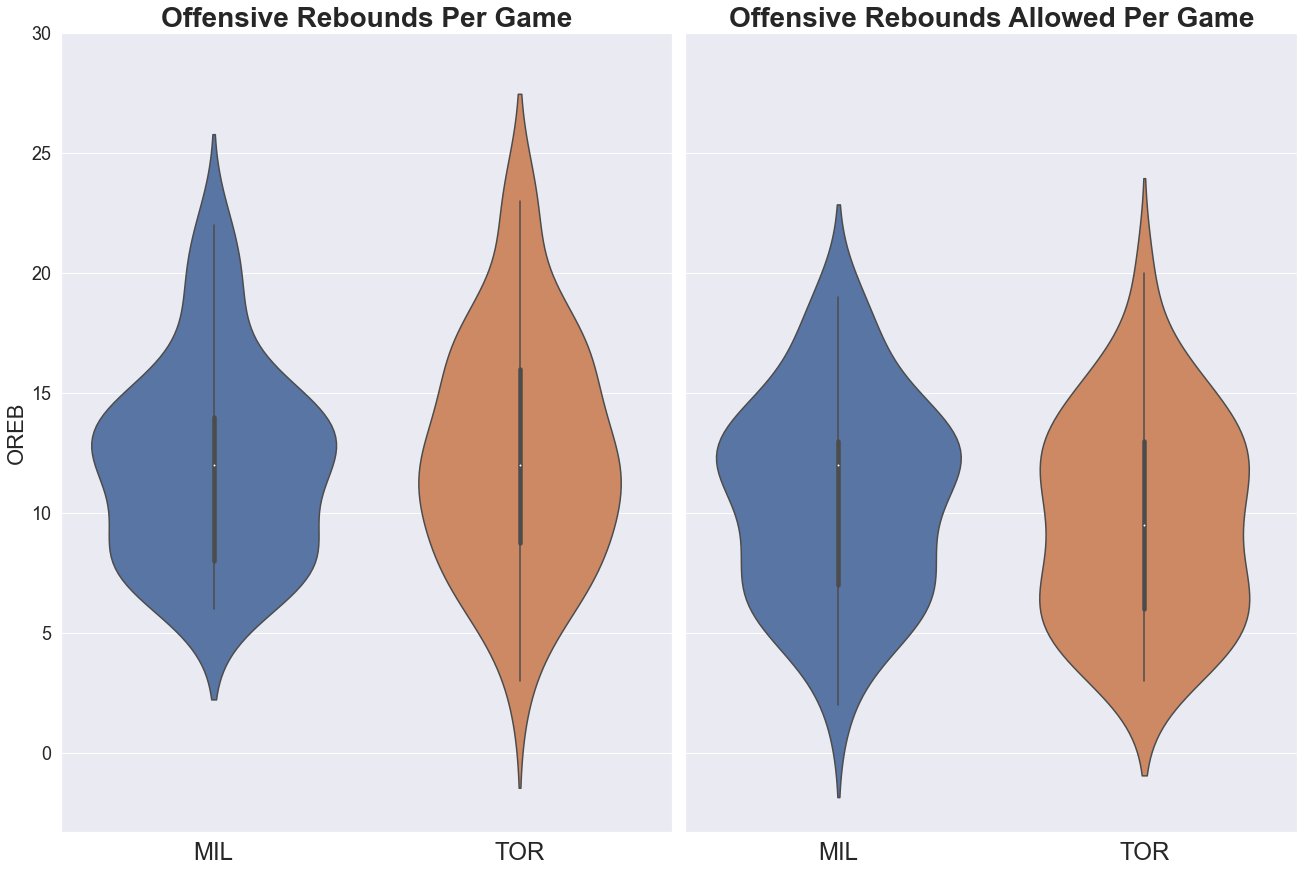

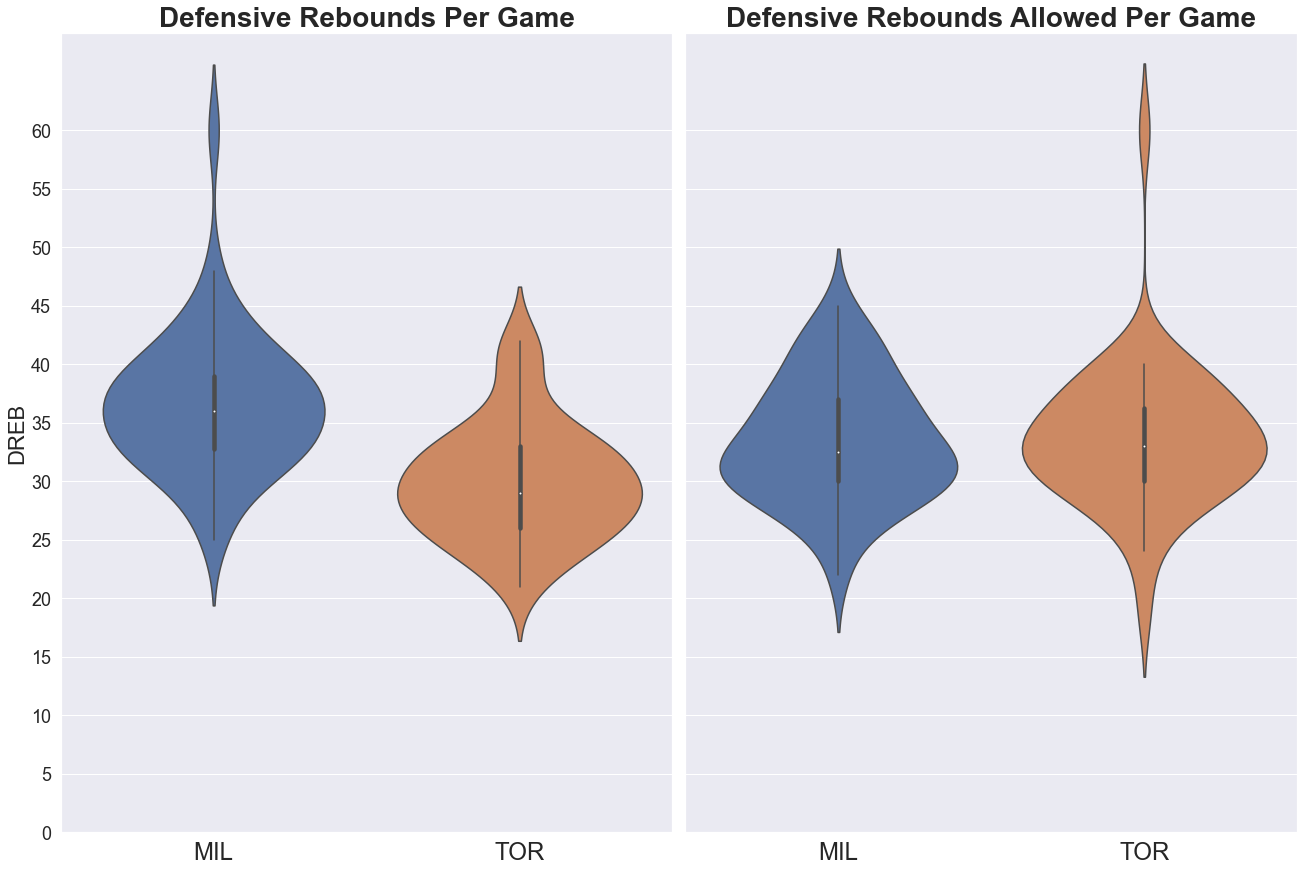

In [34]:
def compare_teams(team_a_abbr, team_b_abbr):
    df_a = get_team_df(team_a_abbr)
    df_b = get_team_df(team_b_abbr)
    df_merged = pd.concat([df_a,df_b])
    
    wl_pies(team_a_abbr)
    wl_pies(team_b_abbr)
    
    plus_minus_plot(team_a_abbr)
    plus_minus_plot(team_b_abbr)
    
    line_plot_scores(team_a_abbr)
    line_plot_scores(team_b_abbr)
    
    trend_plot_scores(team_a_abbr)
    trend_plot_scores(team_b_abbr)
    
    scored_allowed_compare(team_a_abbr, team_b_abbr)
    
    team_fg_by_dist(team_a_abbr)
    team_fg_by_dist(team_b_abbr)
    
    shot_pies(team_a_abbr)
    shot_pies(team_b_abbr)
    
    rebounds_compare(team_a_abbr, team_b_abbr)
    
    plt.show()

compare_teams('MIL','TOR')

## NBA All Team Comparison Report

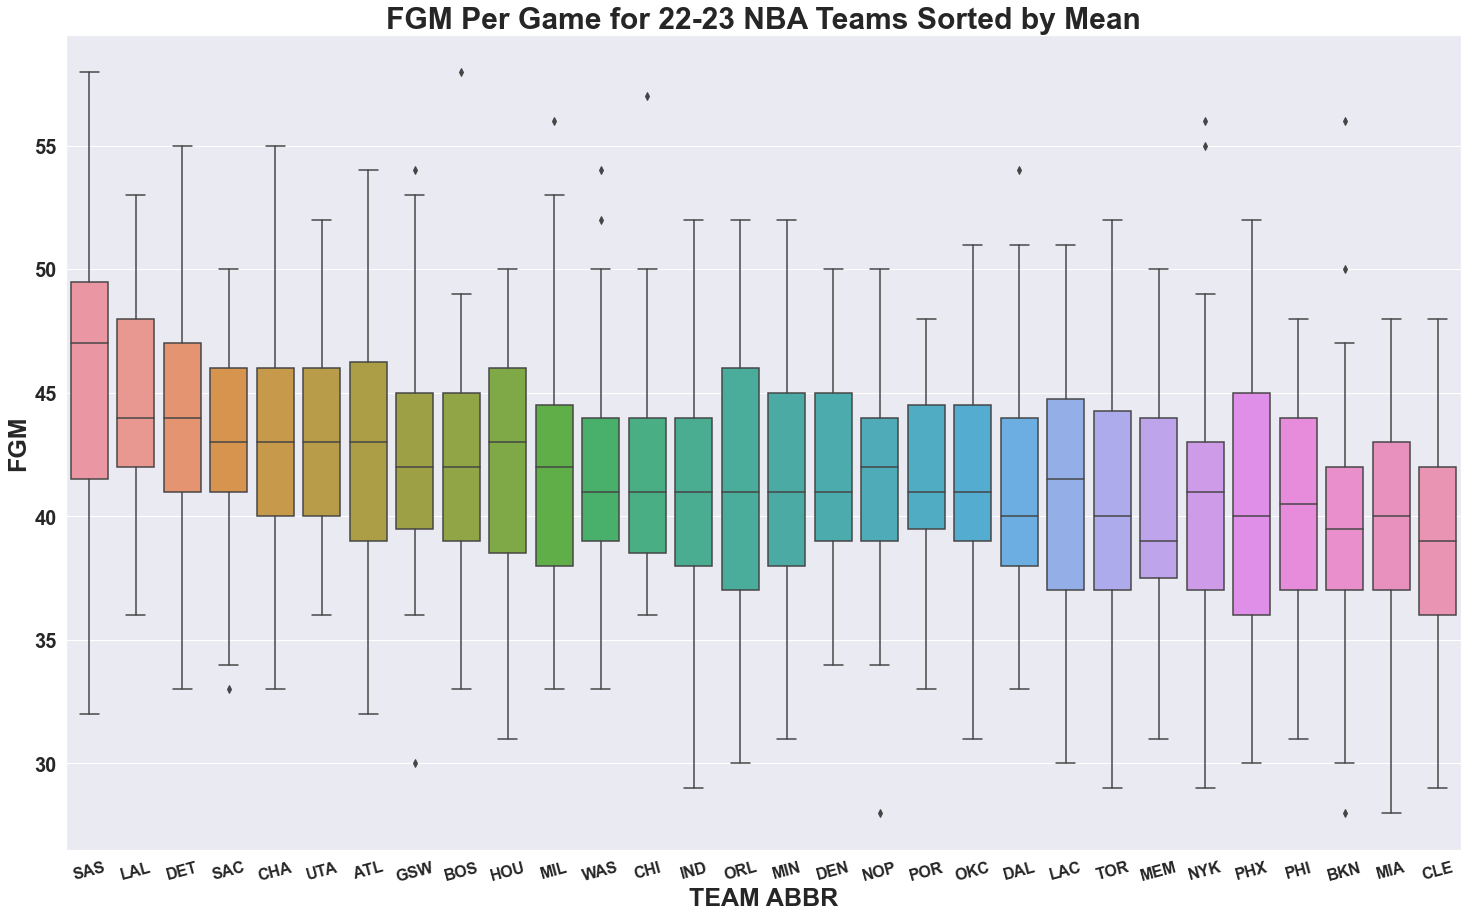

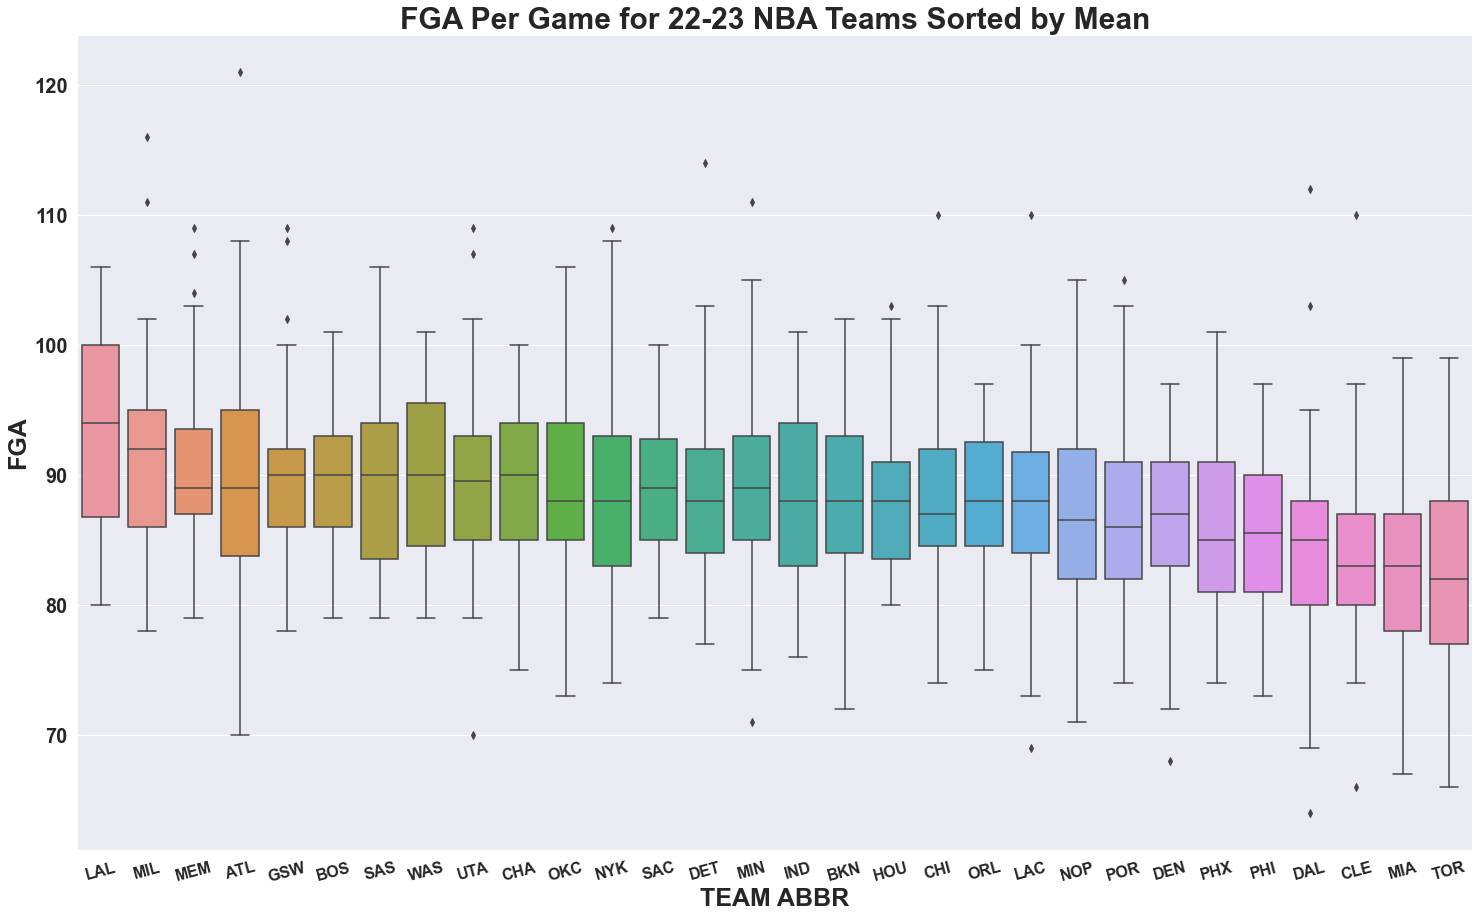

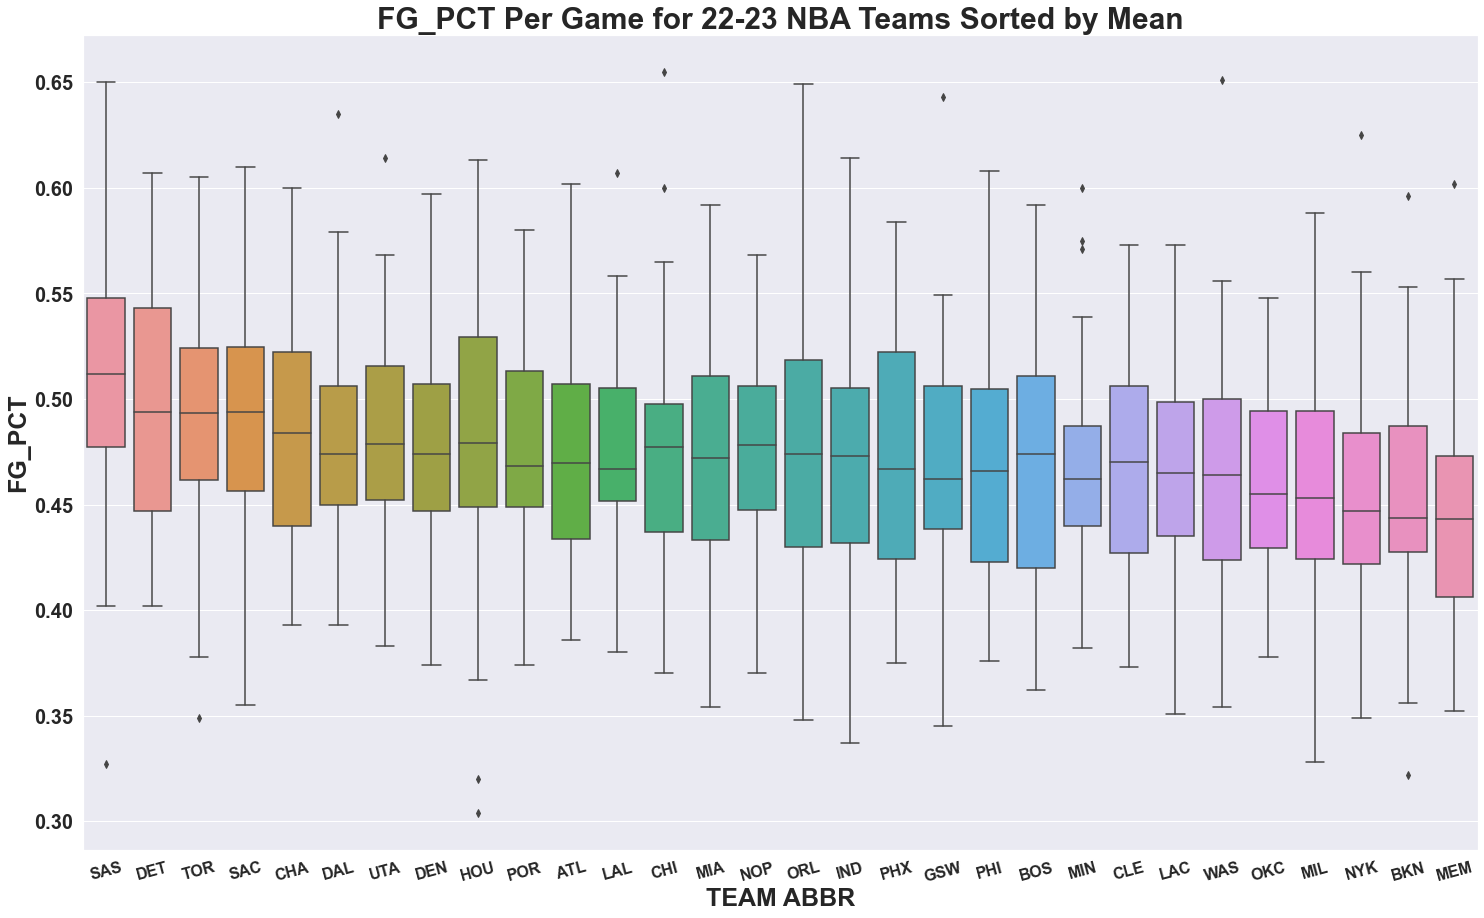

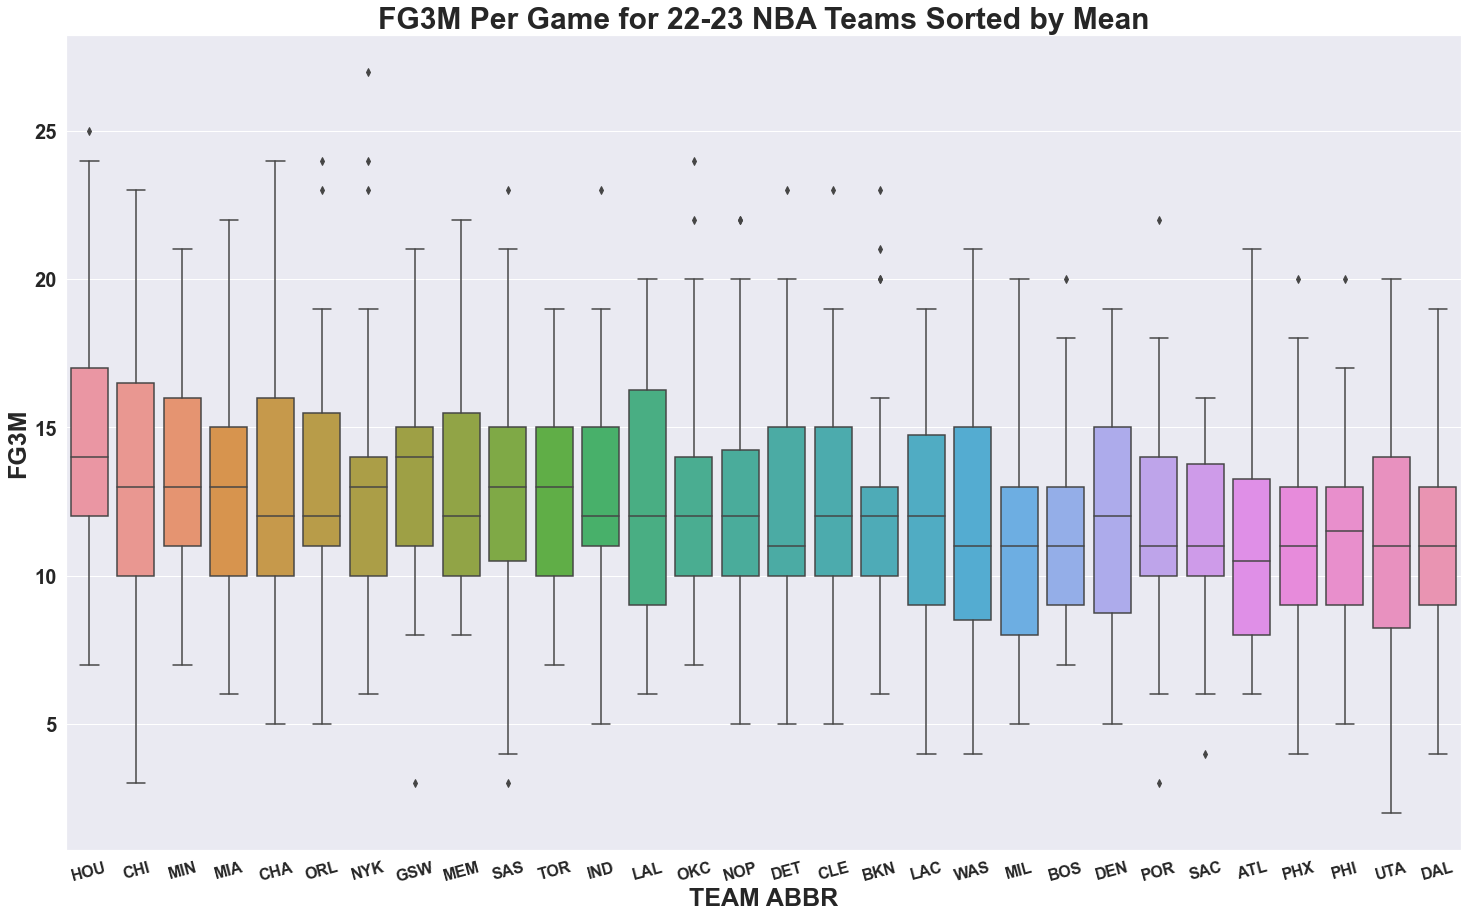

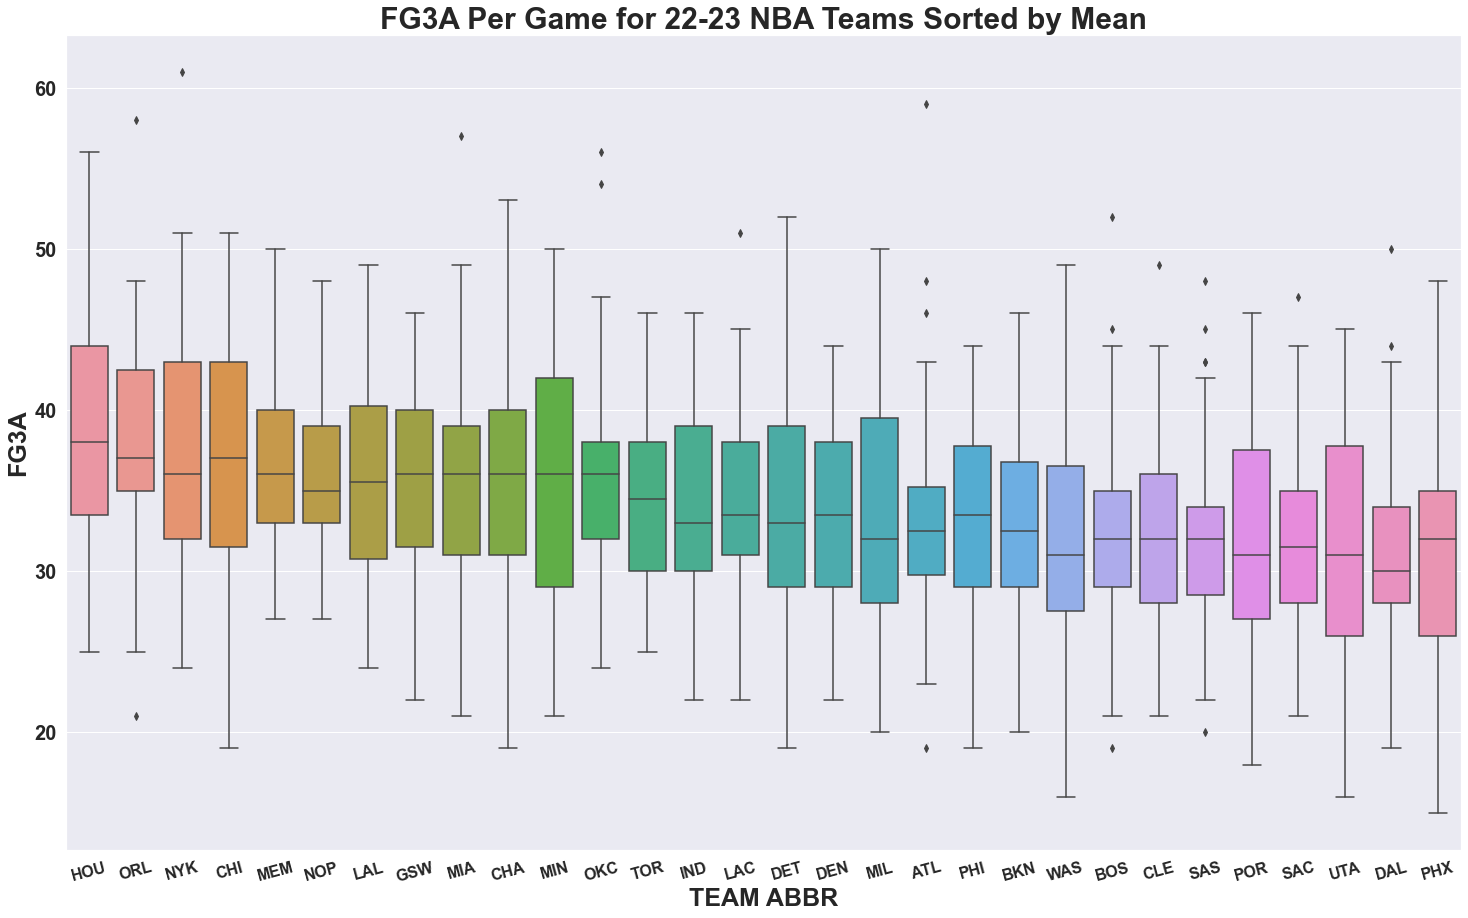

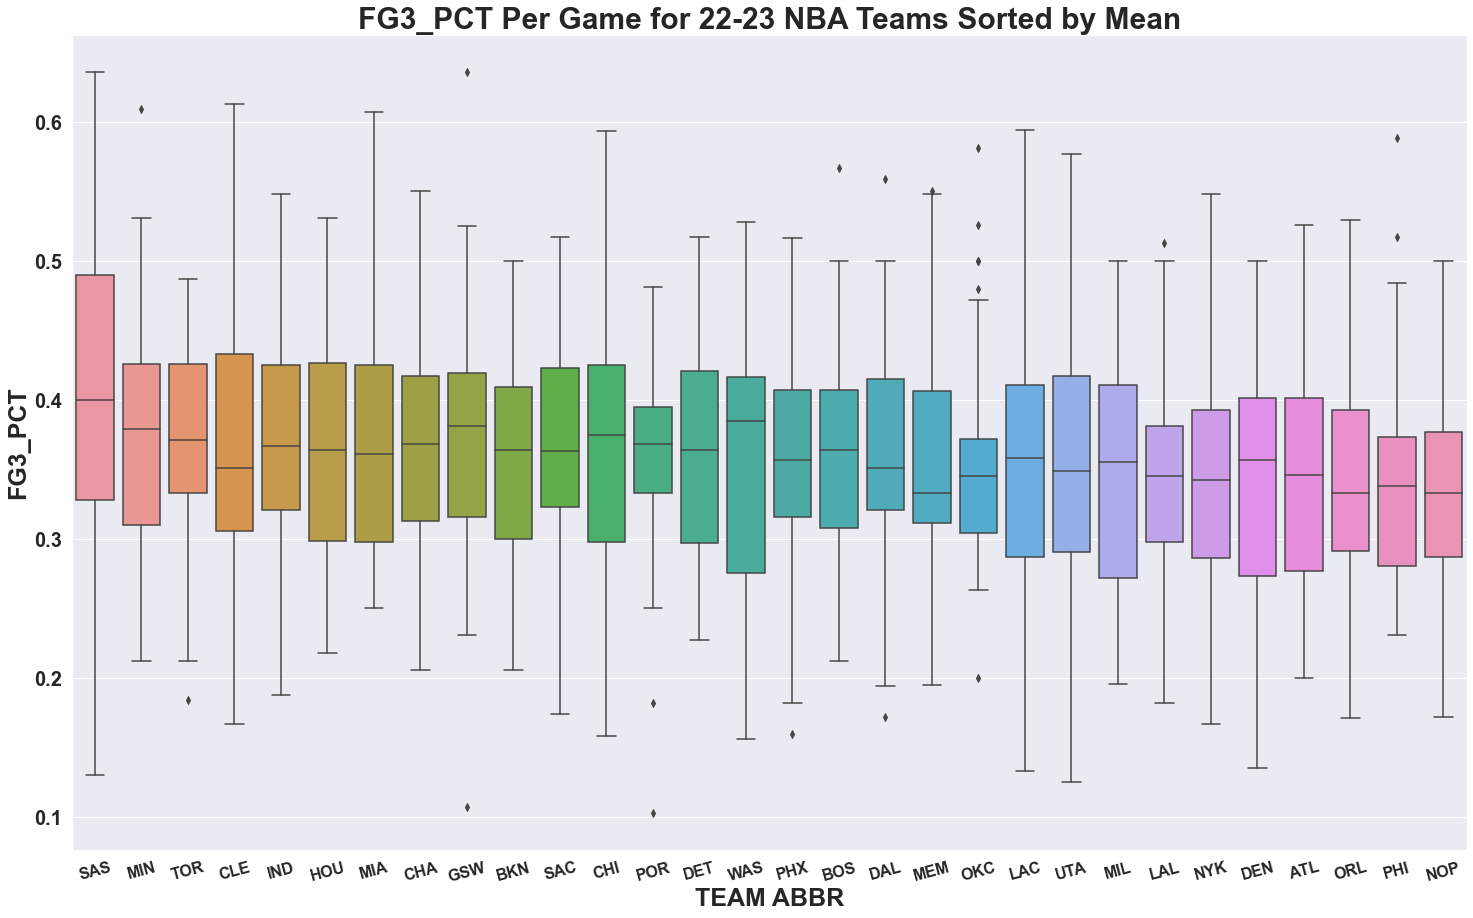

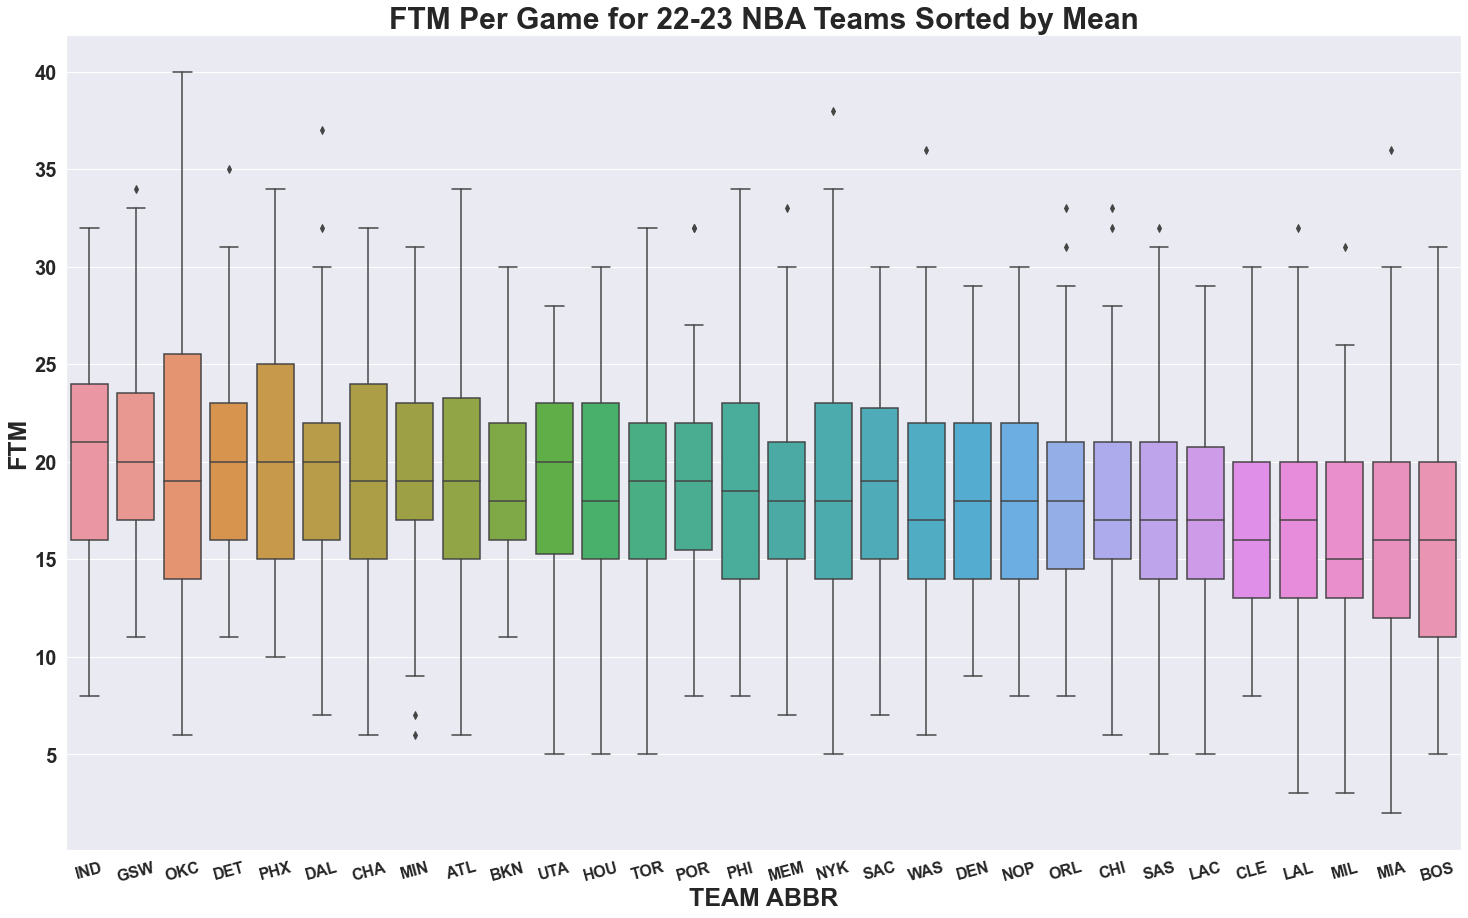

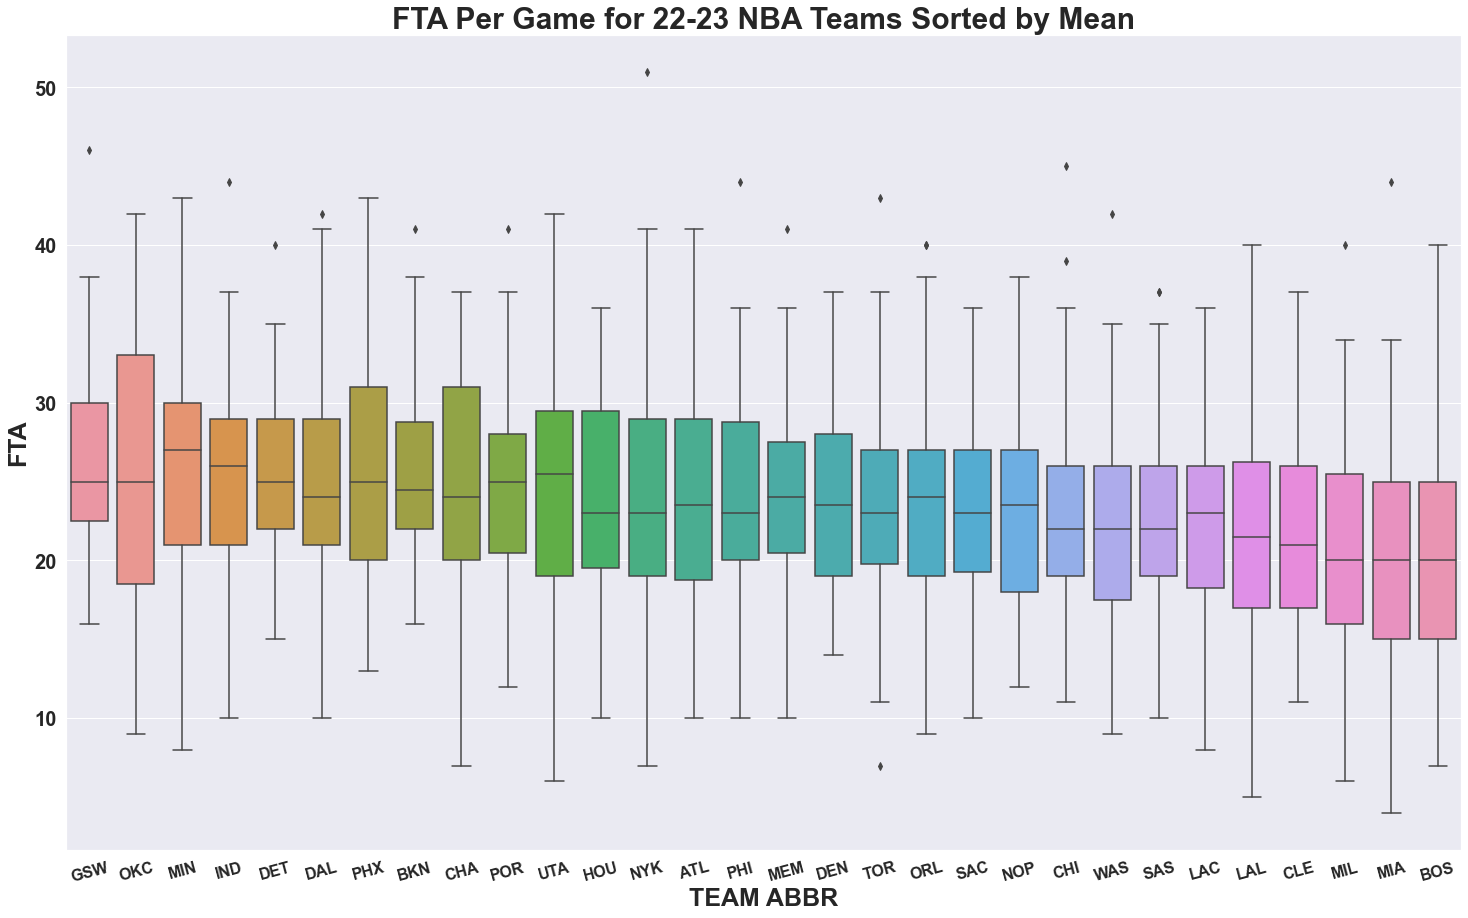

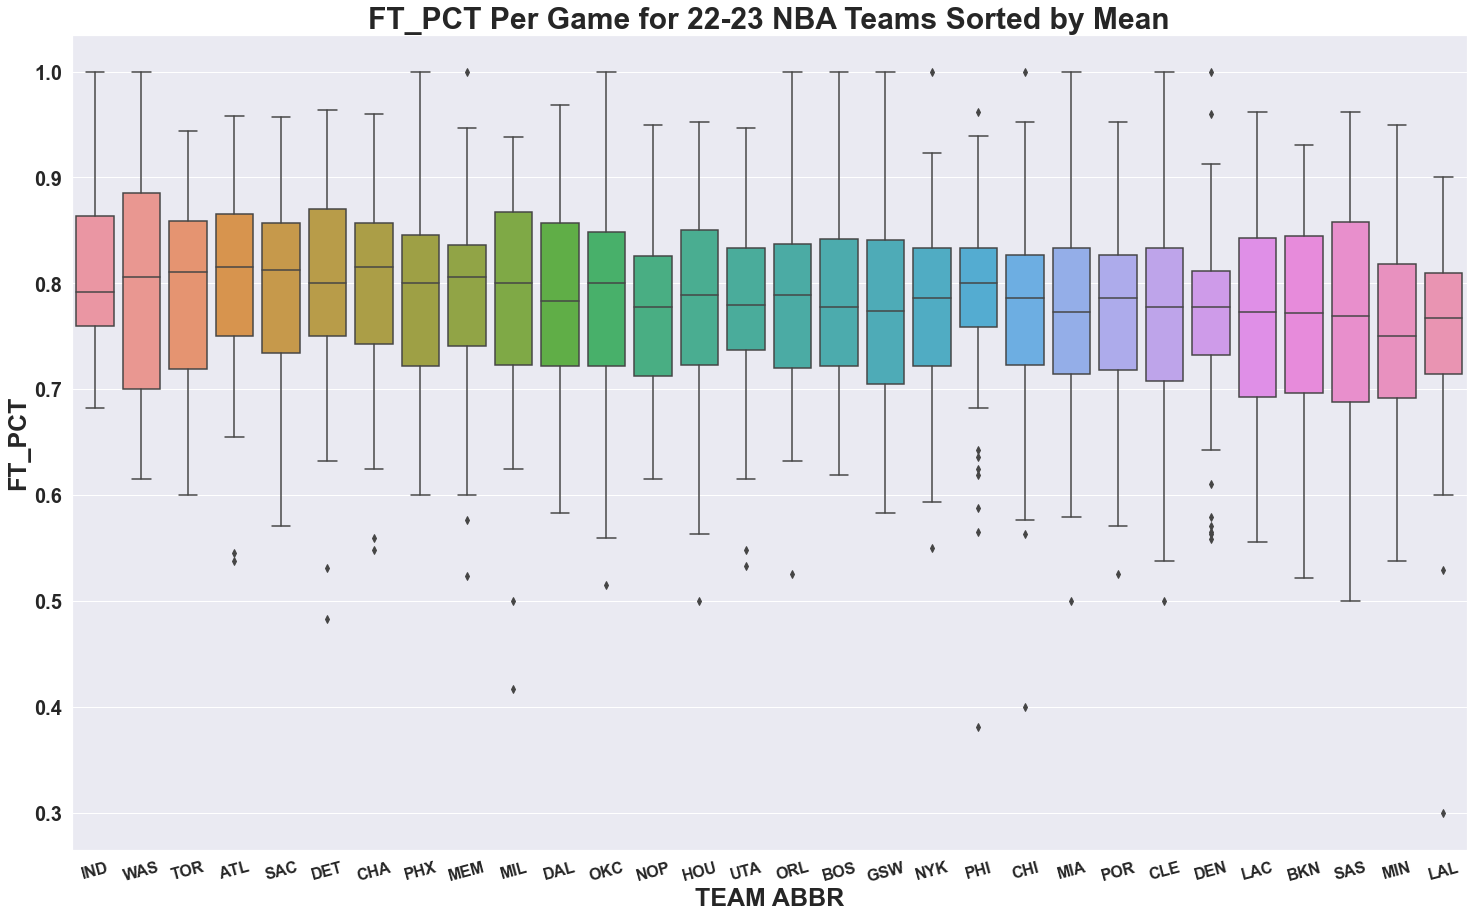

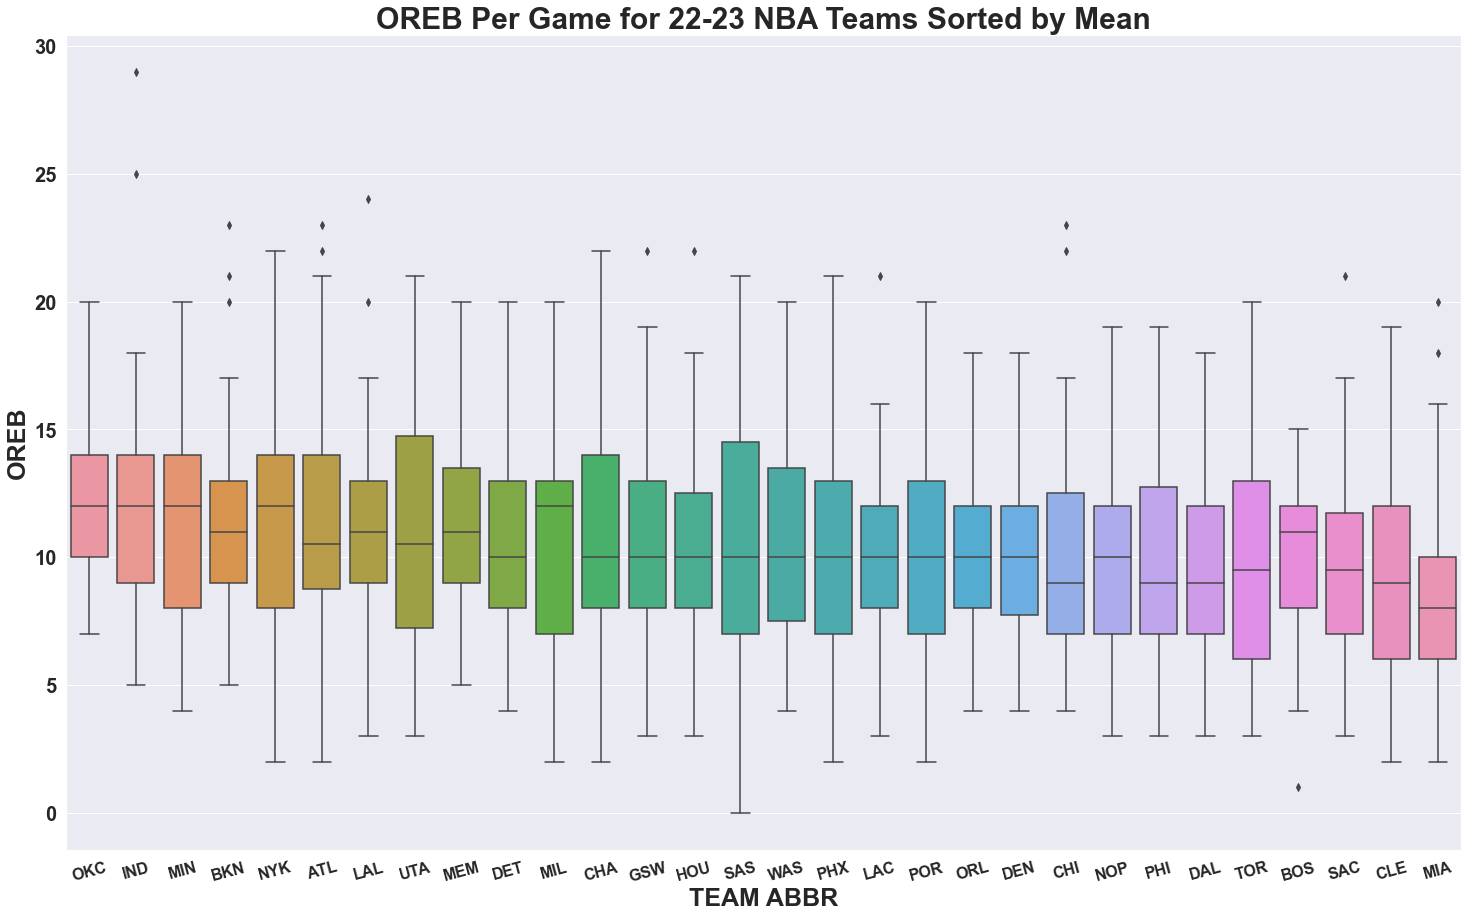

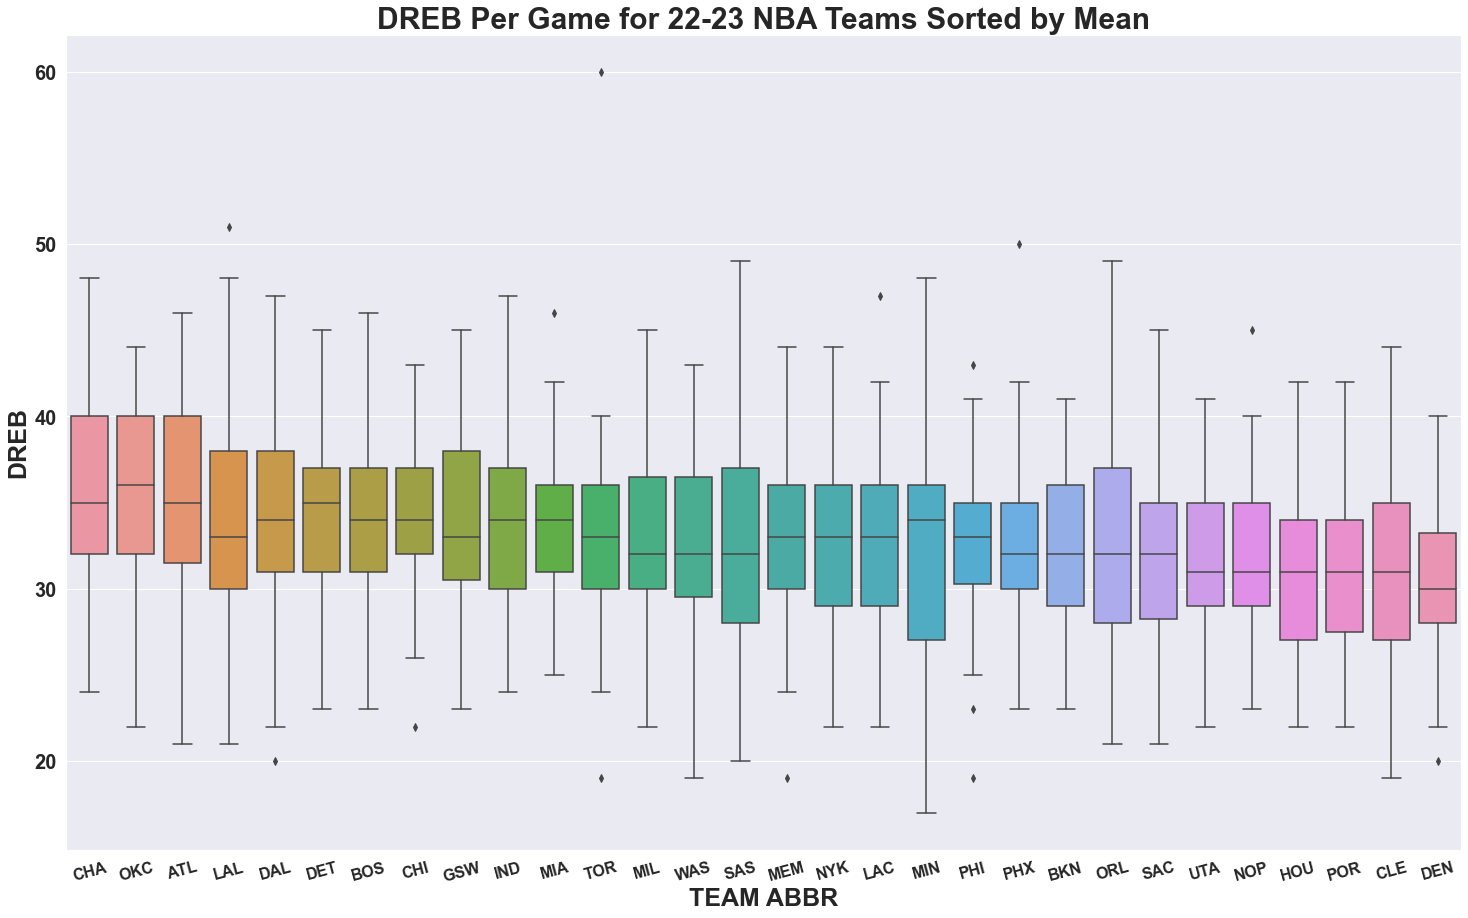

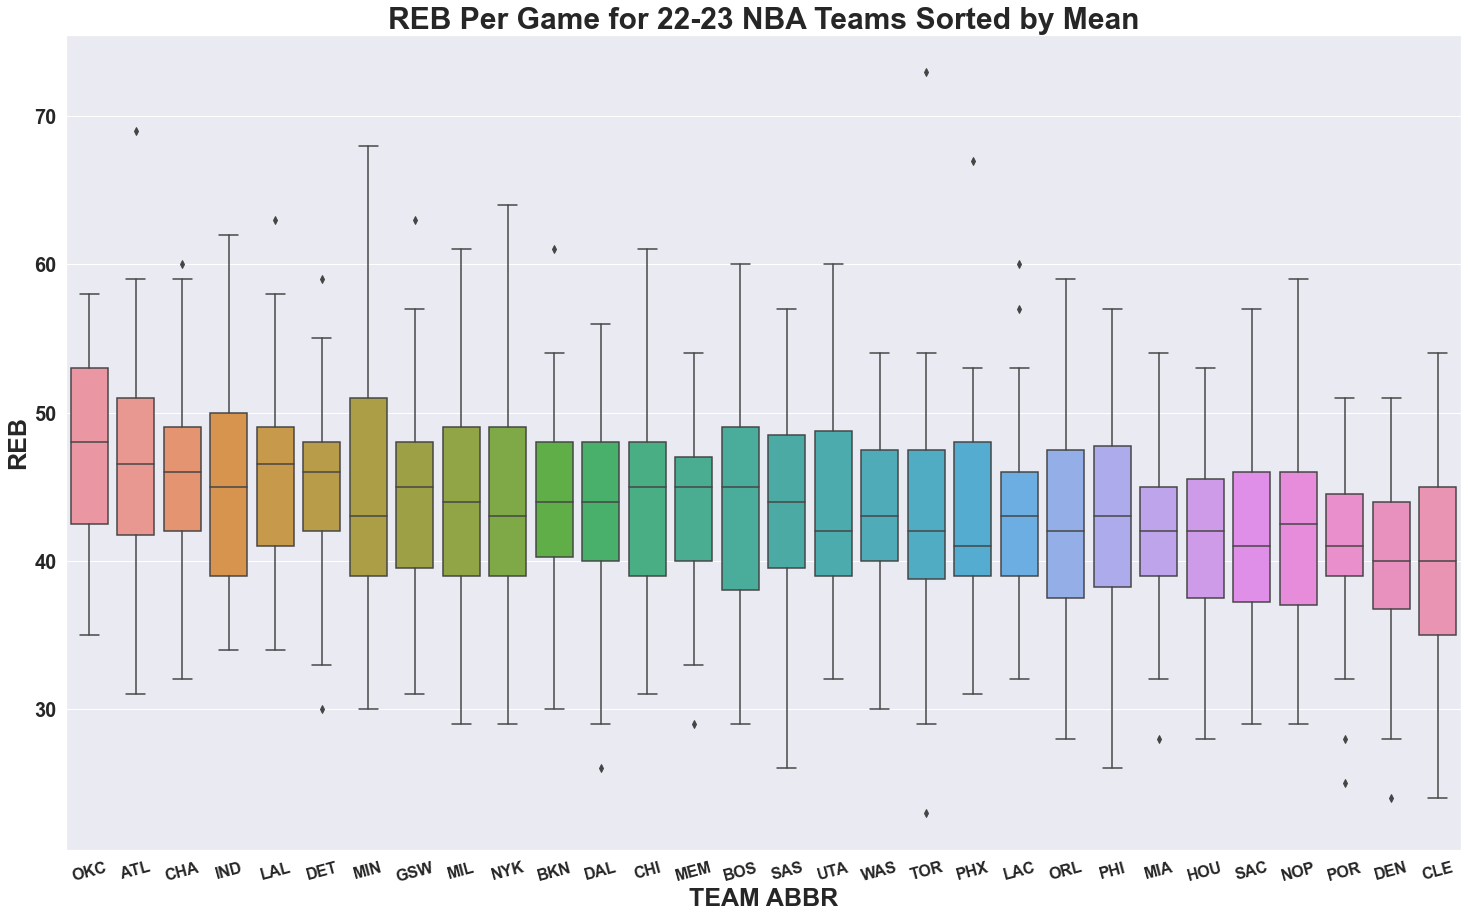

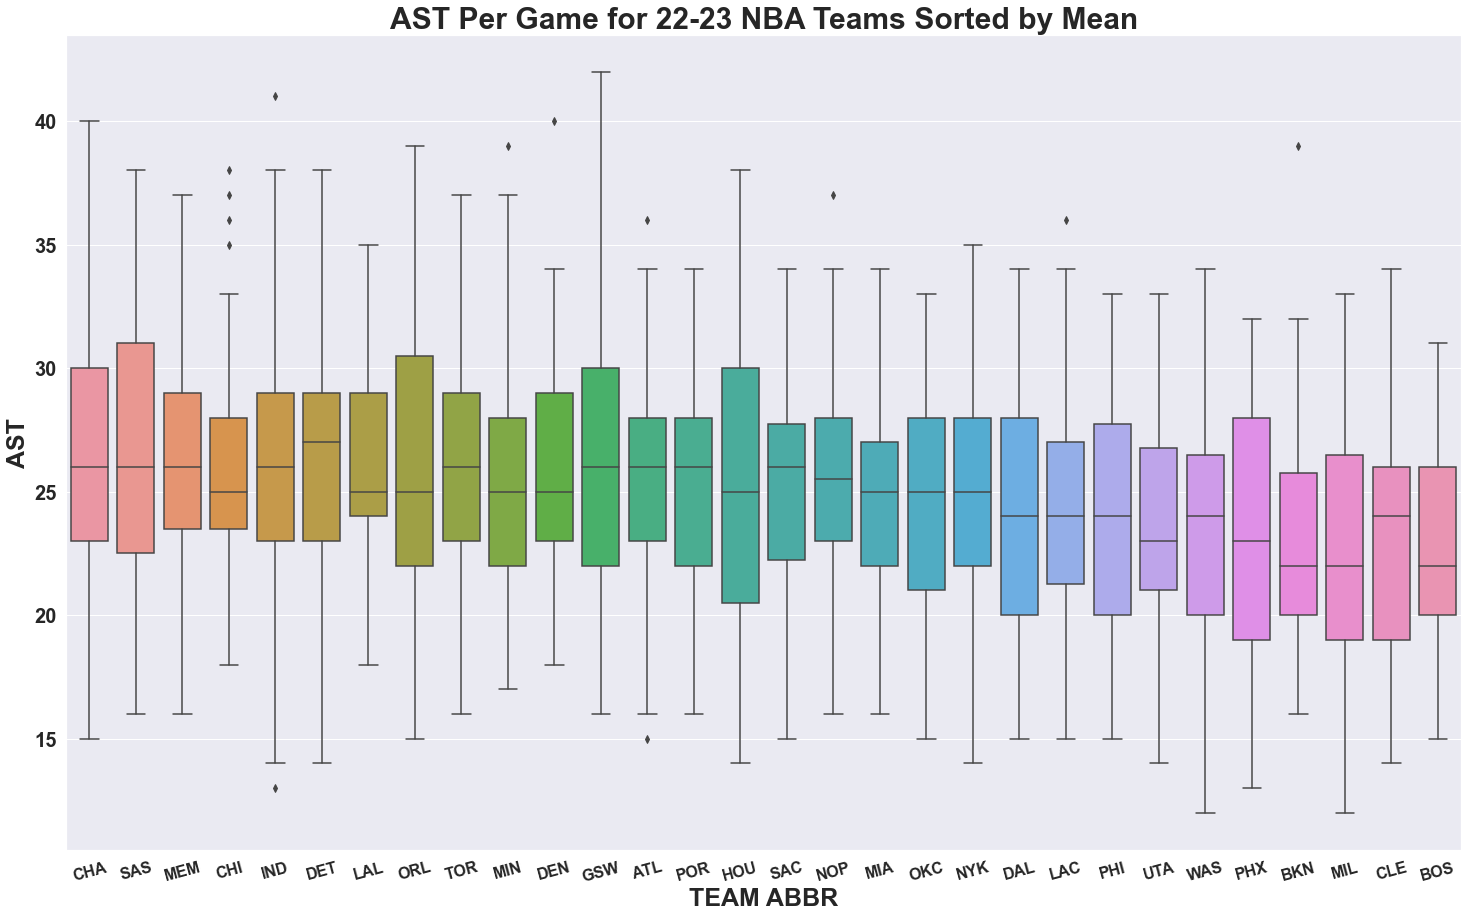

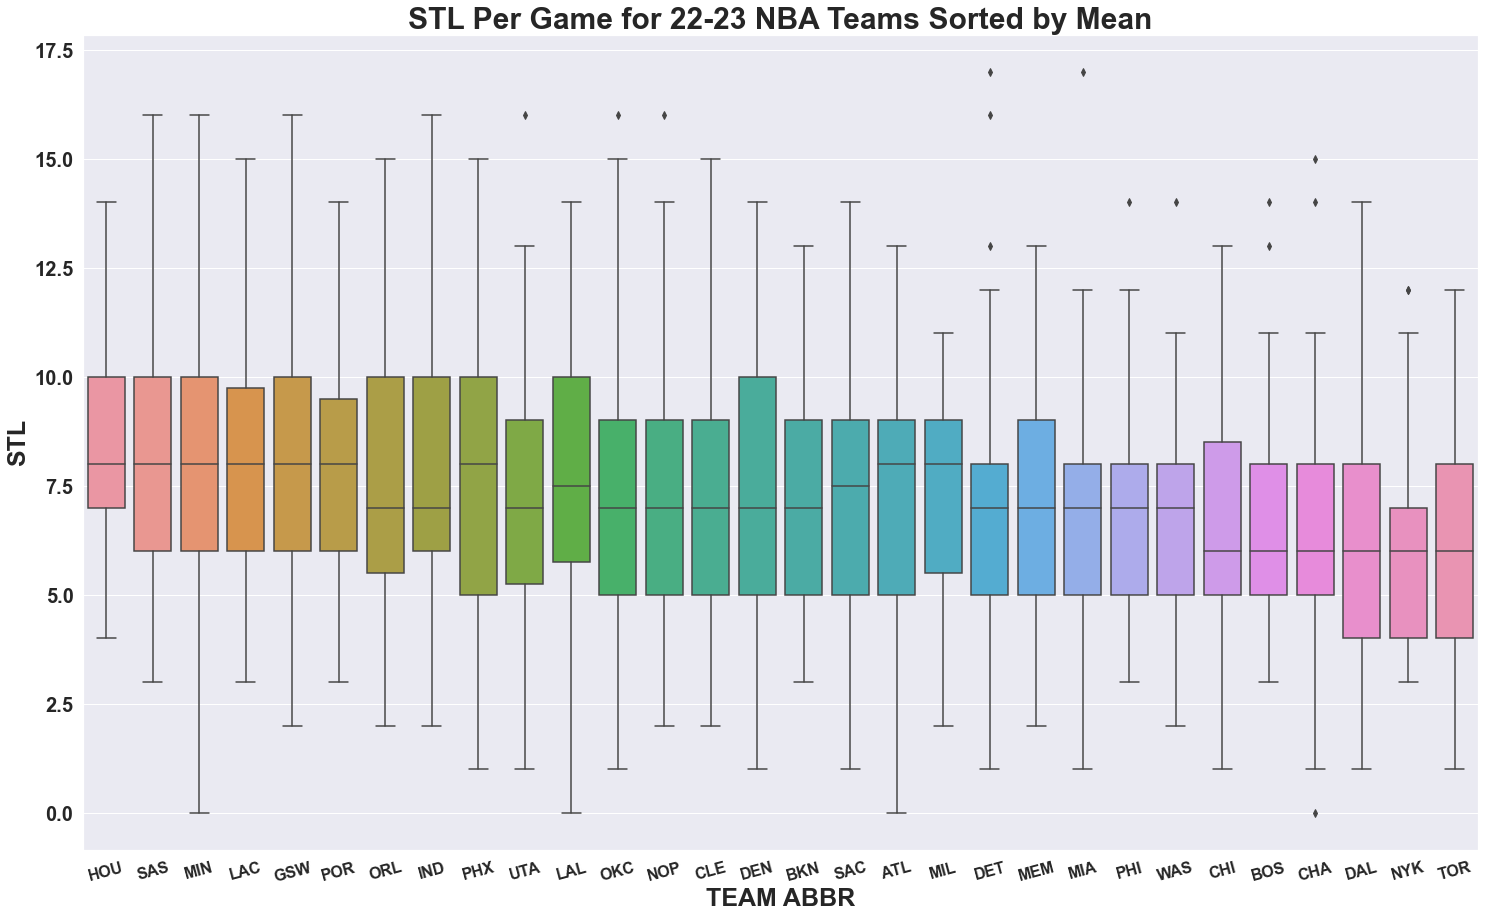

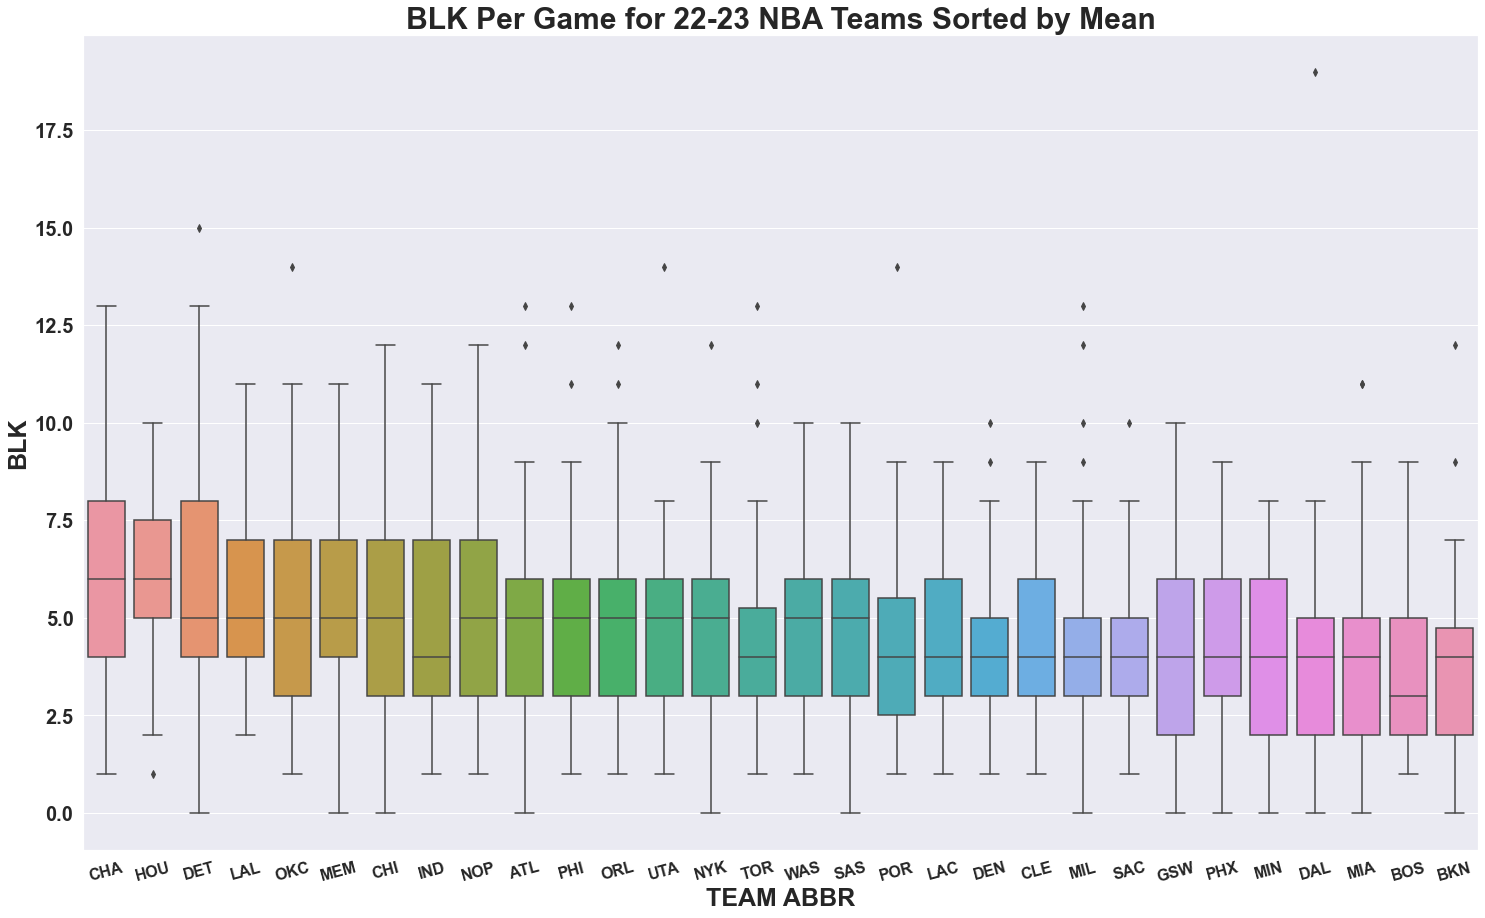

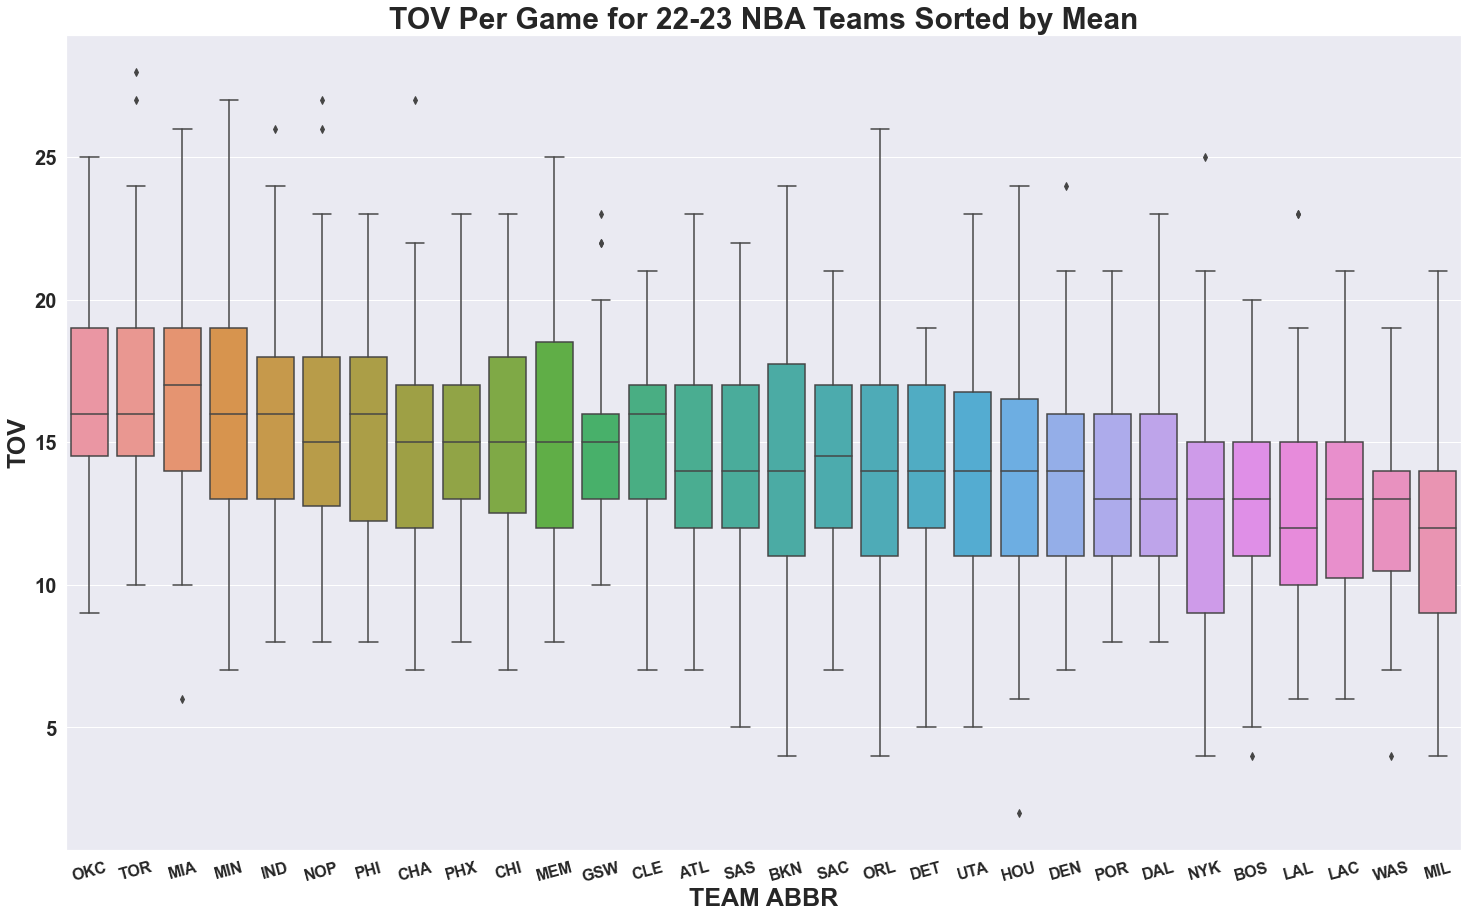

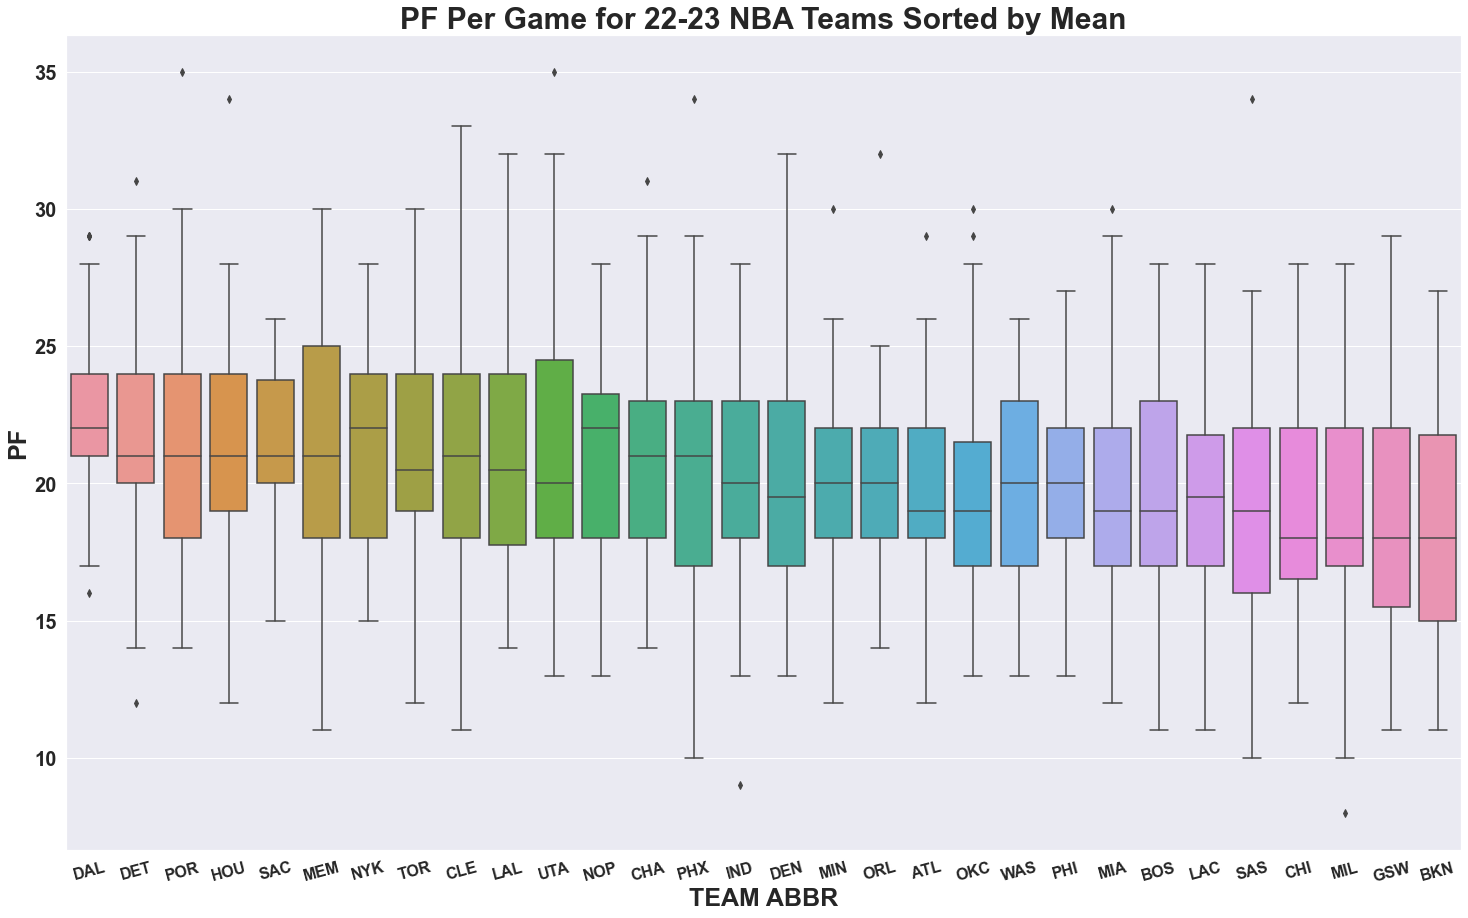

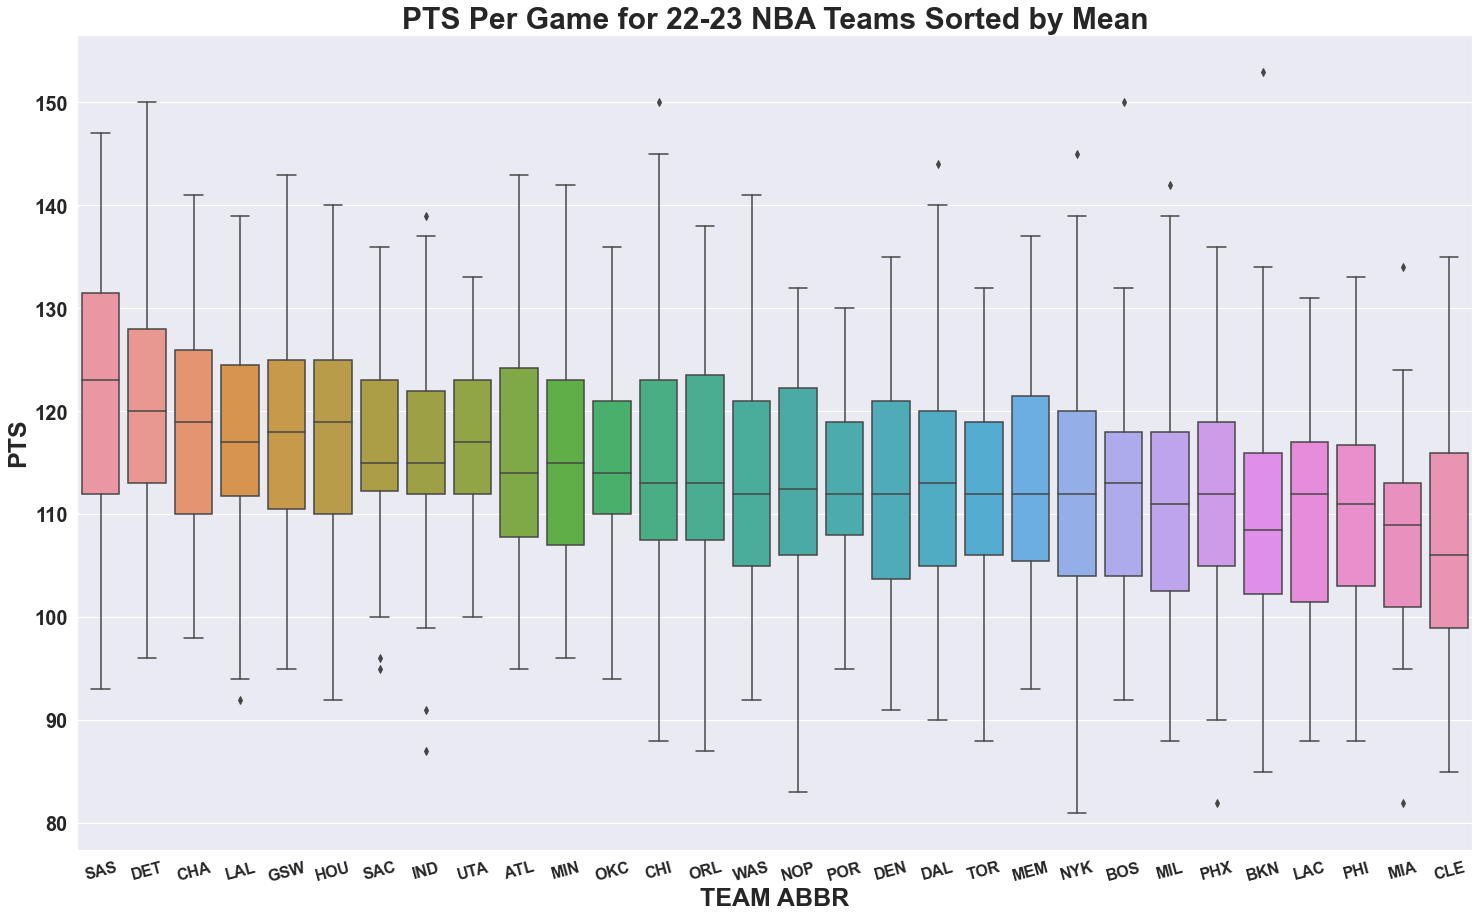

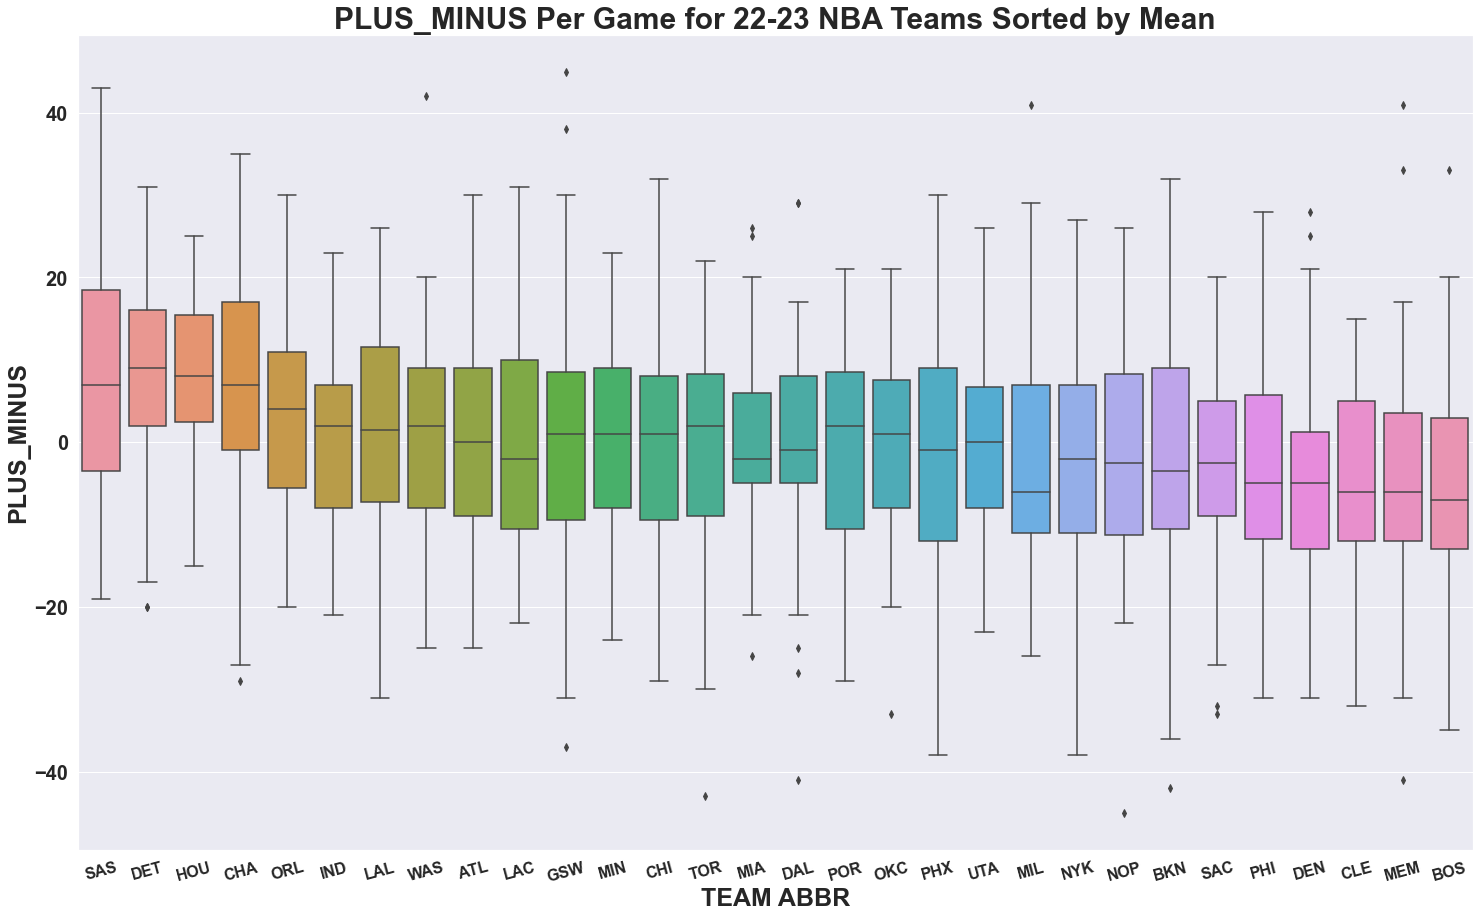

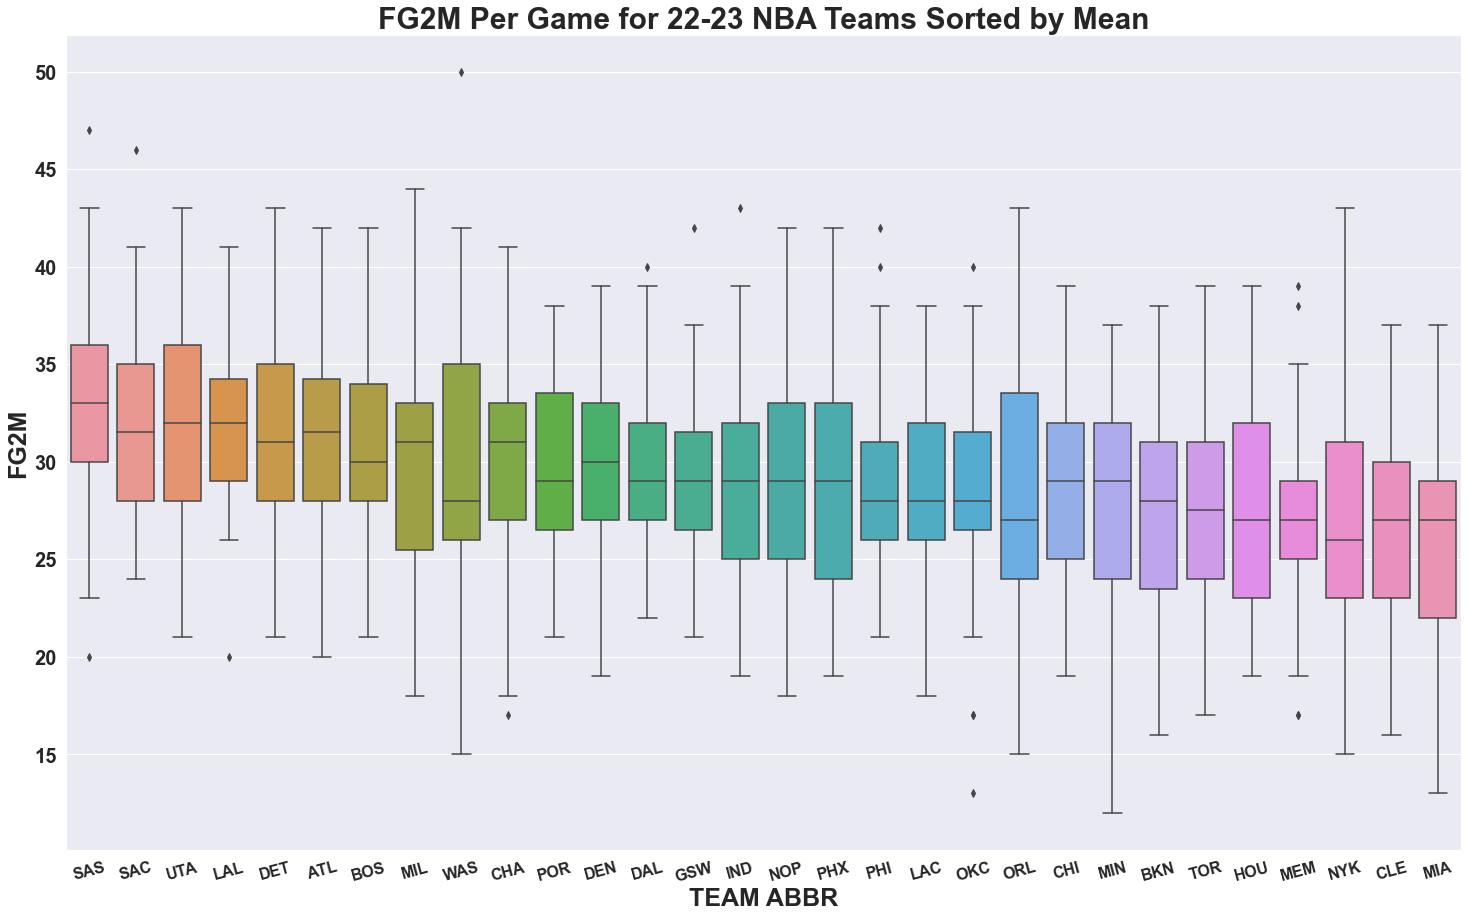

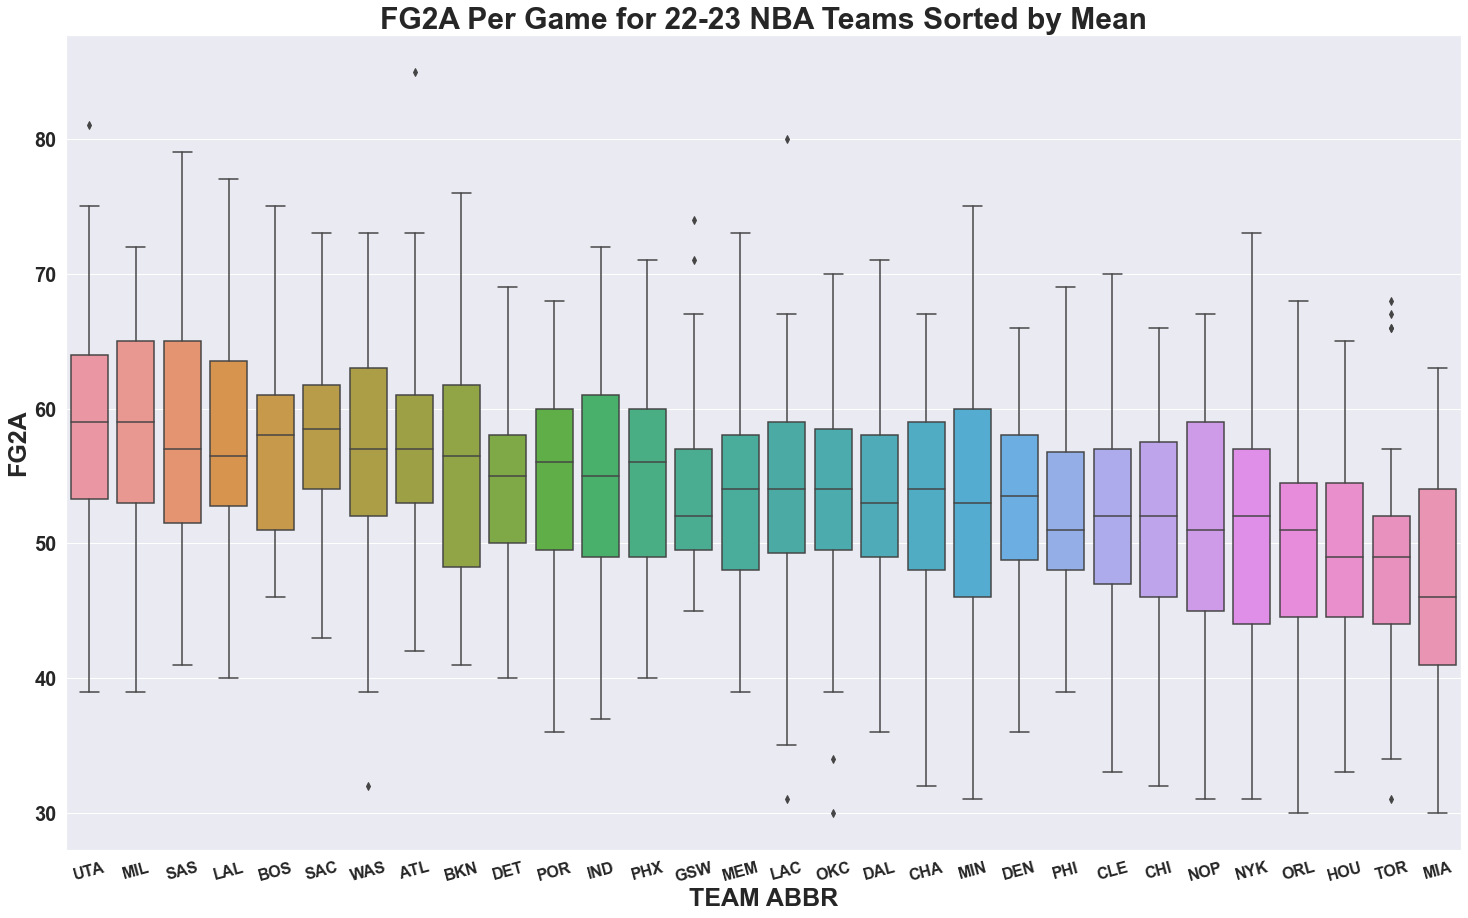

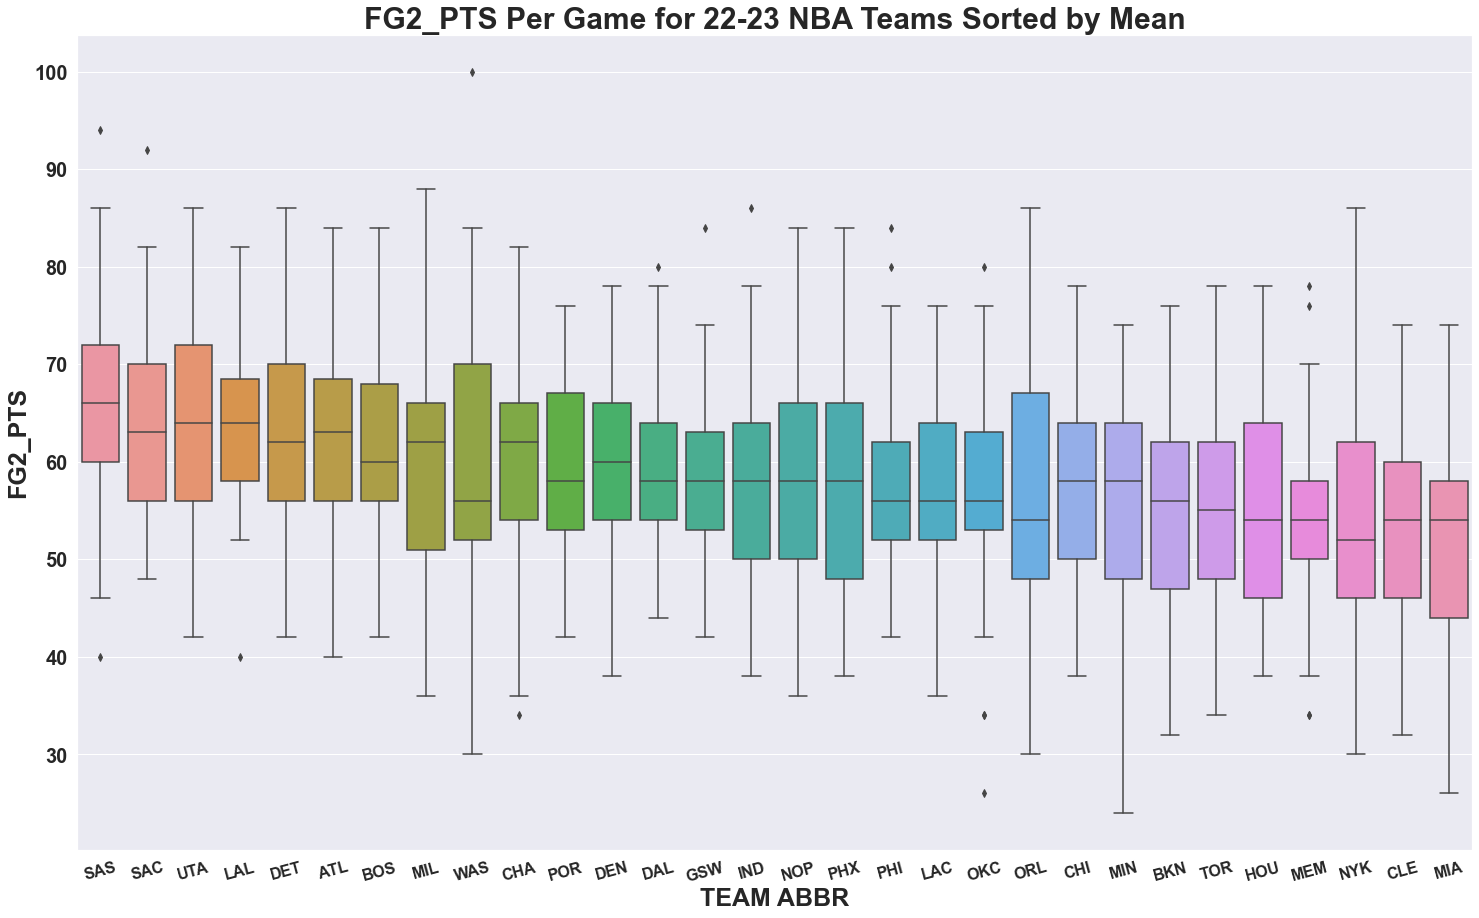

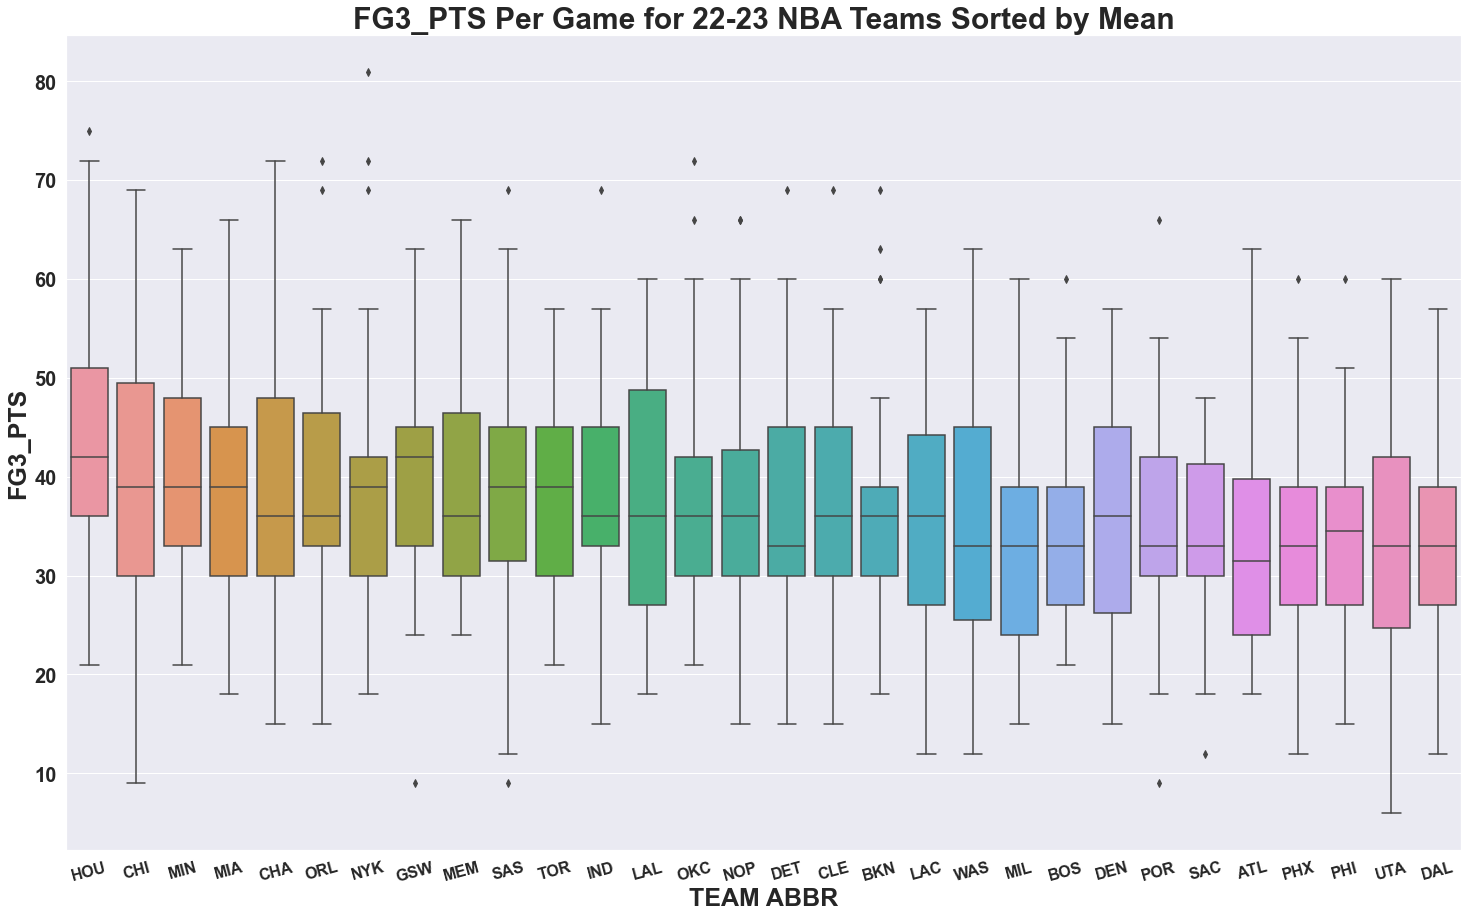

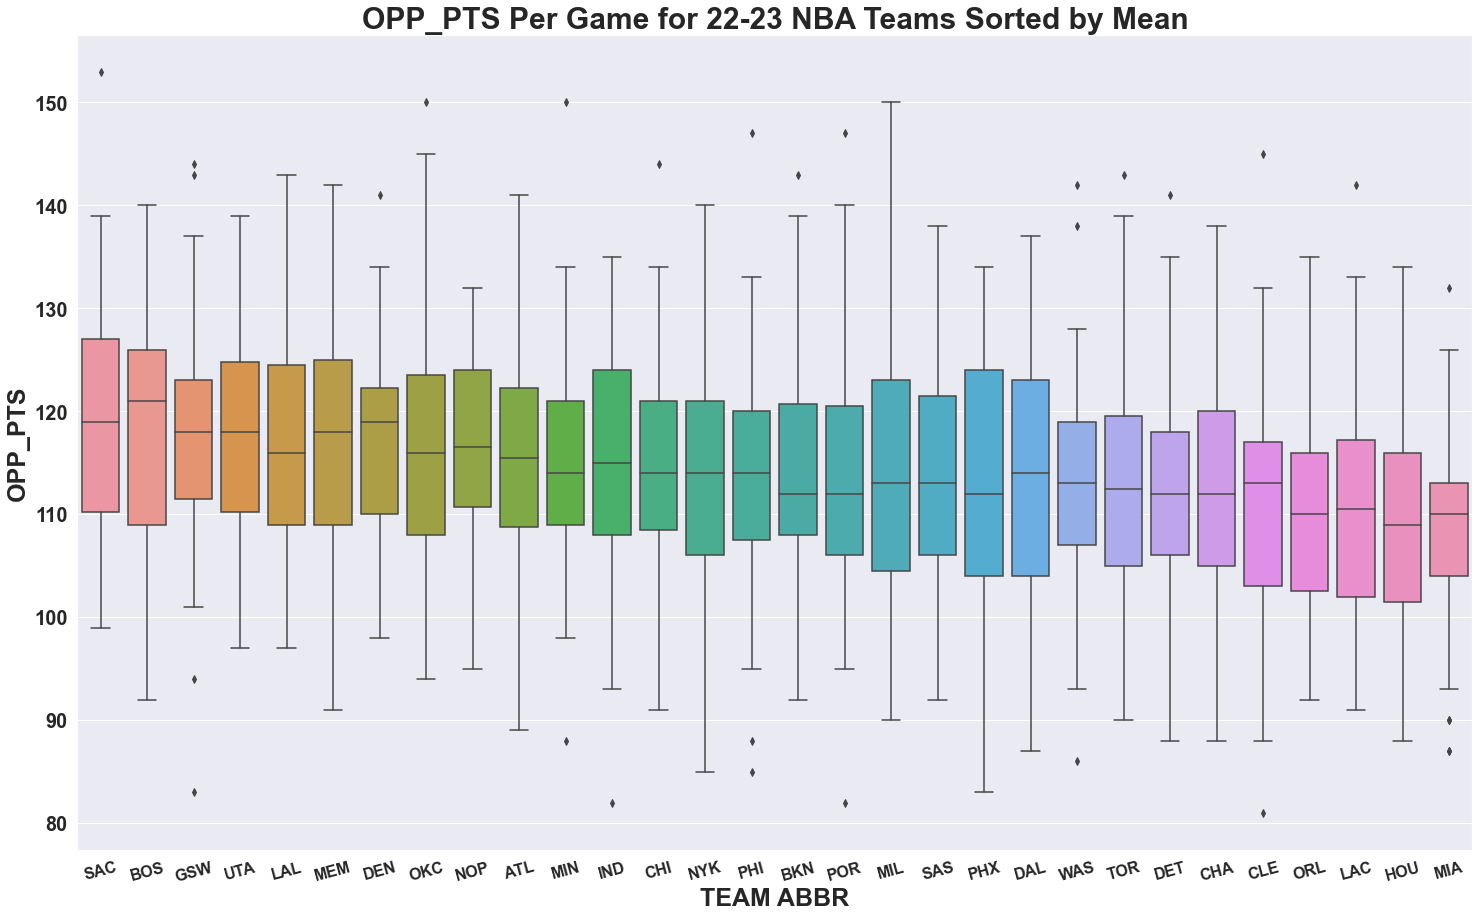

In [40]:
def NBA_team_leaders():
    for i in df.drop(columns=['TEAM_ID','MIN','MONTH','YEAR']).columns:
        if is_numeric_dtype(df[i])==True:
            if i[0:4] !='FRAC':
                NBA_stat_boxplots(i, asc=False)
            
NBA_team_leaders()